# DDM Model Fitting with Dual-Prior Support

This notebook demonstrates fitting of Drift Diffusion Models (DDM) using the optimized implementation that supports dual-prior conditions (equal vs unequal prior blocks).

## Key Features:
- **Dual-prior support**: Separate parameters for equal and unequal prior conditions
- **Optimized performance**: CUDA acceleration and efficient NumPy/PyTorch operations  
- **Robust fitting**: Multi-stage optimization with differential evolution
- **Parameter structure**: 
  - Global parameters: `ndt`, `drift_gain`, `variance`, `leak_rate`, `time_constant`
  - Condition-specific: `a_1/a_2`, `z_1/z_2`, `drift_offset_1/drift_offset_2`

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
from pathlib import Path

from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import pandas as pd

from config import dir_config
from src.decision_models_optimized import *
import time

In [3]:
compiled_dir = Path(dir_config.data.compiled)
processed_dir = Path(dir_config.data.processed)
ddm_dir = Path(dir_config.data.processed, "ddm")

ENABLE_LEAK = True
ENABLE_TIME_DEPENDENCY = True


In [4]:
model_folder = f"ddm_leak_{ENABLE_LEAK}_urgency_{ENABLE_TIME_DEPENDENCY}"
model_dir = Path(ddm_dir, model_folder)

behavior_df = pd.read_csv(Path(ddm_dir, "behavior_data.csv"))
session_ids = behavior_df["session_id"].unique()


## Helper functions

## import data

In [5]:
# get a list of .pkl files in the model directory
pkl_files = list(model_dir.glob("*.pkl"))

for pkl_file in pkl_files:
    with open(pkl_file, "rb") as f:
        file = pickle.load(f)
    break


In [6]:
equal_dict = {"models": [], "results" :[], "session_ids": []}
unequal_dict = {"models": [], "results": [], "session_ids": []}

pkl_files = list(model_dir.glob("*.pkl"))

for pkl_file in pkl_files:
    with open(pkl_file, "rb") as f:
        new_results = pickle.load(f)

    if new_results["results"]["success"]:
        if pkl_file.stem.split("_")[-1] == "equal":
            equal_dict["models"].append(new_results["models"])
            equal_dict["results"].append(new_results["results"])
            equal_dict["session_ids"].append(new_results["session_id"])
        elif pkl_file.stem.split("_")[-1] == "unequal":
            unequal_dict["models"].append(new_results["models"])
            unequal_dict["results"].append(new_results["results"])
            unequal_dict["session_ids"].append(new_results["session_id"])
        else:
            print(f"Unknown model type for {pkl_file.name}")
    else:
        print(f"Fit failed for {pkl_file.name}")


In [14]:
44//45, 45//45, 46//45, 44%45, 45%45, 46%45

(0, 1, 1, 44, 0, 1)

In [7]:
parameters_to_plot = ["a", "z", "drift_offset", "ndt", "drift_gain", "variance", "leak_rate", "time_constant"]

In [8]:
equal_params = {param: [] for param in parameters_to_plot}
unequal_params = {param: [] for param in parameters_to_plot}
session_ids = []
for idx, session_id in enumerate(equal_dict["session_ids"]):
    try:
        idx_unequal = unequal_dict["session_ids"].index(session_id)
        session_ids.append(session_id)
        if behavior_df.loc[behavior_df.session_id == session_id, "prior_direction"].iloc[0] == 'L':
            # flip z and drift_offset parameter
            equal_dict["results"][idx]["parameters"]["z"] = 1 - equal_dict["results"][idx]["parameters"]["z"]
            unequal_dict["results"][idx_unequal]["parameters"]["z"] = 1 - unequal_dict["results"][idx_unequal]["parameters"]["z"]
            equal_dict["results"][idx]["parameters"]["drift_offset"] *= -1
            unequal_dict["results"][idx_unequal]["parameters"]["drift_offset"] *= -1
        for param in parameters_to_plot:
            equal_params[param].append(equal_dict["results"][idx]["parameters"][param])

            unequal_params[param].append(unequal_dict["results"][idx_unequal]["parameters"][param])
    except:
        print(f"Session ID {session_id} not found in unequal dict")

Session ID 250109_GP_TZ not found in unequal dict


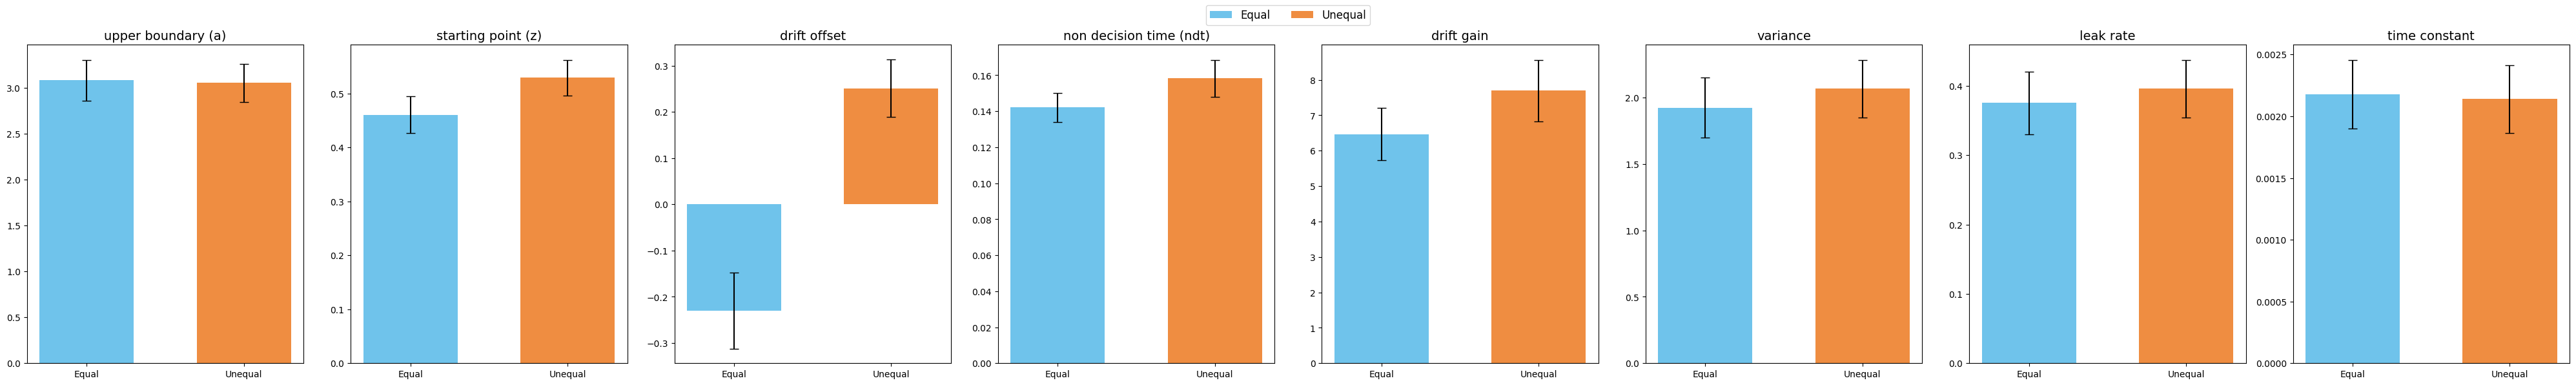

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

# your parameters
params_to_plot = ["a", "z", "drift_offset", "ndt", "drift_gain", "variance", "leak_rate", "time_constant"]
param_names = ["upper boundary (a)", "starting point (z)", "drift offset", "non decision time (ndt)", "drift gain", "variance", "leak rate", "time constant"]
colors = {"Equal": "#6FC3EB", "Unequal": "#EF8D41"}

nrows, ncols = 1, 8
fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 6 * nrows))

for idx_param, param in enumerate(params_to_plot):
    if nrows > 1:
        ax = axs[idx_param // ncols, idx_param % ncols]
    else:
        ax = axs[idx_param % ncols]


    means_1 = np.mean(equal_params[param])
    sems_1 = sem(equal_params[param])
    means_2 = np.mean(unequal_params[param])
    sems_2 = sem(unequal_params[param])

    ax.bar(0, means_1, yerr=sems_1, capsize=5, width=0.6, color=colors["Equal"], label="Equal")
    ax.bar(1, means_2, yerr=sems_2, capsize=5, width=0.6, color=colors["Unequal"], label="Unequal")

    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Equal', 'Unequal'])
    ax.set_title(param_names[idx_param], fontsize=14)

# one shared legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[:2], labels[:2], loc="upper center", ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for legend
plt.show()


In [10]:
def simulate_ddm(idx_prior, model, result_dict, stimulus, enable_leak=False, enable_time_dependence=False):
    """
    Simulate DDM for a specific prior condition using fitted parameters.

    Args:
        idx_prior: 0 for 'equal' prior, 1 for 'unequal' prior
        model: The fitted DecisionModel instance
        result_dict: Dictionary containing fitted parameters
        stimulus: Stimulus array for this prior condition
        enable_leak: Whether leak was enabled in fitting
        enable_time_dependence: Whether time dependence was enabled in fitting

    Returns:
        DataFrame with simulated data
    """
    # Get parameters from the result dictionary
    parameters = result_dict["parameters"]

    # Update model parameters for this specific prior condition
    param_names = list(parameters.keys())

    for param_name, param_value in parameters.items():
        if param_name.endswith(f"_{idx_prior + 1}"):
            # Prior-specific parameter (remove suffix)
            base_name = param_name[:-2]
            setattr(model.simulator, base_name, param_value)
            print(f"{base_name} (prior {idx_prior + 1}): {param_value:.4f}")
        elif "_" not in param_name or not param_name[-1].isdigit():
            # Global parameter
            setattr(model.simulator, param_name, param_value)
            print(f"{param_name} (global): {param_value:.4f}")

    # Simulate trials using the model's simulate method
    sim_result = model.simulate(stimulus, n_reps=1)

    # Create DataFrame of simulated data
    model_sim = pd.DataFrame({
        "signed_coherence": sim_result["coherence"] * 100,  # Convert back to original scale
        "choice": sim_result["choice"],
        "rt": sim_result["rt"],
    })

    return model_sim

In [11]:
def plot_ddm_fit(model_sim, data):
    # Get psychometric and chronometric data for both real and simulated data
    x_data, y_data = get_psychometric_data(data)
    _, rt_median, rt_mean, rt_sd, _ = get_chronometric_data(data)
    x_model, y_model = get_psychometric_data(model_sim)
    _, rt_median_model, rt_mean_model, rt_sd_model, _ = get_chronometric_data(model_sim)

    # Plotting
    fig = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(2, 2)

    # Psychometric plot (proportion choice)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(x_data, y_data, "o", color="k", label="data")
    ax1.plot(x_model, y_model, "o", color="b", label="model")
    ax1.set_ylim(-0.1, 1.1)
    ax1.legend()

    # Chronometric plot (RT means)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(x_data, rt_mean, "o", color="k", label="data")
    ax2.fill_between(x_data, rt_mean - rt_sd, rt_mean + rt_sd, color="k", alpha=0.2)
    ax2.fill_between(x_model, rt_mean_model - rt_sd_model, rt_mean_model + rt_sd_model, color="b", alpha=0.2)
    ax2.plot(x_model, rt_mean_model, "o", color="b", label="model", markersize=8)
    ax2.legend()

    # ax3 = fig.add_subplot(gs[1, :])
    # ax3.plot(dv.T, color="k", alpha=0.1)

    plt.tight_layout()
    plt.show()

    # Print proportion of invalid trials (NaN choices)
    print("Proportion of invalid trials:", np.mean(np.isnan(model_sim["choice"])))

    # return model_sim, ddm


Fitting session 241211_GP_TZ

Session: 241211_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 545 trials
a (global): 2.4512
z (global): 0.1949
drift_offset (global): 0.2042
ndt (global): 0.1978
drift_gain (global): 9.5508
variance (global): 4.1359
leak_rate (global): 0.5887
time_constant (global): 0.0015

Simulation completed. Generated 545 trials.
Valid simulated trials: 545


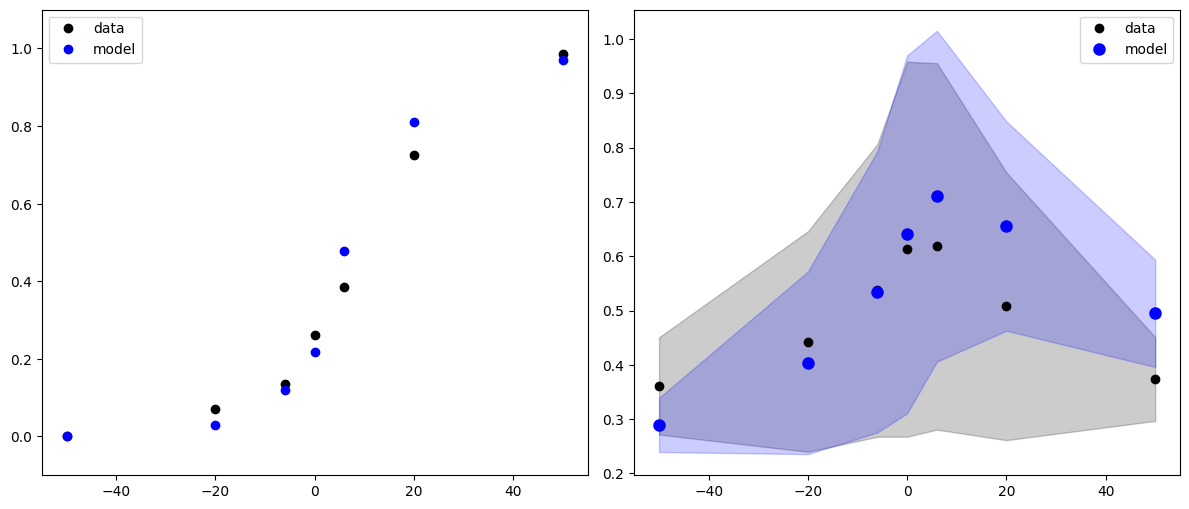

Proportion of invalid trials: 0.0

Session: 241211_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 634 trials
a (global): 2.4570
z (global): 0.6211
drift_offset (global): -0.1699
ndt (global): 0.3076
drift_gain (global): 7.5003
variance (global): 3.1372
leak_rate (global): 0.5621
time_constant (global): 0.0011

Simulation completed. Generated 634 trials.
Valid simulated trials: 634


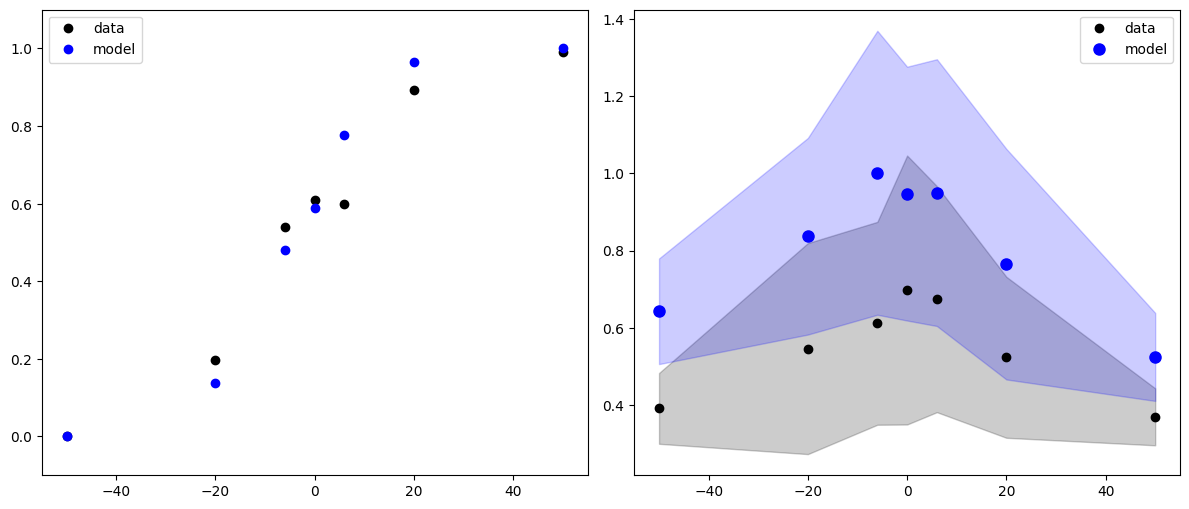

Proportion of invalid trials: 0.0
Fitting session 241217_GP_TZ

Session: 241217_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 503 trials
a (global): 2.5015
z (global): 0.5176
drift_offset (global): -0.3924
ndt (global): 0.1359
drift_gain (global): 11.8168
variance (global): 1.7532
leak_rate (global): 0.4467
time_constant (global): 0.0011

Simulation completed. Generated 503 trials.
Valid simulated trials: 503


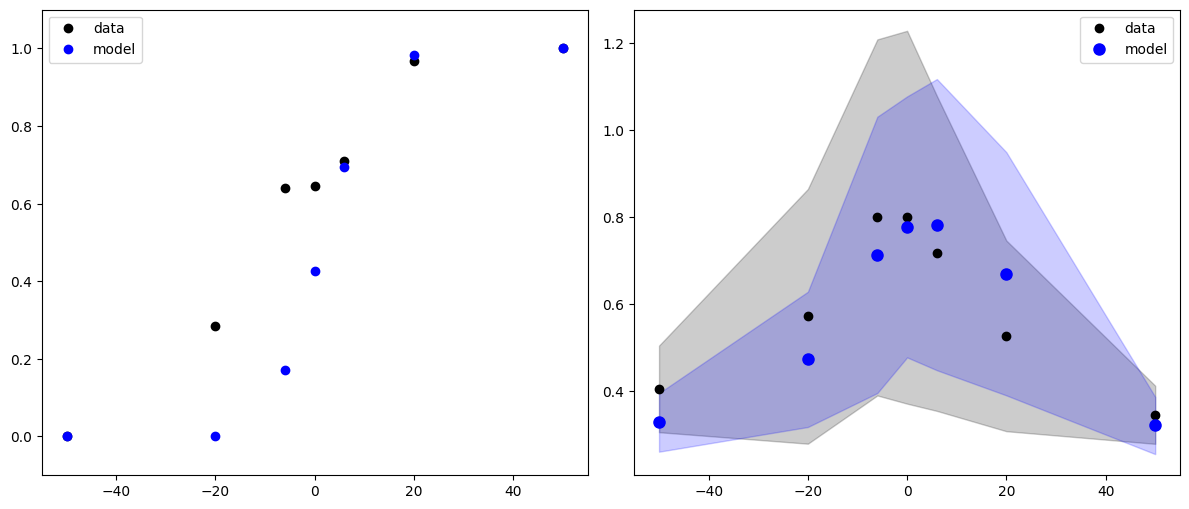

Proportion of invalid trials: 0.0

Session: 241217_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 707 trials
a (global): 3.8910
z (global): 0.6513
drift_offset (global): 0.2174
ndt (global): 0.1490
drift_gain (global): 1.6205
variance (global): 1.3557
leak_rate (global): 0.5514
time_constant (global): 0.0024

Simulation completed. Generated 707 trials.
Valid simulated trials: 707


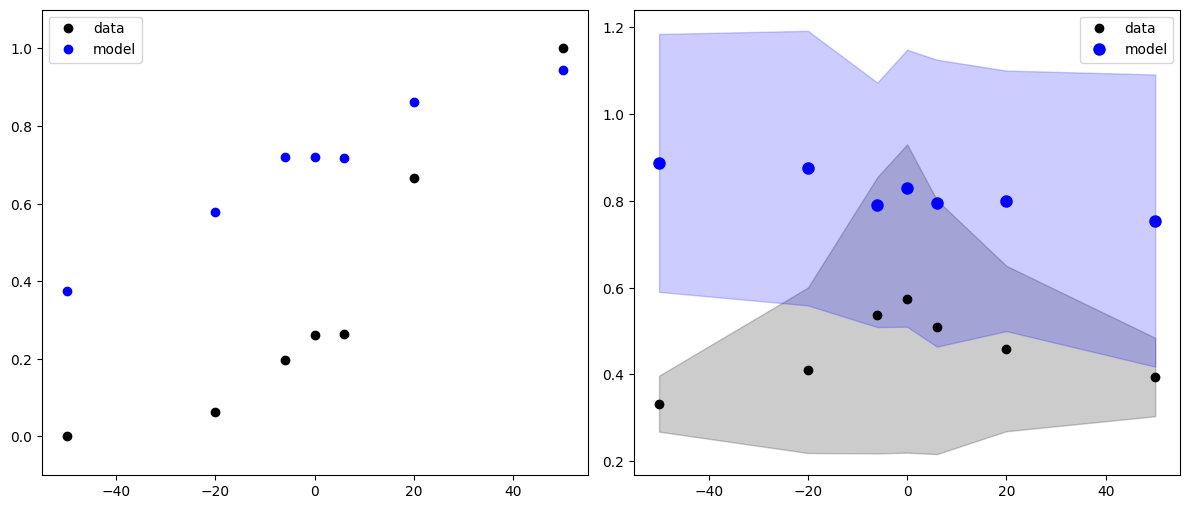

Proportion of invalid trials: 0.0
Fitting session 210317_GP_JP

Session: 210317_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 355 trials
a (global): 0.8000
z (global): 0.1000
drift_offset (global): 0.0100
ndt (global): 0.1000
drift_gain (global): 1.0000
variance (global): 0.1274
leak_rate (global): 0.0000
time_constant (global): 0.0010

Simulation completed. Generated 355 trials.
Valid simulated trials: 252


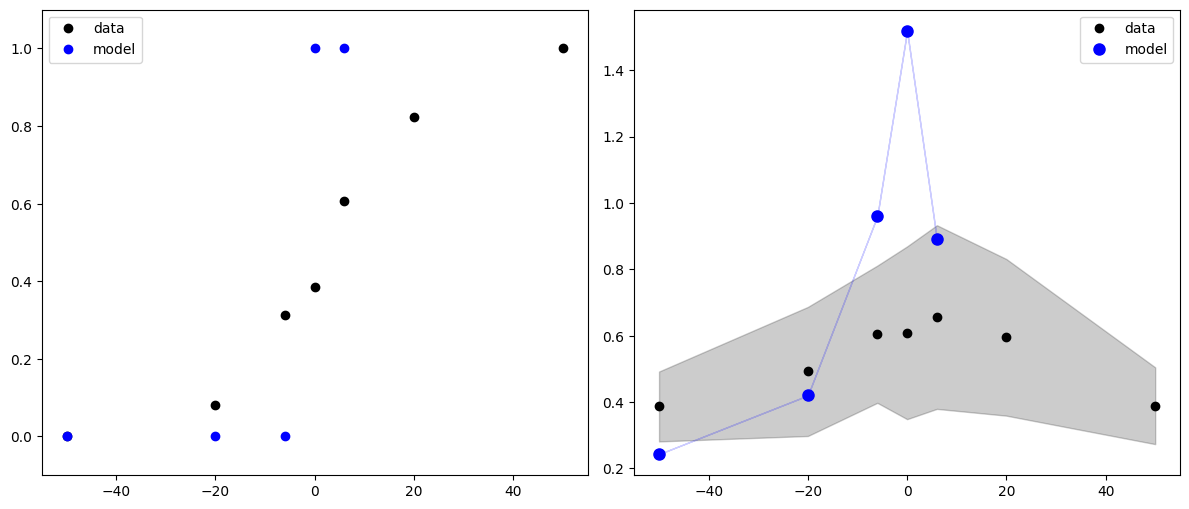

Proportion of invalid trials: 0.29014084507042254

Session: 210317_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 692 trials
a (global): 2.3432
z (global): 0.7357
drift_offset (global): 0.1785
ndt (global): 0.1440
drift_gain (global): 19.1796
variance (global): 1.8012
leak_rate (global): 0.1809
time_constant (global): 0.0011

Simulation completed. Generated 692 trials.
Valid simulated trials: 692


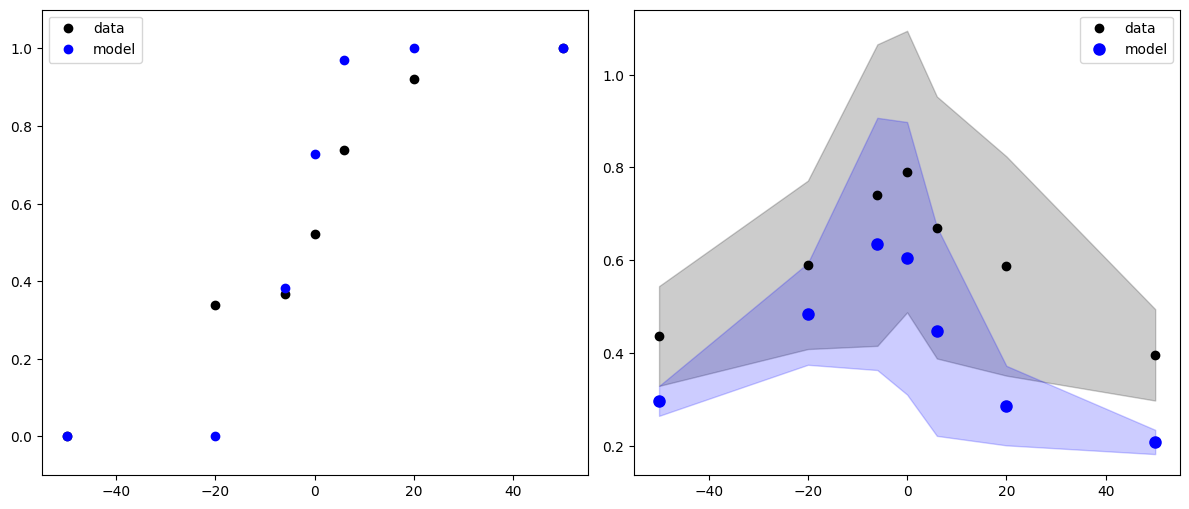

Proportion of invalid trials: 0.0
Fitting session 210315_GP_JP

Session: 210315_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 352 trials
a (global): 0.8000
z (global): 0.1000
drift_offset (global): -0.0000
ndt (global): 0.1000
drift_gain (global): 1.0000
variance (global): 0.1000
leak_rate (global): 0.0000
time_constant (global): 0.0010

Simulation completed. Generated 352 trials.
Valid simulated trials: 251


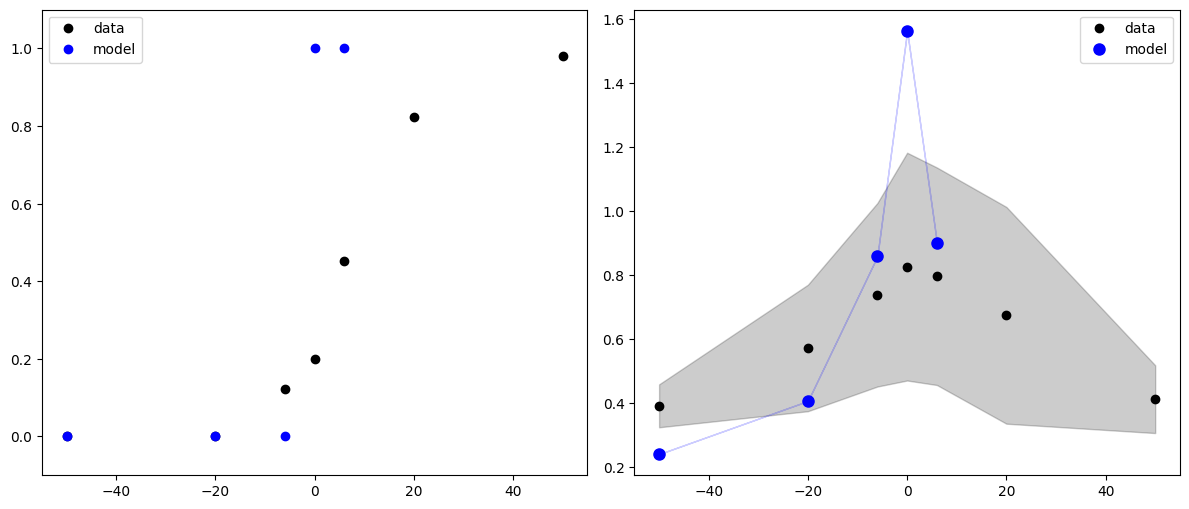

Proportion of invalid trials: 0.2869318181818182

Session: 210315_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 805 trials
a (global): 4.5983
z (global): 0.5742
drift_offset (global): -0.1268
ndt (global): 0.1338
drift_gain (global): 3.4441
variance (global): 1.1932
leak_rate (global): 0.4490
time_constant (global): 0.0043

Simulation completed. Generated 805 trials.
Valid simulated trials: 805


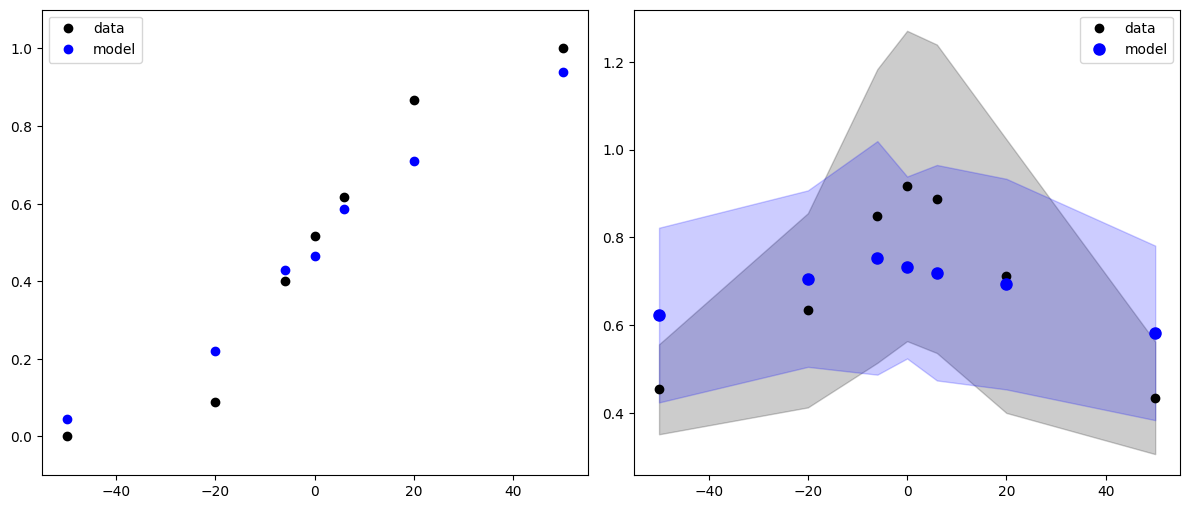

Proportion of invalid trials: 0.0
Fitting session 210311_GP_JP

Session: 210311_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 356 trials
a (global): 0.8000
z (global): 0.1000
drift_offset (global): 0.0100
ndt (global): 0.1000
drift_gain (global): 1.0000
variance (global): 0.1274
leak_rate (global): 0.0000
time_constant (global): 0.0010

Simulation completed. Generated 356 trials.
Valid simulated trials: 202


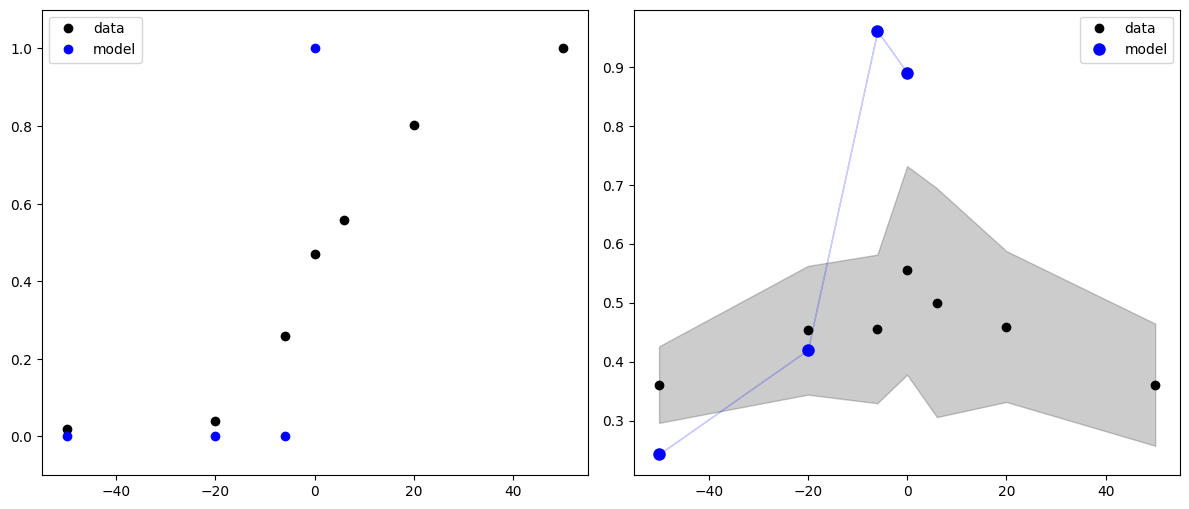

Proportion of invalid trials: 0.43258426966292135

Session: 210311_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 764 trials
a (global): 3.0860
z (global): 0.4715
drift_offset (global): 0.0507
ndt (global): 0.1101
drift_gain (global): 4.0555
variance (global): 0.8055
leak_rate (global): 0.0143
time_constant (global): 0.0034

Simulation completed. Generated 764 trials.
Valid simulated trials: 764


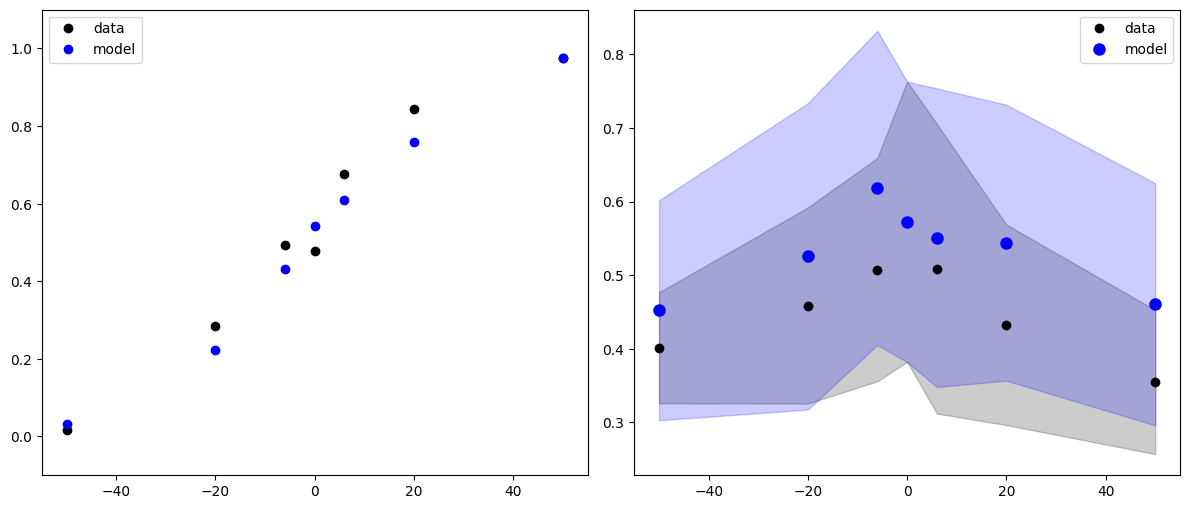

Proportion of invalid trials: 0.0
Fitting session 210602_GP_JP

Session: 210602_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 441 trials
a (global): 2.6603
z (global): 0.5245
drift_offset (global): -0.0974
ndt (global): 0.1227
drift_gain (global): 4.0530
variance (global): 1.5558
leak_rate (global): 0.4496
time_constant (global): 0.0018

Simulation completed. Generated 441 trials.
Valid simulated trials: 441


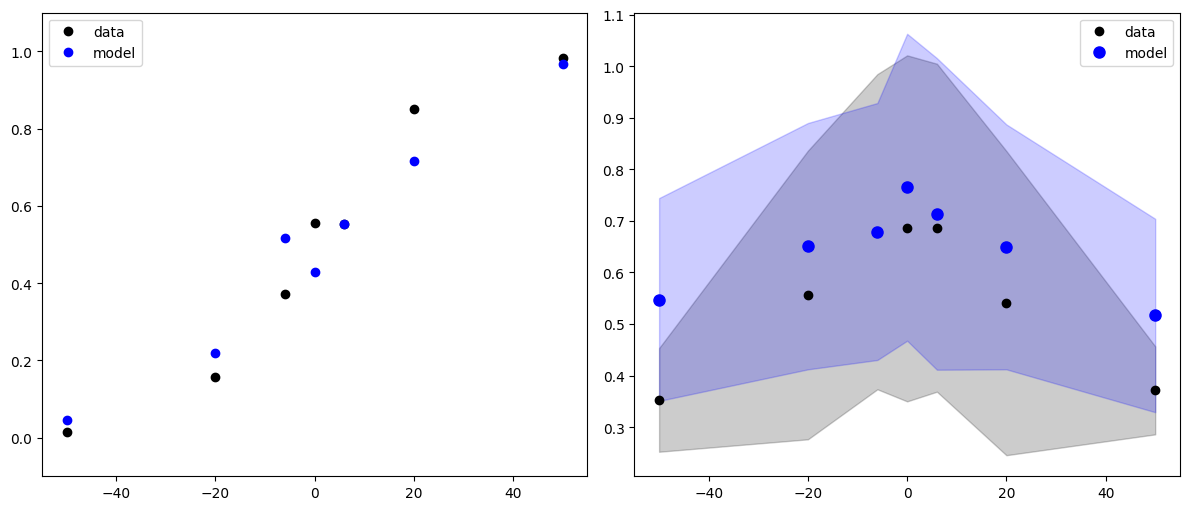

Proportion of invalid trials: 0.0

Session: 210602_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 694 trials
a (global): 2.3250
z (global): 0.2801
drift_offset (global): 1.0382
ndt (global): 0.1464
drift_gain (global): 11.1959
variance (global): 4.4998
leak_rate (global): 0.9362
time_constant (global): 0.0013

Simulation completed. Generated 694 trials.
Valid simulated trials: 694


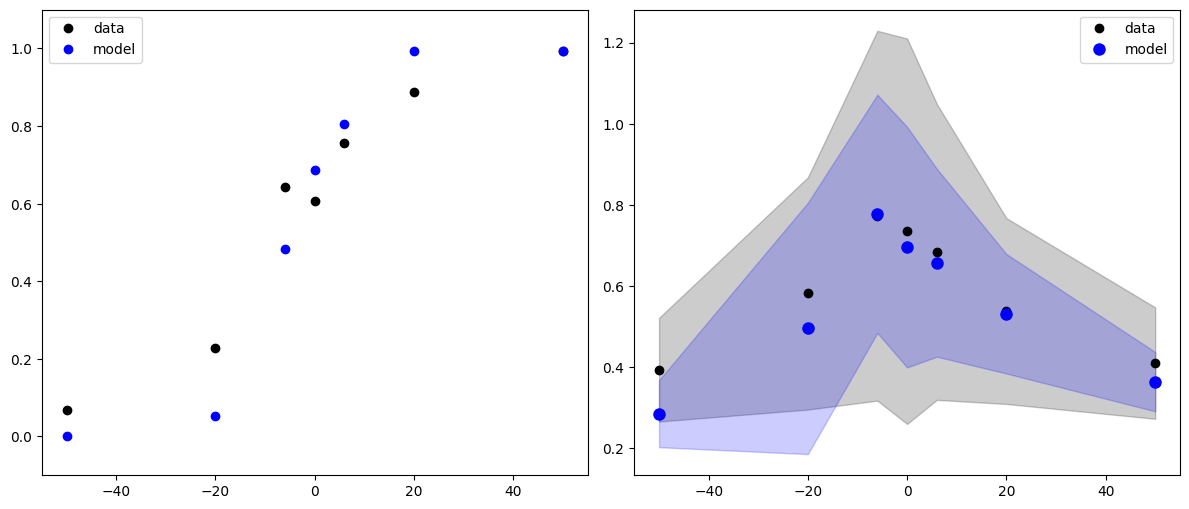

Proportion of invalid trials: 0.0
Fitting session 240903_GP_TZ

Session: 240903_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 546 trials
a (global): 3.4363
z (global): 0.5728
drift_offset (global): -0.0033
ndt (global): 0.1005
drift_gain (global): 10.0045
variance (global): 1.7071
leak_rate (global): 0.5172
time_constant (global): 0.0031

Simulation completed. Generated 546 trials.
Valid simulated trials: 546


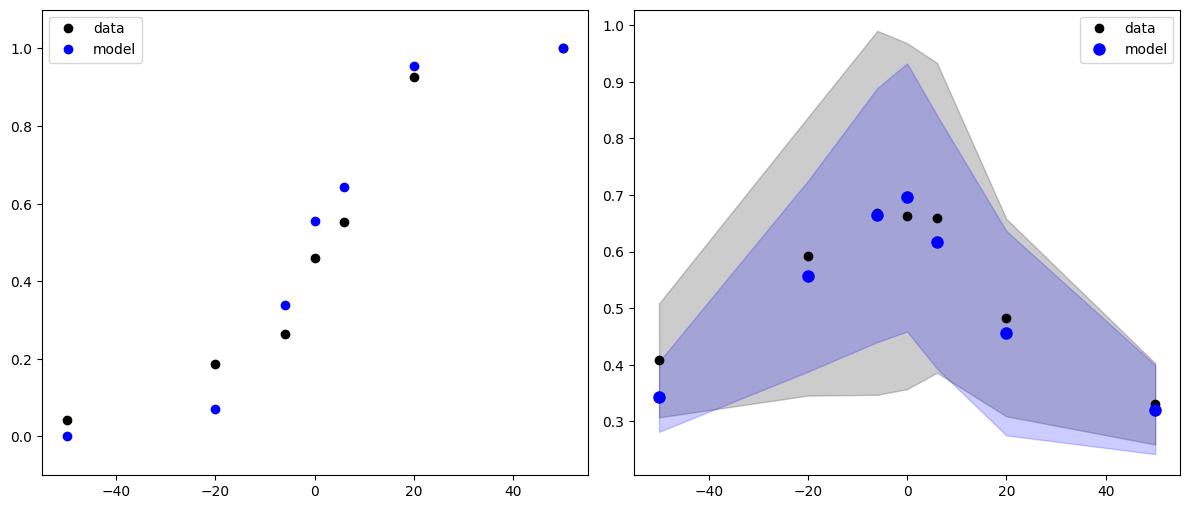

Proportion of invalid trials: 0.0

Session: 240903_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 686 trials
a (global): 4.7903
z (global): 0.2300
drift_offset (global): 1.0691
ndt (global): 0.2189
drift_gain (global): 1.2110
variance (global): 2.2710
leak_rate (global): 0.2616
time_constant (global): 0.0016

Simulation completed. Generated 686 trials.
Valid simulated trials: 642


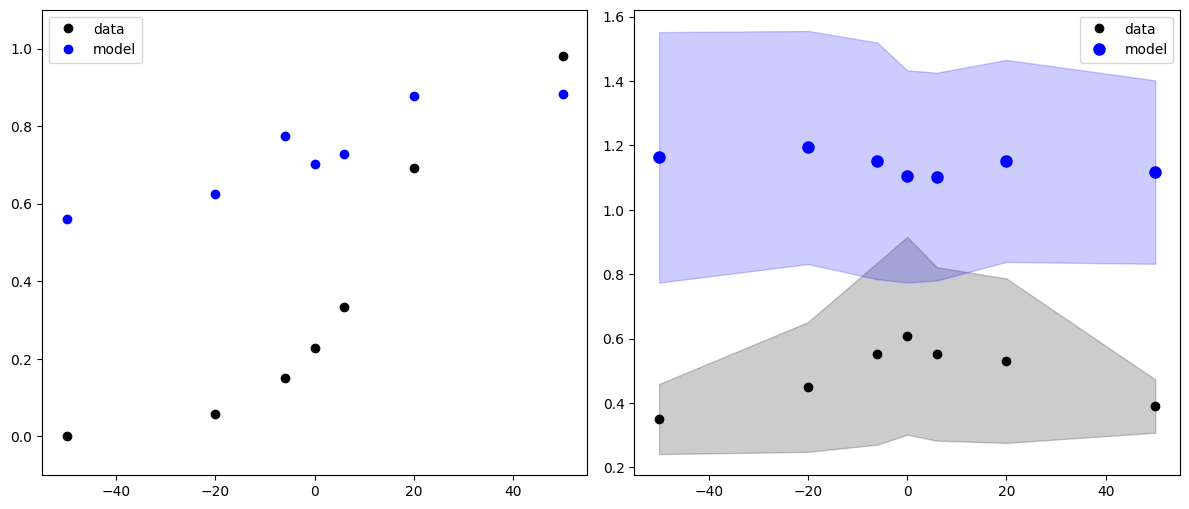

Proportion of invalid trials: 0.0641399416909621
Fitting session 210126_GP_JP

Session: 210126_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 448 trials
a (global): 2.1672
z (global): 0.6518
drift_offset (global): -0.8627
ndt (global): 0.1918
drift_gain (global): 4.7001
variance (global): 0.5400
leak_rate (global): 0.4675
time_constant (global): 0.0035

Simulation completed. Generated 448 trials.
Valid simulated trials: 448


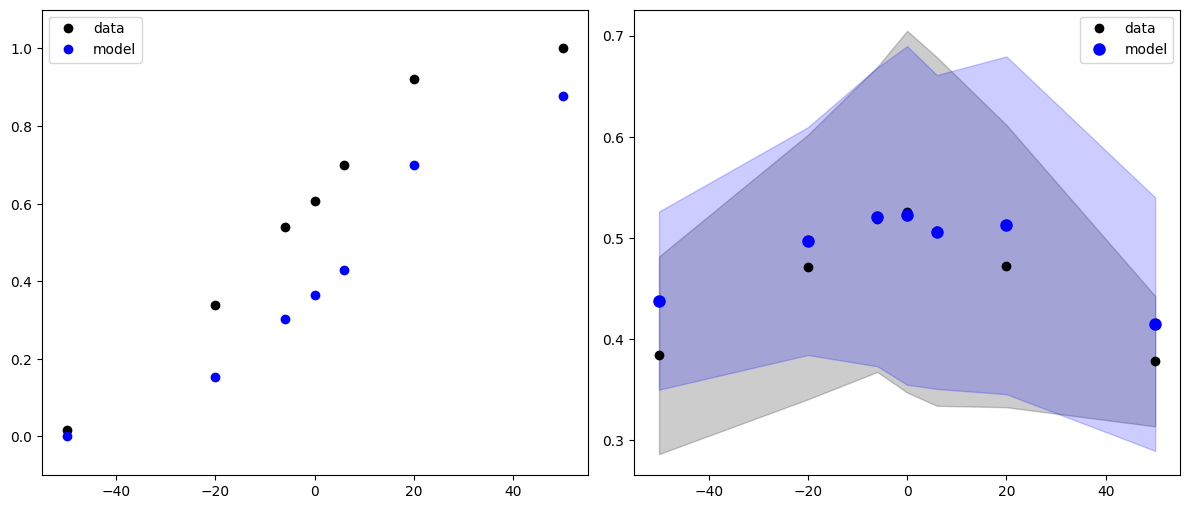

Proportion of invalid trials: 0.0

Session: 210126_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 613 trials
a (global): 4.0226
z (global): 0.5490
drift_offset (global): -0.0392
ndt (global): 0.1995
drift_gain (global): 16.4006
variance (global): 1.0007
leak_rate (global): 0.3706
time_constant (global): 0.0033

Simulation completed. Generated 613 trials.
Valid simulated trials: 609


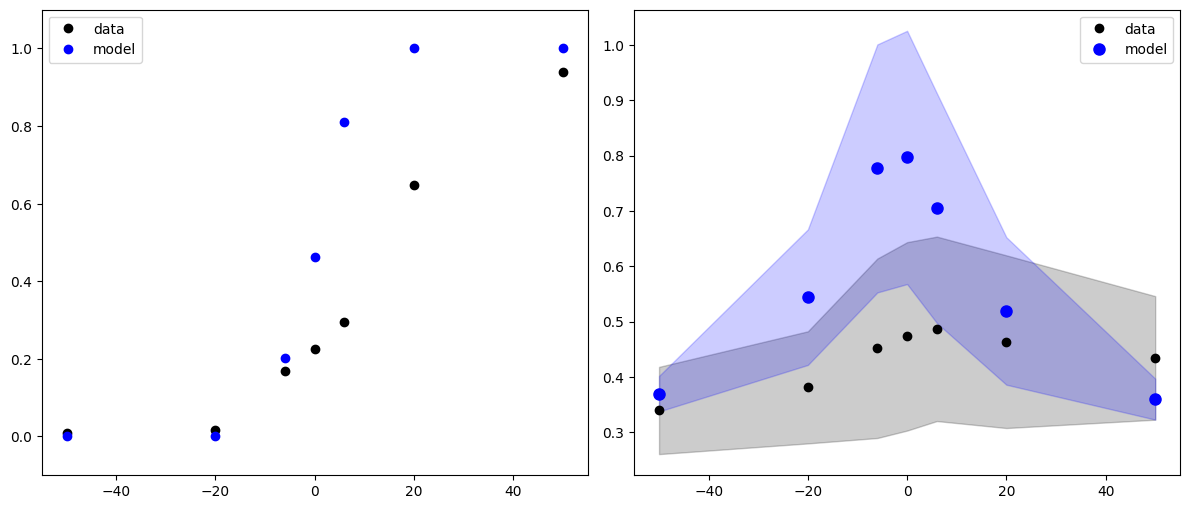

Proportion of invalid trials: 0.0065252854812398045
Fitting session 210608_GP_JP

Session: 210608_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 490 trials
a (global): 3.0162
z (global): 0.6000
drift_offset (global): -1.2547
ndt (global): 0.1665
drift_gain (global): 6.5767
variance (global): 4.3466
leak_rate (global): 0.1166
time_constant (global): 0.0011

Simulation completed. Generated 490 trials.
Valid simulated trials: 490


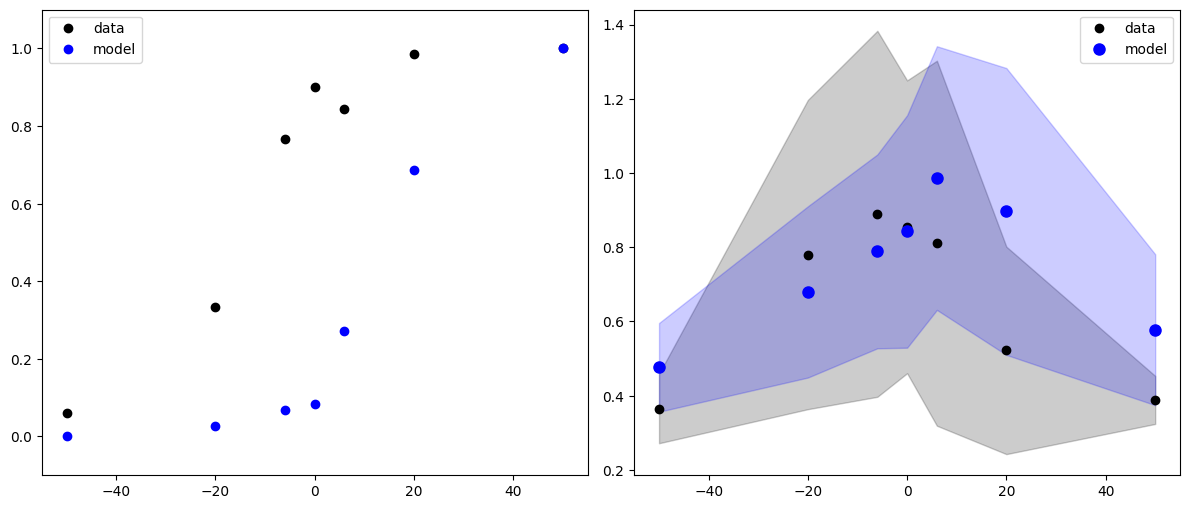

Proportion of invalid trials: 0.0

Session: 210608_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 732 trials
a (global): 2.2529
z (global): 0.5443
drift_offset (global): 0.4899
ndt (global): 0.2555
drift_gain (global): 12.7013
variance (global): 2.6164
leak_rate (global): 0.2683
time_constant (global): 0.0012

Simulation completed. Generated 732 trials.
Valid simulated trials: 732


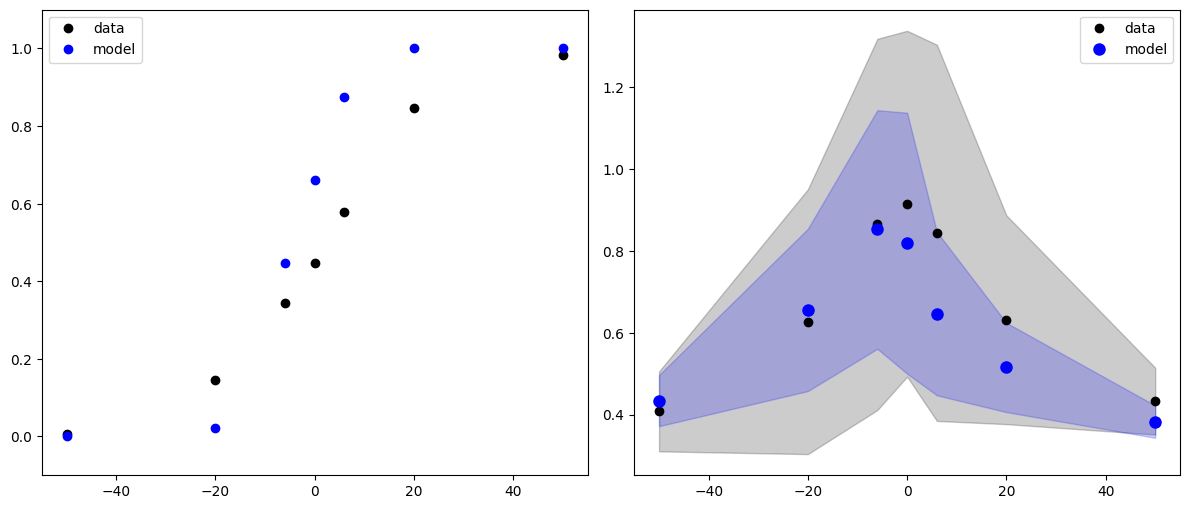

Proportion of invalid trials: 0.0
Fitting session 210305_GP_JP

Session: 210305_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 354 trials
a (global): 5.1102
z (global): 0.6224
drift_offset (global): -0.8606
ndt (global): 0.1461
drift_gain (global): 2.6004
variance (global): 2.1584
leak_rate (global): 0.2137
time_constant (global): 0.0028

Simulation completed. Generated 354 trials.
Valid simulated trials: 354


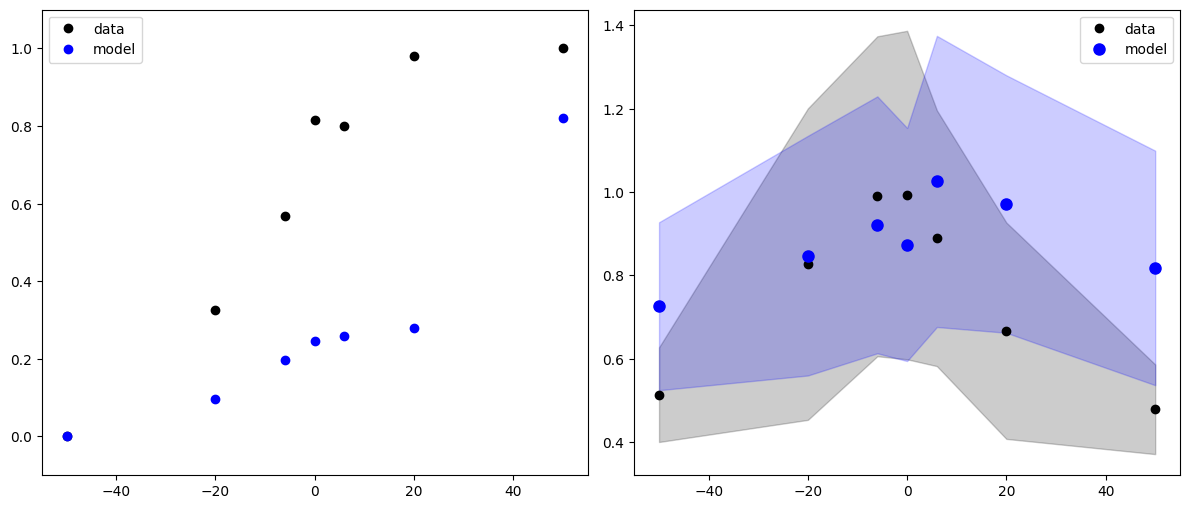

Proportion of invalid trials: 0.0

Session: 210305_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 700 trials
a (global): 3.0881
z (global): 0.4327
drift_offset (global): 0.7907
ndt (global): 0.1741
drift_gain (global): 14.1278
variance (global): 1.2618
leak_rate (global): 0.4599
time_constant (global): 0.0011

Simulation completed. Generated 700 trials.
Valid simulated trials: 700


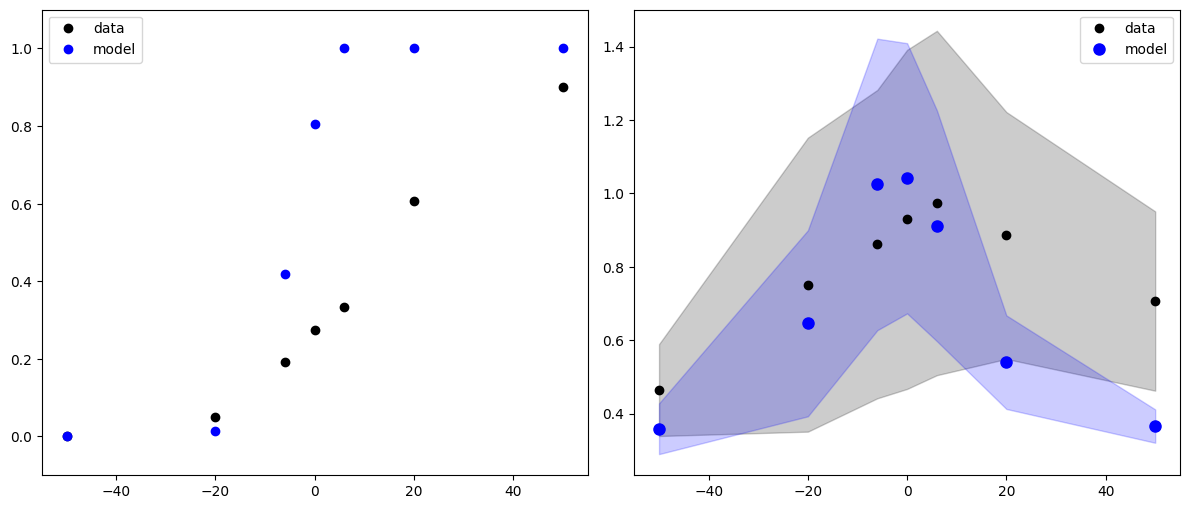

Proportion of invalid trials: 0.0
Fitting session 241209_GP_TZ

Session: 241209_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 444 trials
a (global): 1.8367
z (global): 0.4429
drift_offset (global): -1.9660
ndt (global): 0.1503
drift_gain (global): 10.9487
variance (global): 2.3294
leak_rate (global): 0.8377
time_constant (global): 0.0020

Simulation completed. Generated 444 trials.
Valid simulated trials: 444


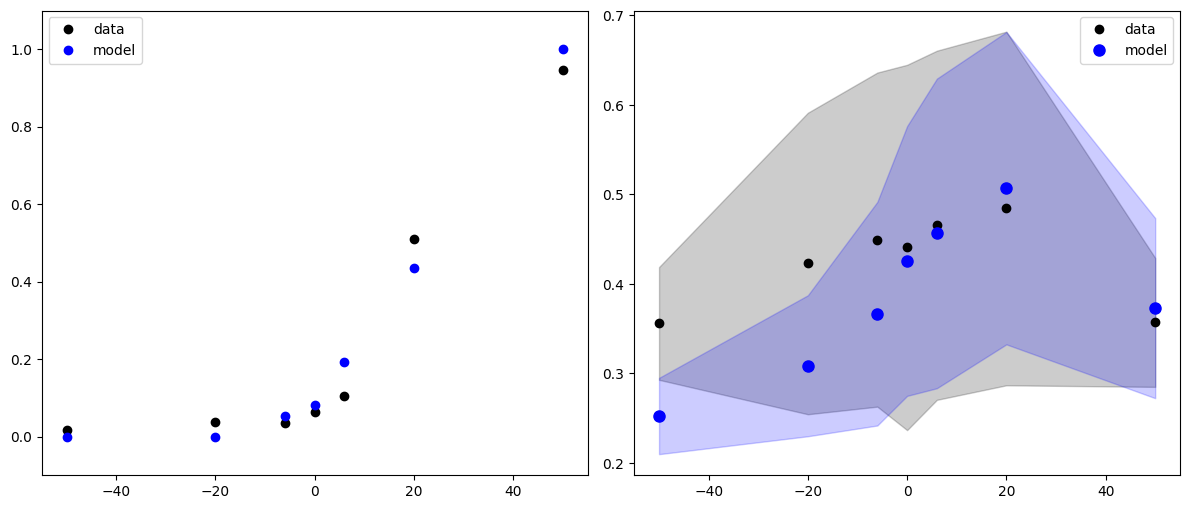

Proportion of invalid trials: 0.0

Session: 241209_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 674 trials
a (global): 5.3208
z (global): 0.7194
drift_offset (global): 0.2391
ndt (global): 0.1514
drift_gain (global): 14.9856
variance (global): 3.0087
leak_rate (global): 0.5714
time_constant (global): 0.0030

Simulation completed. Generated 674 trials.
Valid simulated trials: 671


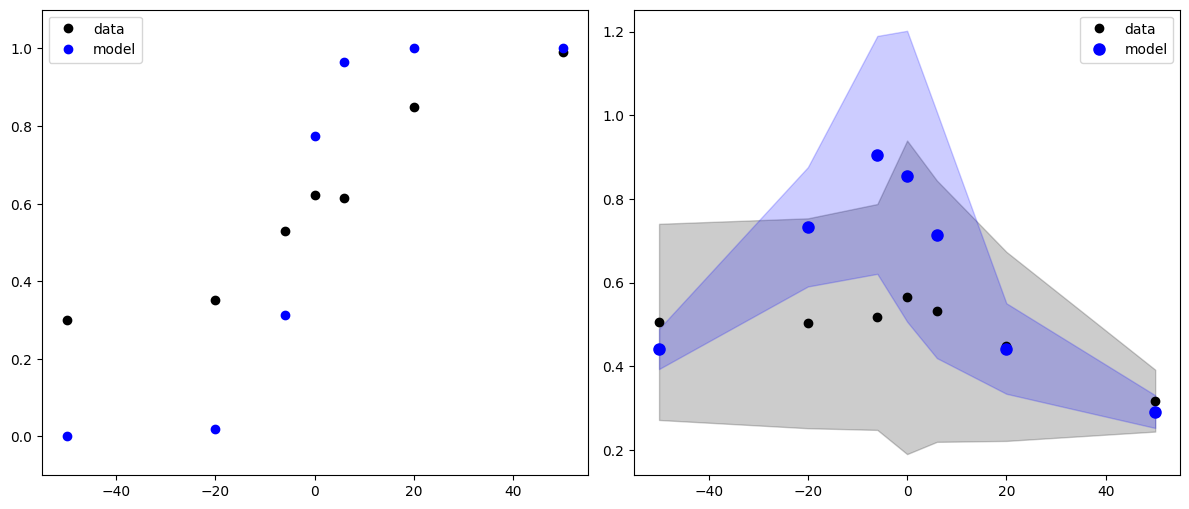

Proportion of invalid trials: 0.004451038575667656
Fitting session 210413_GP_JP

Session: 210413_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 350 trials
a (global): 2.7890
z (global): 0.7708
drift_offset (global): -0.7993
ndt (global): 0.2649
drift_gain (global): 10.7051
variance (global): 1.9664
leak_rate (global): 0.2122
time_constant (global): 0.0014

Simulation completed. Generated 350 trials.
Valid simulated trials: 350


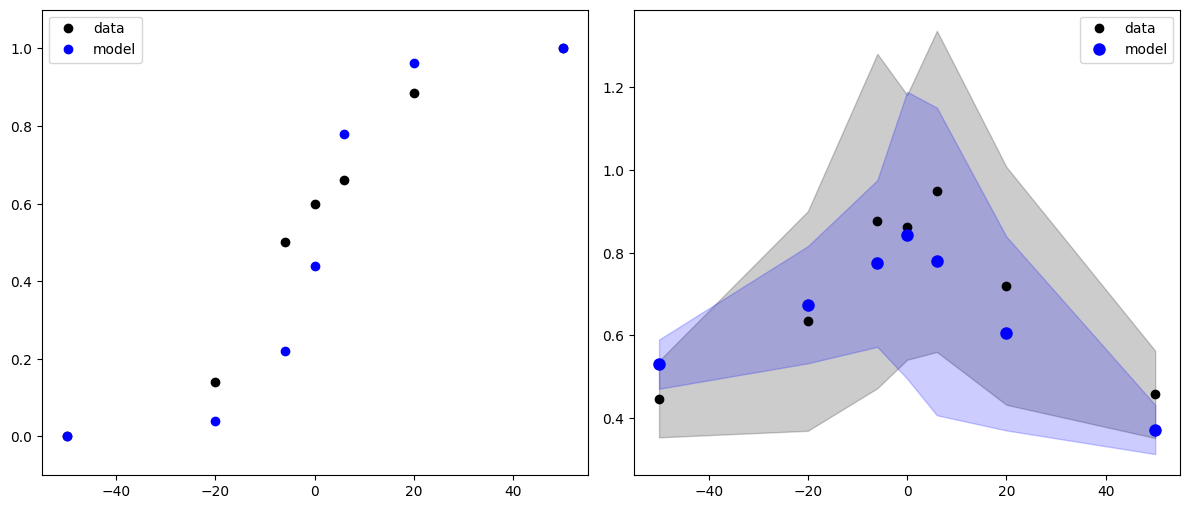

Proportion of invalid trials: 0.0

Session: 210413_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 704 trials
a (global): 1.9540
z (global): 0.3267
drift_offset (global): 1.2755
ndt (global): 0.1003
drift_gain (global): 4.3579
variance (global): 3.4167
leak_rate (global): 0.1355
time_constant (global): 0.0011

Simulation completed. Generated 704 trials.
Valid simulated trials: 704


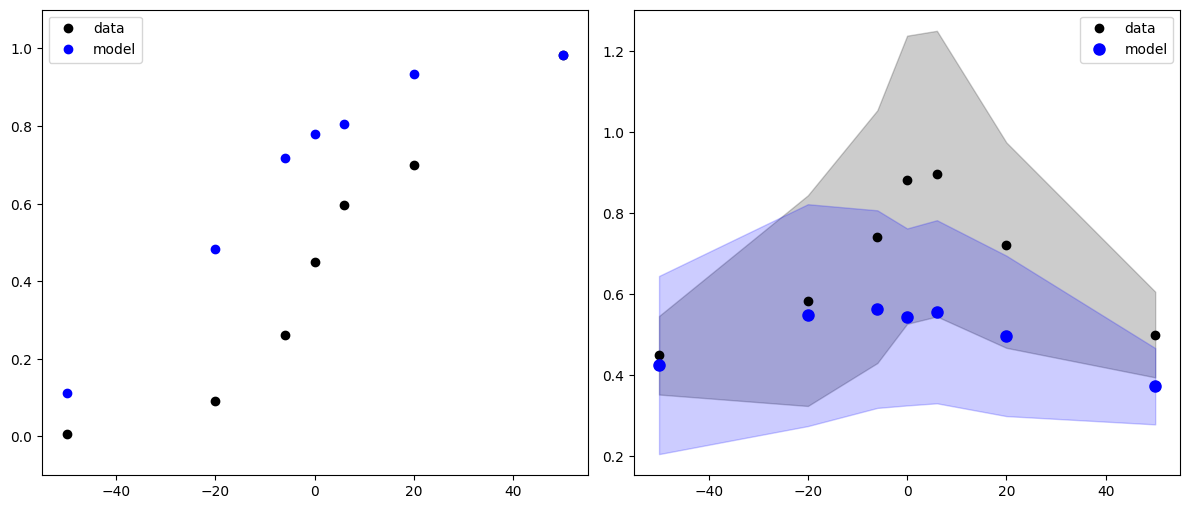

Proportion of invalid trials: 0.0
Fitting session 250108_GP_TZ

Session: 250108_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 480 trials
a (global): 3.2951
z (global): 0.4035
drift_offset (global): 0.3205
ndt (global): 0.1253
drift_gain (global): 15.3618
variance (global): 0.4025
leak_rate (global): 0.0396
time_constant (global): 0.0012

Simulation completed. Generated 480 trials.
Valid simulated trials: 480


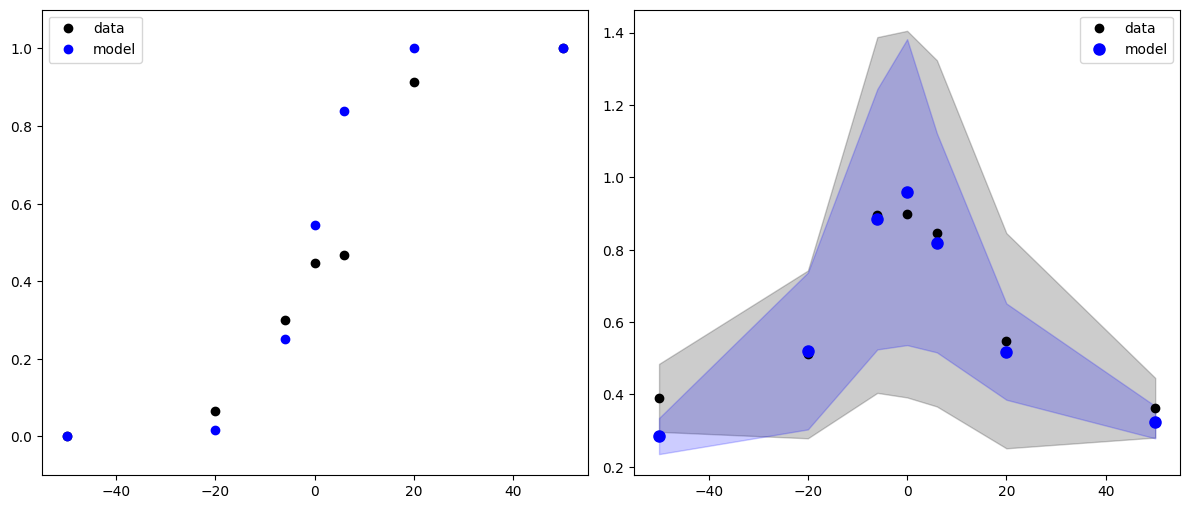

Proportion of invalid trials: 0.0

Session: 250108_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 595 trials
a (global): 0.8000
z (global): 0.1000
drift_offset (global): 0.0000
ndt (global): 0.1000
drift_gain (global): 1.0000
variance (global): 0.1000
leak_rate (global): 0.0000
time_constant (global): 0.0010

Simulation completed. Generated 595 trials.
Valid simulated trials: 402


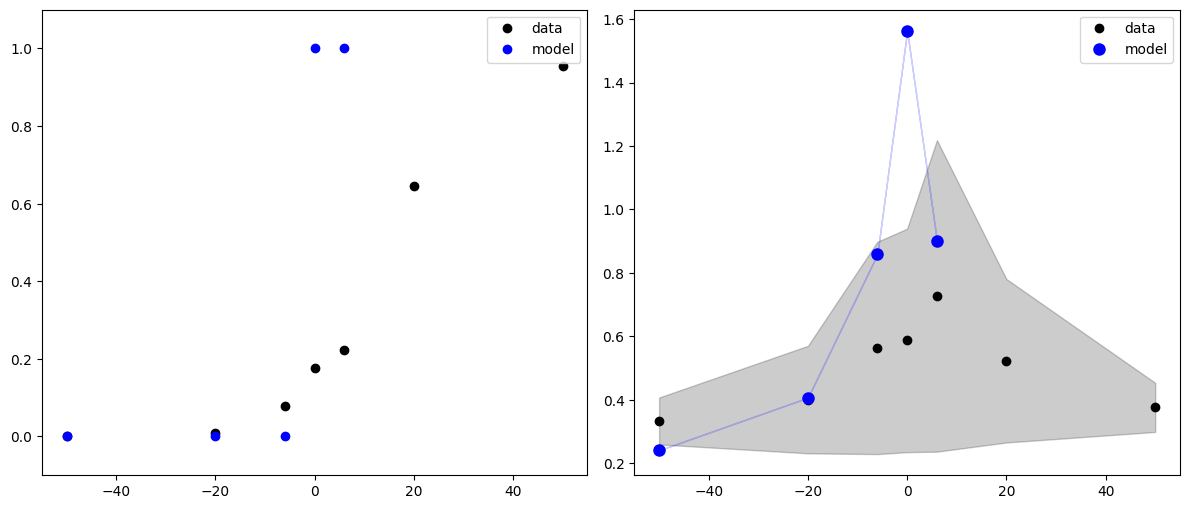

Proportion of invalid trials: 0.3243697478991597
Fitting session 210217_GP_JP

Session: 210217_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 399 trials
a (global): 2.7953
z (global): 0.7530
drift_offset (global): -1.1609
ndt (global): 0.2971
drift_gain (global): 10.0769
variance (global): 3.0575
leak_rate (global): 0.2169
time_constant (global): 0.0014

Simulation completed. Generated 399 trials.
Valid simulated trials: 399


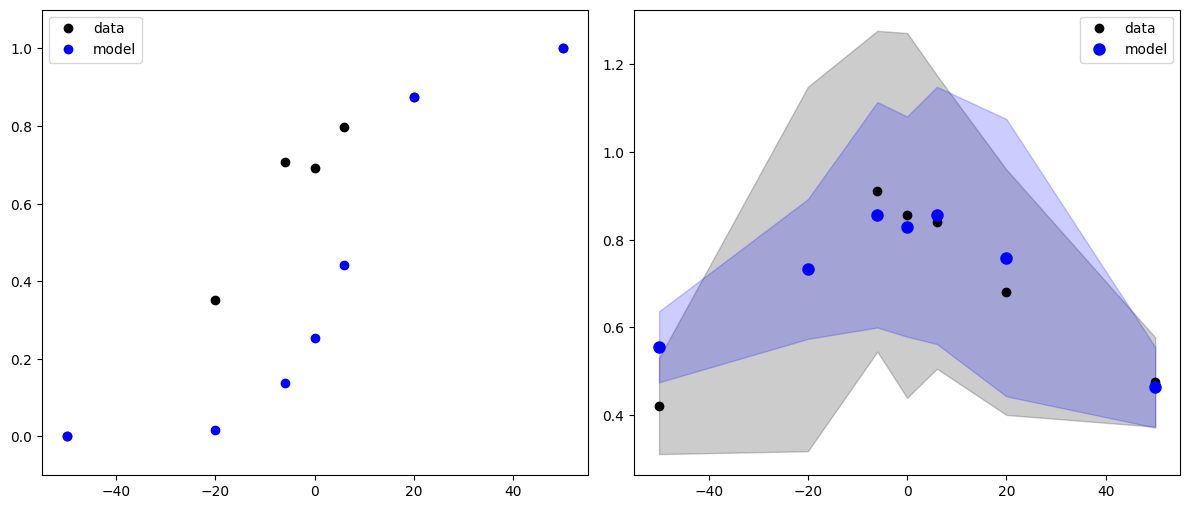

Proportion of invalid trials: 0.0

Session: 210217_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 593 trials
a (global): 2.1693
z (global): 0.8696
drift_offset (global): -0.1905
ndt (global): 0.1661
drift_gain (global): 4.4799
variance (global): 1.2503
leak_rate (global): 0.0920
time_constant (global): 0.0010

Simulation completed. Generated 593 trials.
Valid simulated trials: 593


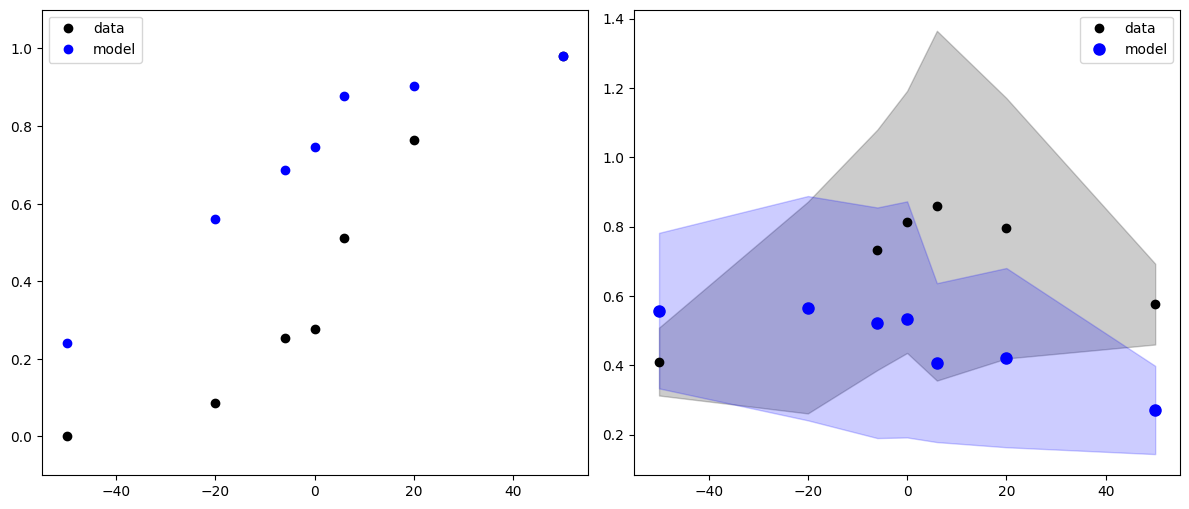

Proportion of invalid trials: 0.0
Fitting session 241130_GP_TZ

Session: 241130_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 496 trials
a (global): 2.1587
z (global): 0.5797
drift_offset (global): -0.0038
ndt (global): 0.1073
drift_gain (global): 2.0533
variance (global): 2.6450
leak_rate (global): 0.0615
time_constant (global): 0.0012

Simulation completed. Generated 496 trials.
Valid simulated trials: 495


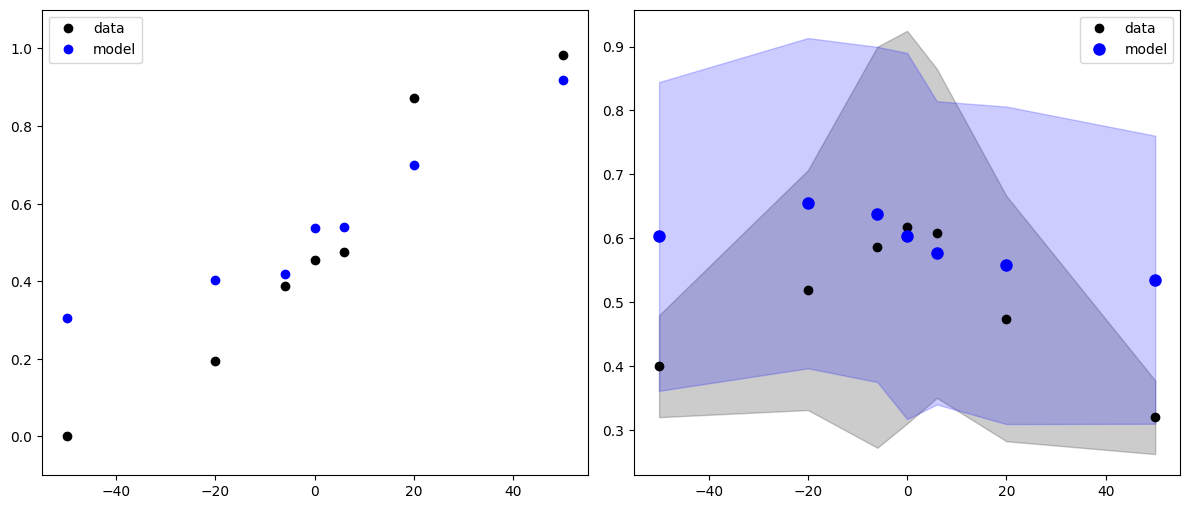

Proportion of invalid trials: 0.0020161290322580645

Session: 241130_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 719 trials
a (global): 0.8000
z (global): 0.9000
drift_offset (global): 0.0000
ndt (global): 0.1000
drift_gain (global): 1.0000
variance (global): 0.1000
leak_rate (global): 0.0000
time_constant (global): 0.0010

Simulation completed. Generated 719 trials.
Valid simulated trials: 412


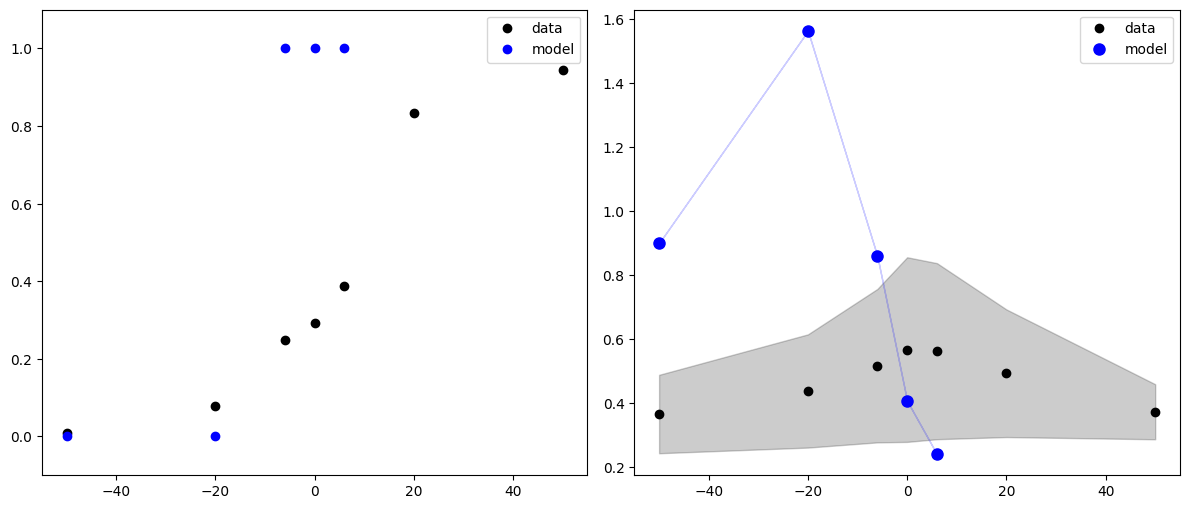

Proportion of invalid trials: 0.42698191933240615
Fitting session 210211_GP_JP

Session: 210211_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 349 trials
a (global): 3.0594
z (global): 0.2685
drift_offset (global): 0.7019
ndt (global): 0.1304
drift_gain (global): 5.6142
variance (global): 3.0594
leak_rate (global): 0.9685
time_constant (global): 0.0010

Simulation completed. Generated 349 trials.
Valid simulated trials: 349


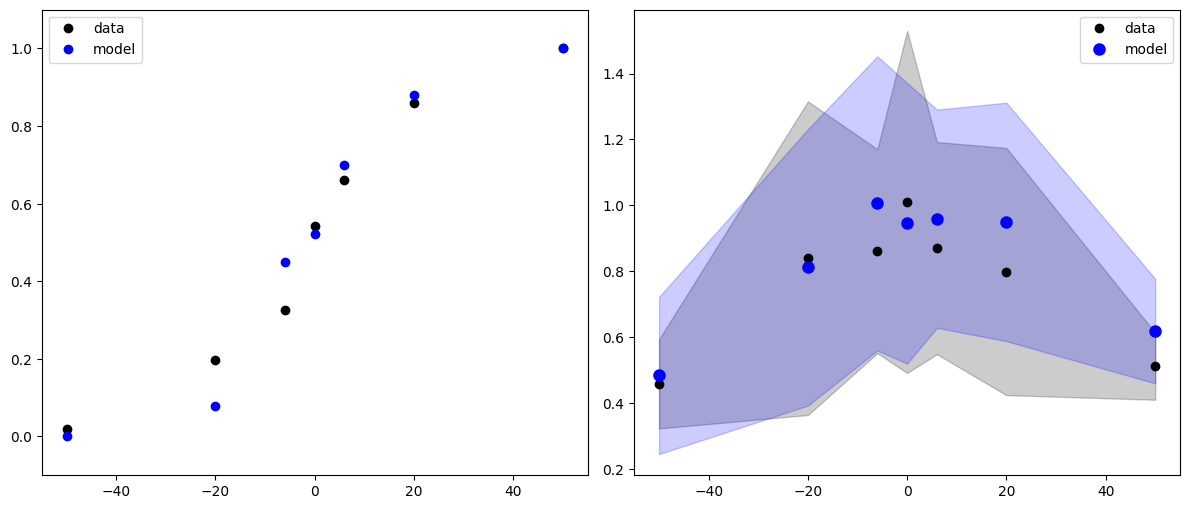

Proportion of invalid trials: 0.0

Session: 210211_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 594 trials
a (global): 2.6780
z (global): 0.3558
drift_offset (global): 0.4717
ndt (global): 0.1125
drift_gain (global): 5.5781
variance (global): 4.4526
leak_rate (global): 0.1068
time_constant (global): 0.0010

Simulation completed. Generated 594 trials.
Valid simulated trials: 594


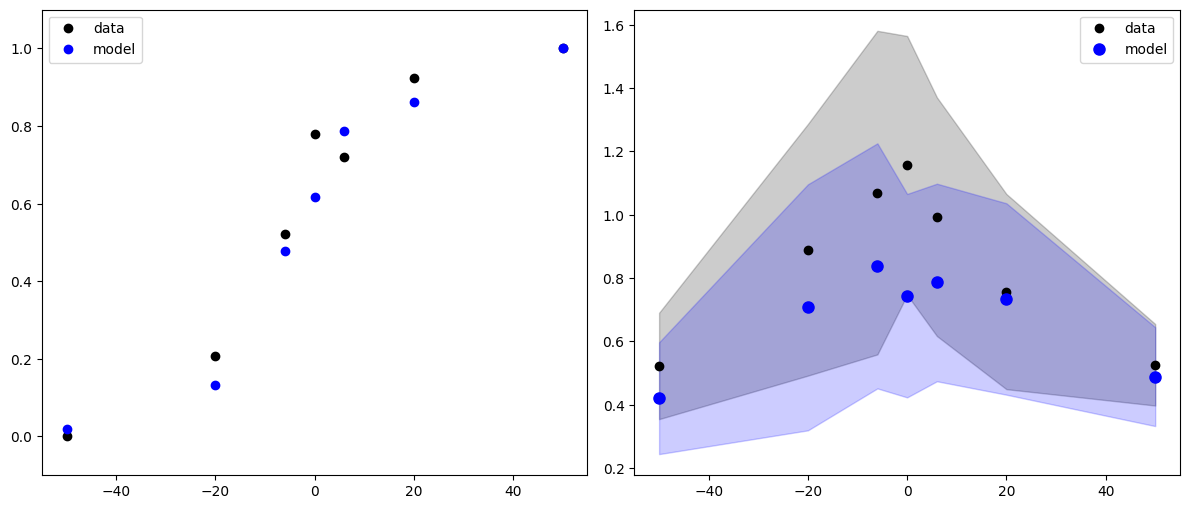

Proportion of invalid trials: 0.0
Fitting session 241002_GP_TZ

Session: 241002_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 494 trials
a (global): 5.6557
z (global): 0.1534
drift_offset (global): 0.0887
ndt (global): 0.1150
drift_gain (global): 5.1247
variance (global): 2.7893
leak_rate (global): 0.0287
time_constant (global): 0.0034

Simulation completed. Generated 494 trials.
Valid simulated trials: 494


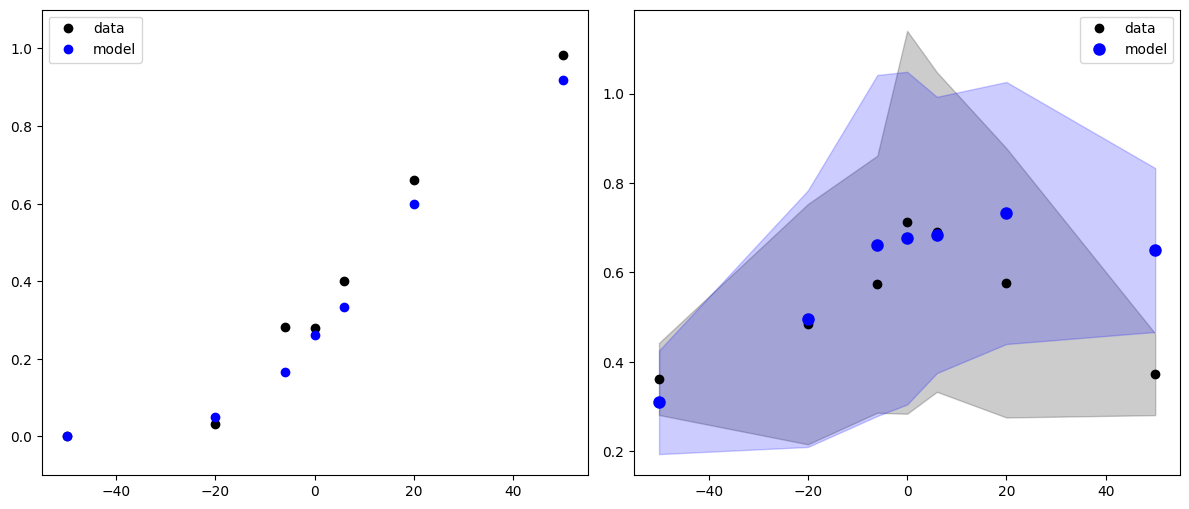

Proportion of invalid trials: 0.0

Session: 241002_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 677 trials
a (global): 4.2512
z (global): 0.2450
drift_offset (global): 0.2935
ndt (global): 0.2154
drift_gain (global): 2.1910
variance (global): 3.4217
leak_rate (global): 0.5149
time_constant (global): 0.0029

Simulation completed. Generated 677 trials.
Valid simulated trials: 675


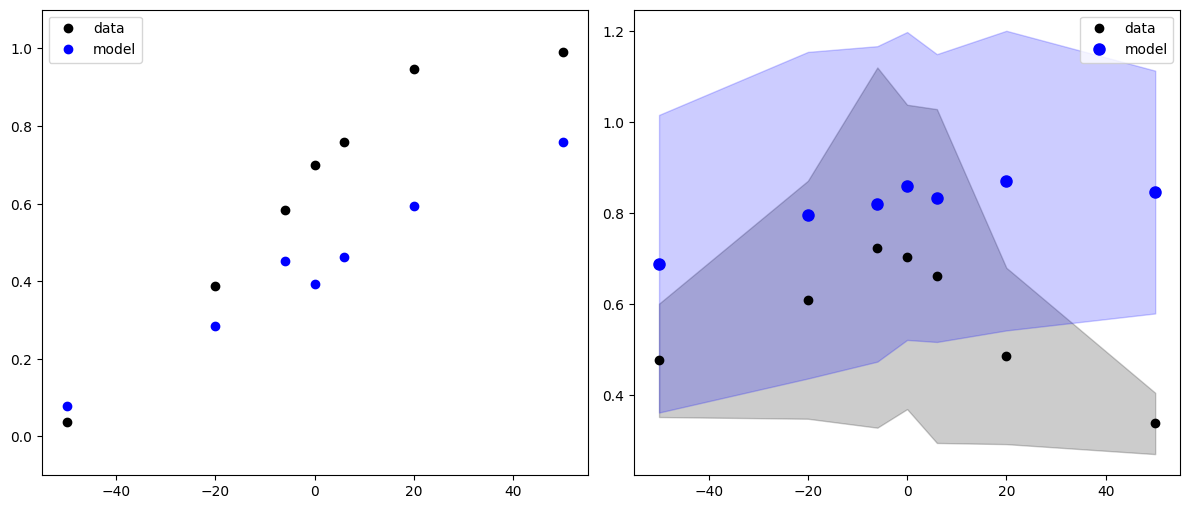

Proportion of invalid trials: 0.0029542097488921715
Fitting session 240805_GP_TZ

Session: 240805_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 457 trials
a (global): 2.0469
z (global): 0.6994
drift_offset (global): -0.7688
ndt (global): 0.1320
drift_gain (global): 14.5727
variance (global): 1.8312
leak_rate (global): 0.4170
time_constant (global): 0.0010

Simulation completed. Generated 457 trials.
Valid simulated trials: 457


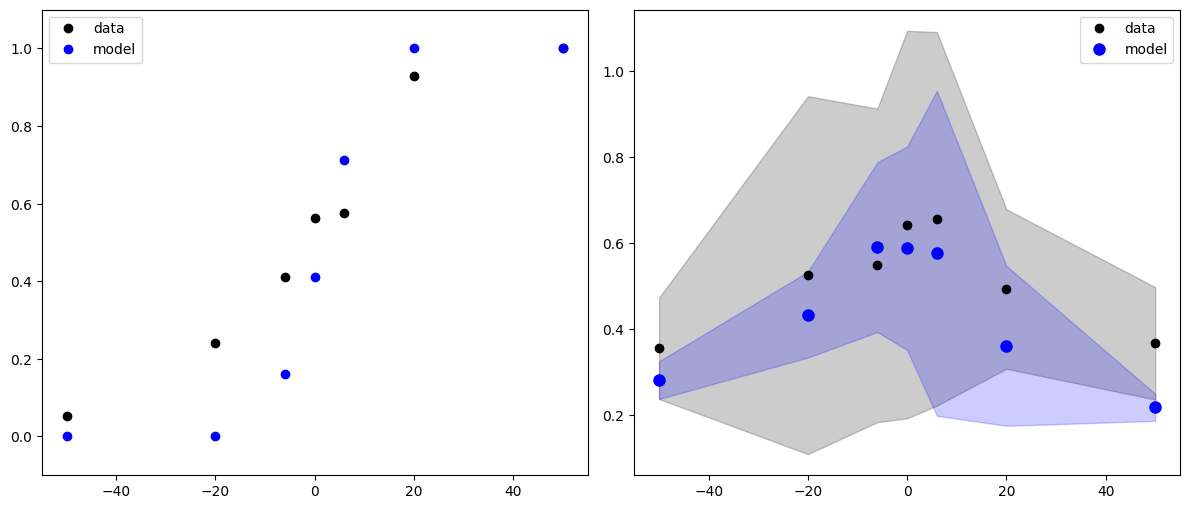

Proportion of invalid trials: 0.0

Session: 240805_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 679 trials
a (global): 3.4980
z (global): 0.4810
drift_offset (global): 0.1106
ndt (global): 0.1551
drift_gain (global): 6.9811
variance (global): 2.4135
leak_rate (global): 0.2497
time_constant (global): 0.0017

Simulation completed. Generated 679 trials.
Valid simulated trials: 679


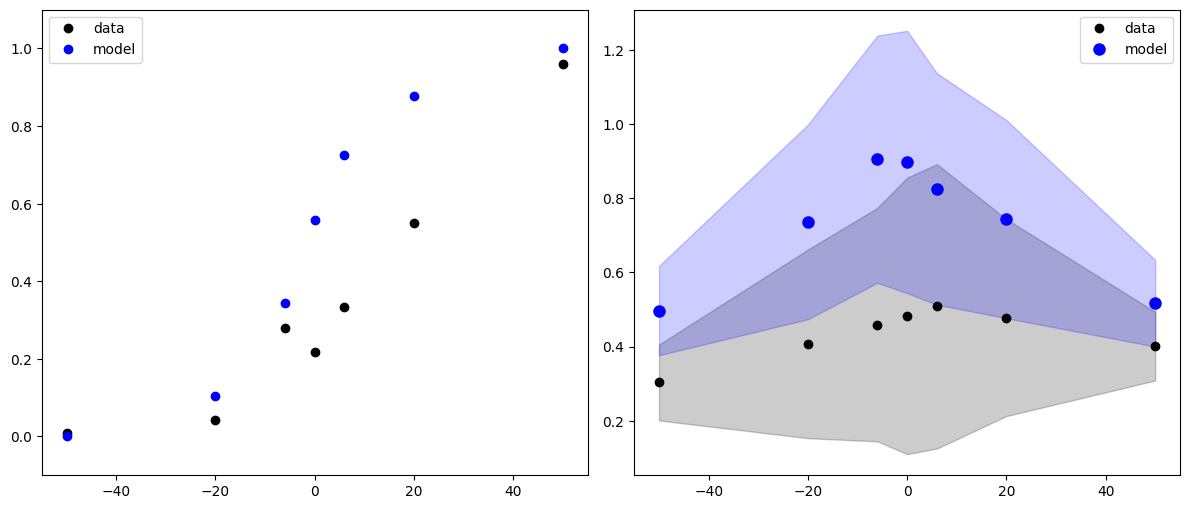

Proportion of invalid trials: 0.0
Fitting session 210323_GP_JP

Session: 210323_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 357 trials
a (global): 5.5219
z (global): 0.5970
drift_offset (global): -0.0766
ndt (global): 0.1055
drift_gain (global): 1.7990
variance (global): 0.4782
leak_rate (global): 0.5501
time_constant (global): 0.0041

Simulation completed. Generated 357 trials.
Valid simulated trials: 357


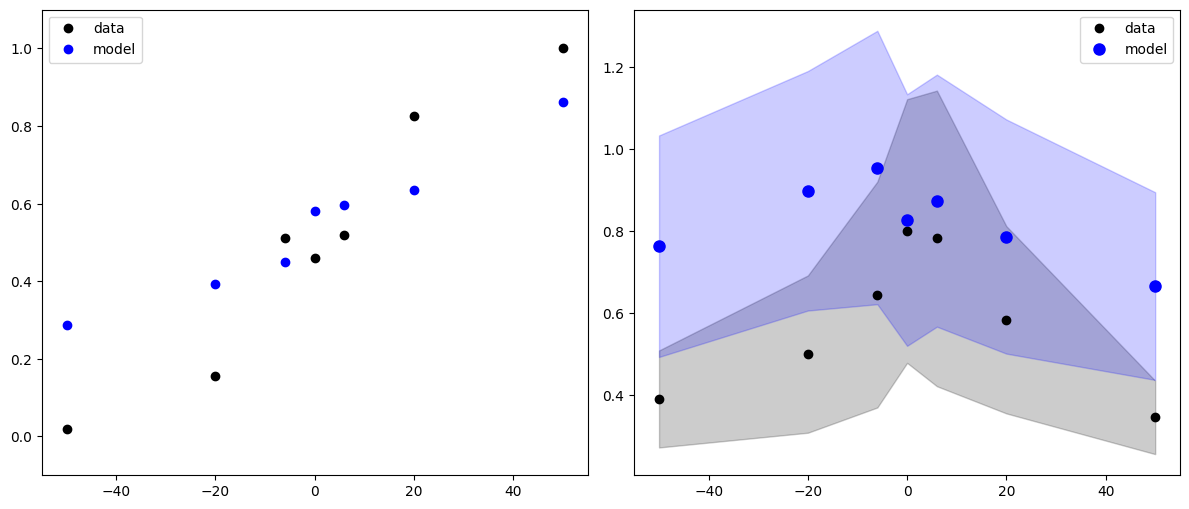

Proportion of invalid trials: 0.0

Session: 210323_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 695 trials
a (global): 2.6682
z (global): 0.4599
drift_offset (global): 1.1024
ndt (global): 0.1062
drift_gain (global): 15.4178
variance (global): 1.0846
leak_rate (global): 0.4126
time_constant (global): 0.0013

Simulation completed. Generated 695 trials.
Valid simulated trials: 695


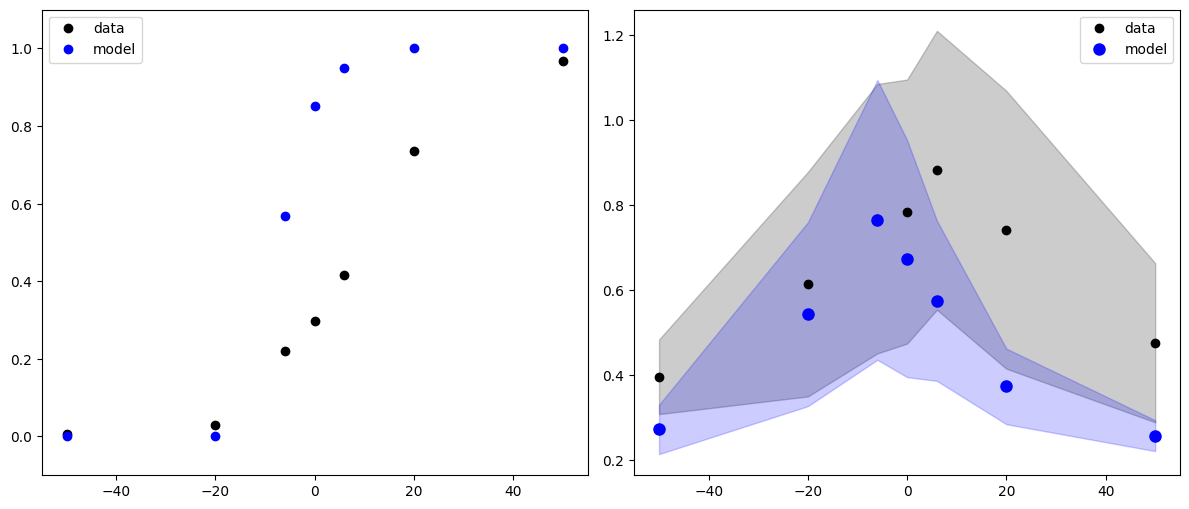

Proportion of invalid trials: 0.0
Fitting session 210708_GP_JP

Session: 210708_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 441 trials
a (global): 3.1931
z (global): 0.5515
drift_offset (global): -0.1783
ndt (global): 0.3582
drift_gain (global): 9.0439
variance (global): 0.2365
leak_rate (global): 0.2677
time_constant (global): 0.0015

Simulation completed. Generated 441 trials.
Valid simulated trials: 440


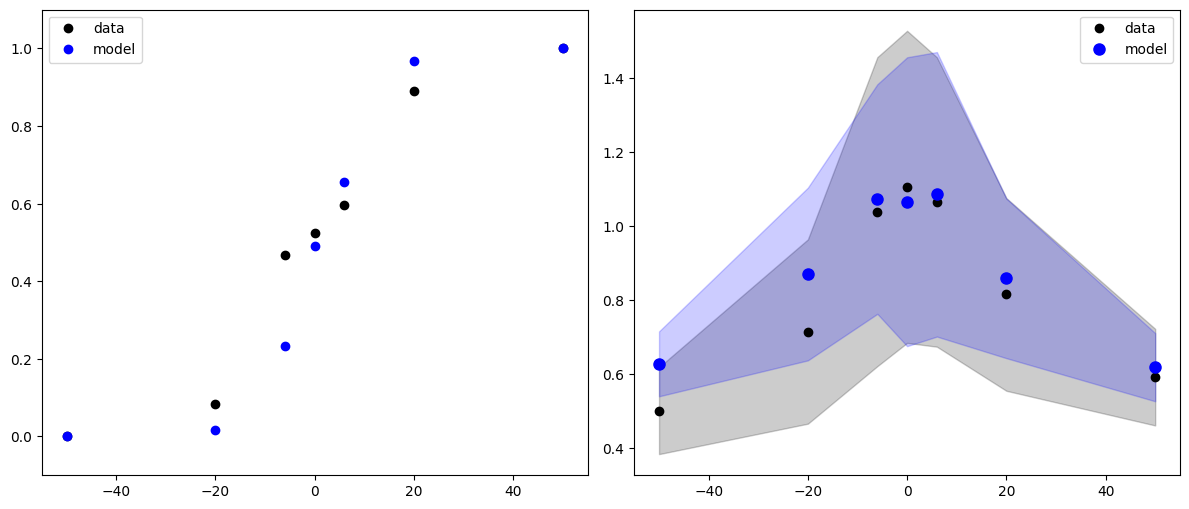

Proportion of invalid trials: 0.0022675736961451248

Session: 210708_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 321 trials
a (global): 2.0074
z (global): 0.6877
drift_offset (global): 0.3617
ndt (global): 0.1633
drift_gain (global): 14.7632
variance (global): 4.7905
leak_rate (global): 0.9508
time_constant (global): 0.0012

Simulation completed. Generated 321 trials.
Valid simulated trials: 321


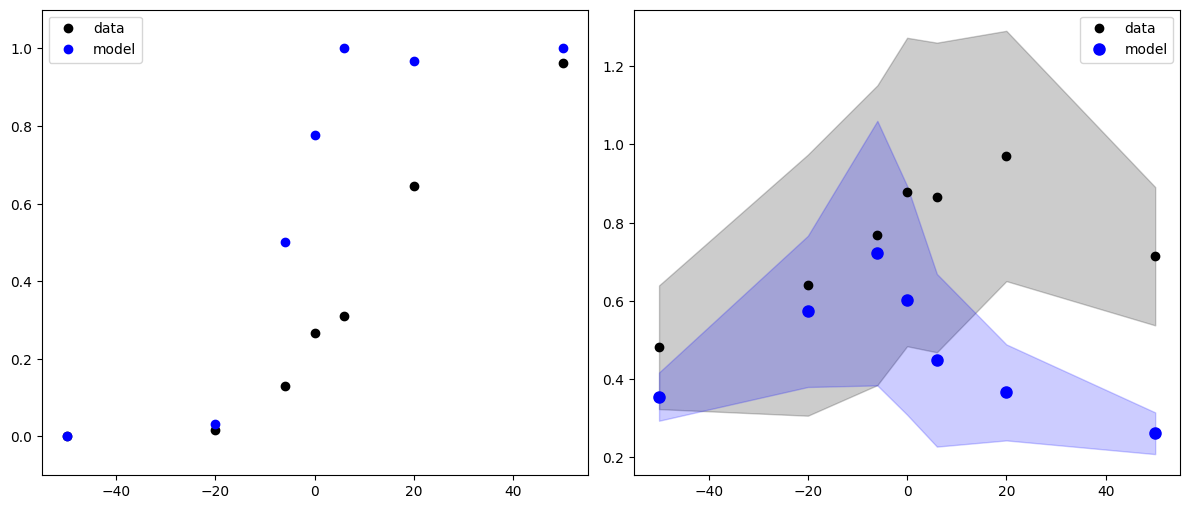

Proportion of invalid trials: 0.0
Fitting session 240710_GP_TZ

Session: 240710_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 519 trials
a (global): 2.8621
z (global): 0.3255
drift_offset (global): -0.0064
ndt (global): 0.1556
drift_gain (global): 6.2922
variance (global): 2.5678
leak_rate (global): 0.6818
time_constant (global): 0.0014

Simulation completed. Generated 519 trials.
Valid simulated trials: 518


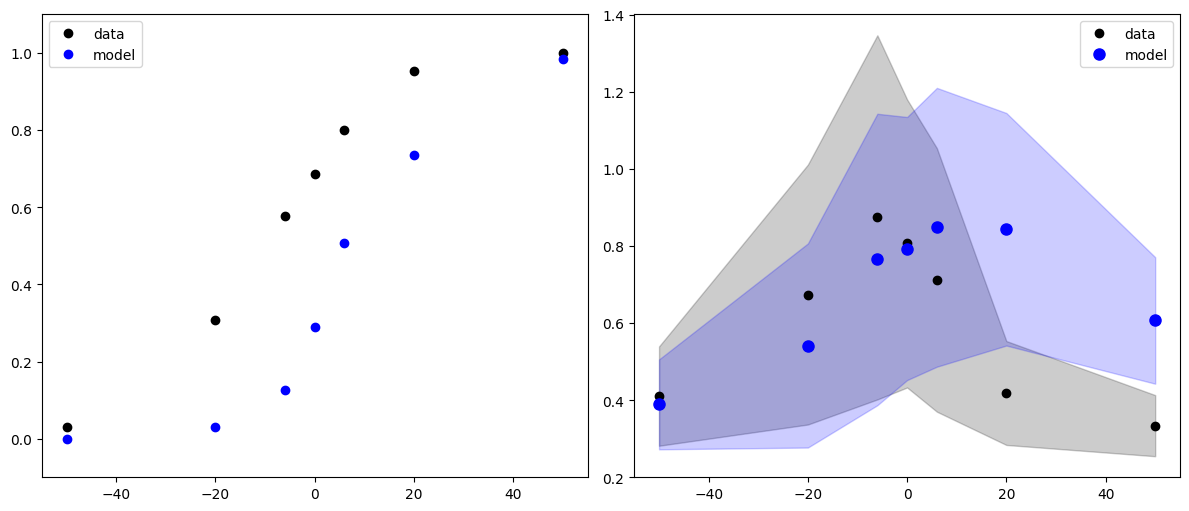

Proportion of invalid trials: 0.0019267822736030828

Session: 240710_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 756 trials
a (global): 0.8000
z (global): 0.1000
drift_offset (global): -0.0000
ndt (global): 0.1000
drift_gain (global): 1.0000
variance (global): 0.1000
leak_rate (global): 0.0000
time_constant (global): 0.0010

Simulation completed. Generated 756 trials.
Valid simulated trials: 511


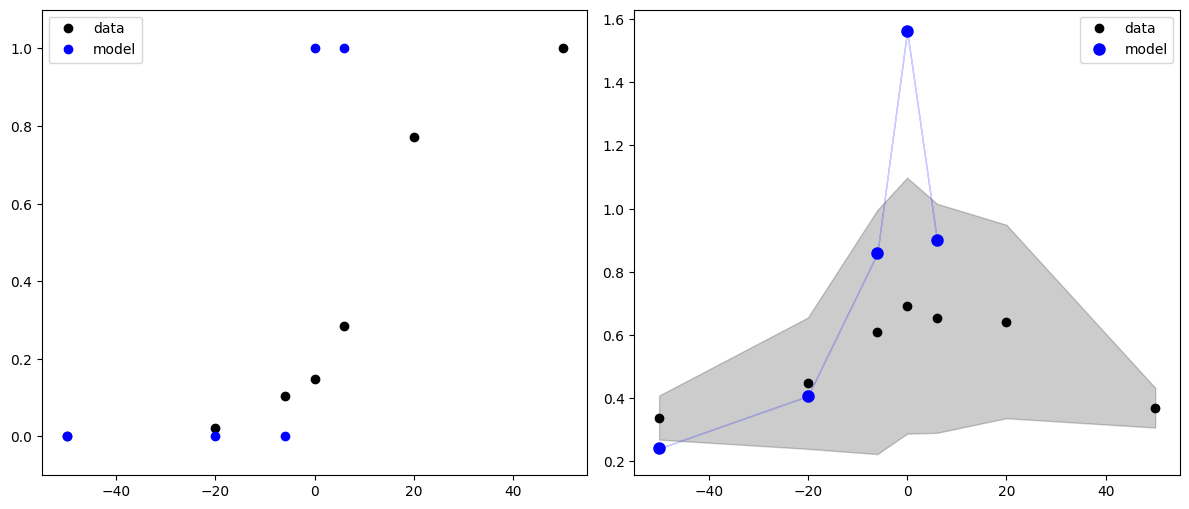

Proportion of invalid trials: 0.32407407407407407
Fitting session 241223_GP_TZ

Session: 241223_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 521 trials
a (global): 3.8031
z (global): 0.4940
drift_offset (global): -0.4144
ndt (global): 0.1269
drift_gain (global): 5.6704
variance (global): 0.7974
leak_rate (global): 0.1188
time_constant (global): 0.0013

Simulation completed. Generated 521 trials.
Valid simulated trials: 521


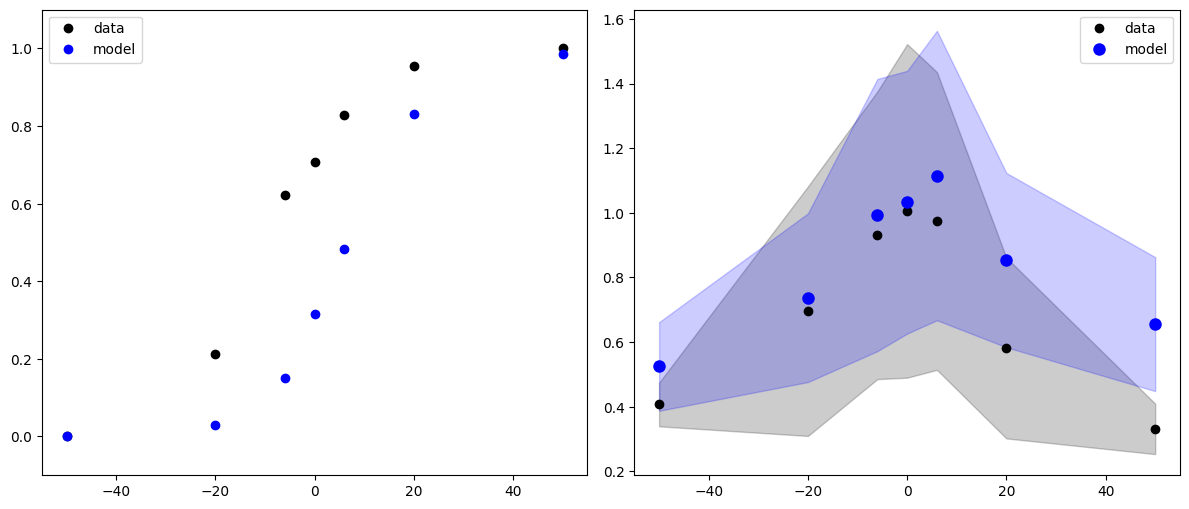

Proportion of invalid trials: 0.0

Session: 241223_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 706 trials
a (global): 2.8965
z (global): 0.2881
drift_offset (global): 0.6446
ndt (global): 0.1414
drift_gain (global): 19.5558
variance (global): 3.5666
leak_rate (global): 0.7515
time_constant (global): 0.0013

Simulation completed. Generated 706 trials.
Valid simulated trials: 706


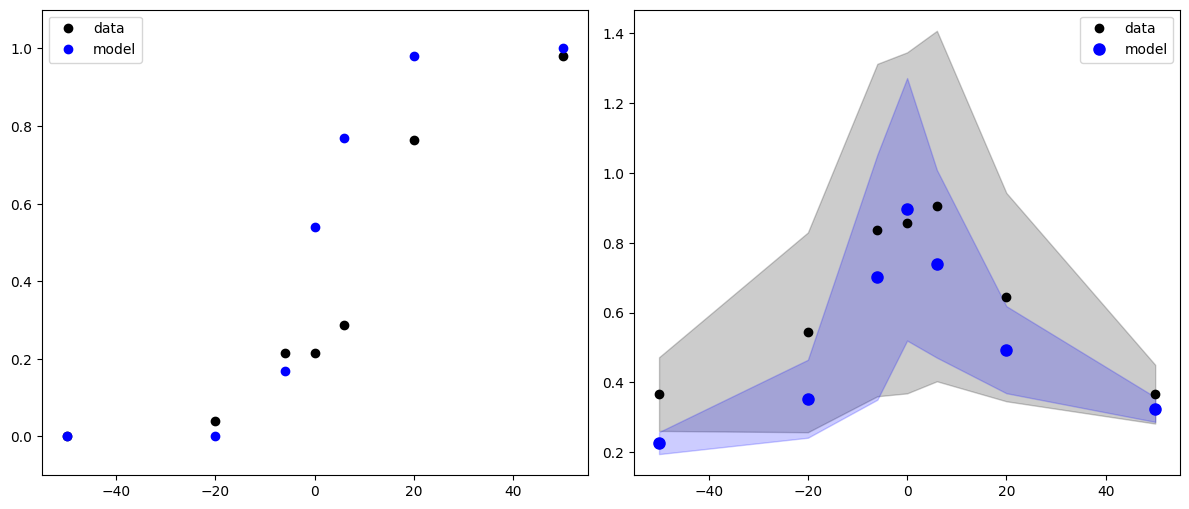

Proportion of invalid trials: 0.0
Fitting session 240809_GP_TZ

Session: 240809_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 507 trials
a (global): 2.4212
z (global): 0.4037
drift_offset (global): 0.0419
ndt (global): 0.1047
drift_gain (global): 19.0594
variance (global): 1.0053
leak_rate (global): 0.1989
time_constant (global): 0.0014

Simulation completed. Generated 507 trials.
Valid simulated trials: 507


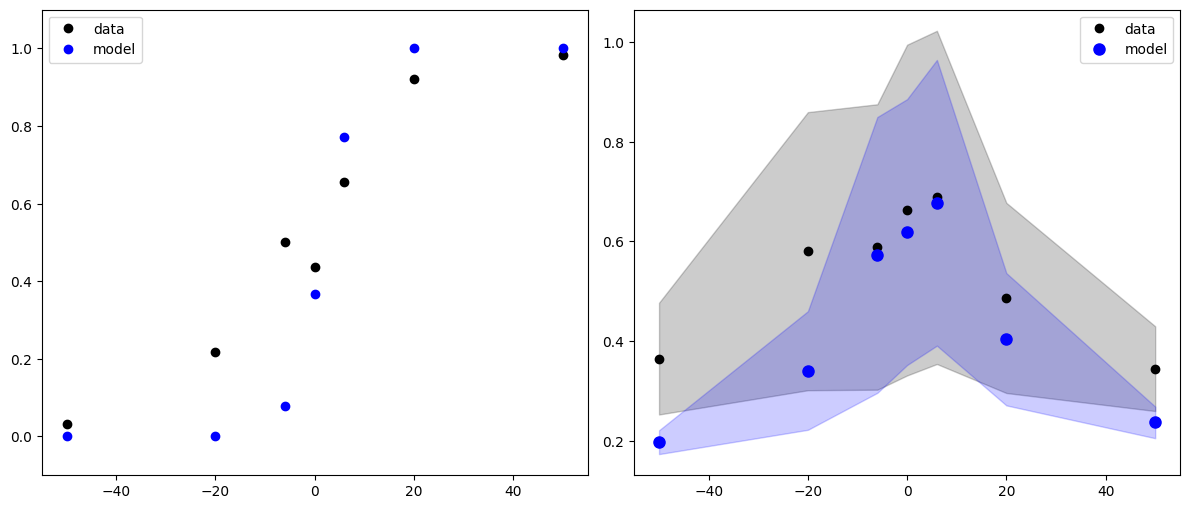

Proportion of invalid trials: 0.0

Session: 240809_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 701 trials
a (global): 2.7348
z (global): 0.4993
drift_offset (global): 0.8053
ndt (global): 0.1090
drift_gain (global): 13.0806
variance (global): 4.6853
leak_rate (global): 0.9513
time_constant (global): 0.0017

Simulation completed. Generated 701 trials.
Valid simulated trials: 701


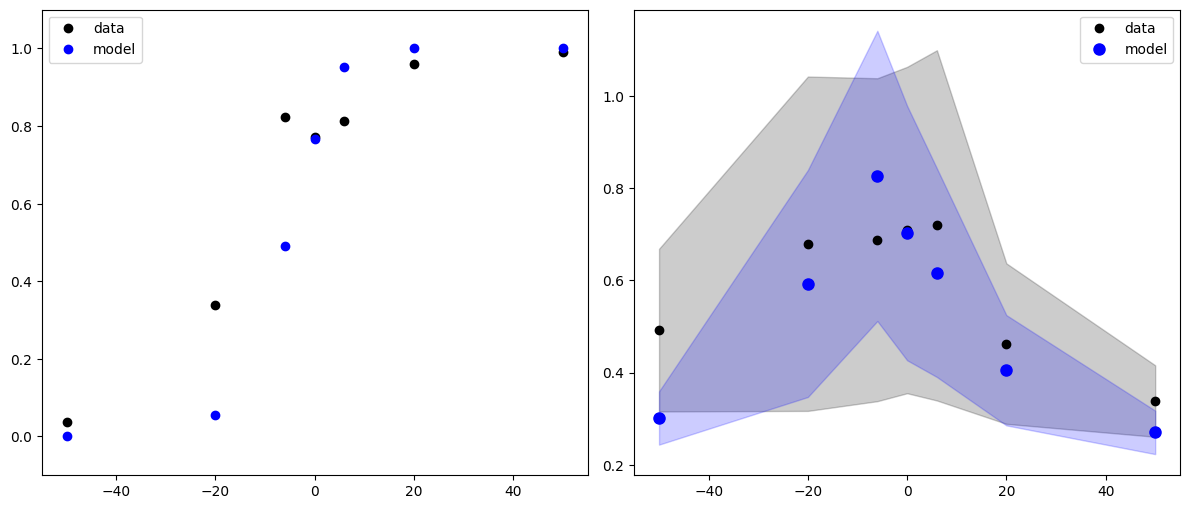

Proportion of invalid trials: 0.0
Fitting session 210205_GP_JP

Session: 210205_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 347 trials
a (global): 3.0240
z (global): 0.6880
drift_offset (global): -0.4939
ndt (global): 0.1243
drift_gain (global): 2.0998
variance (global): 2.7339
leak_rate (global): 0.8640
time_constant (global): 0.0010

Simulation completed. Generated 347 trials.
Valid simulated trials: 347


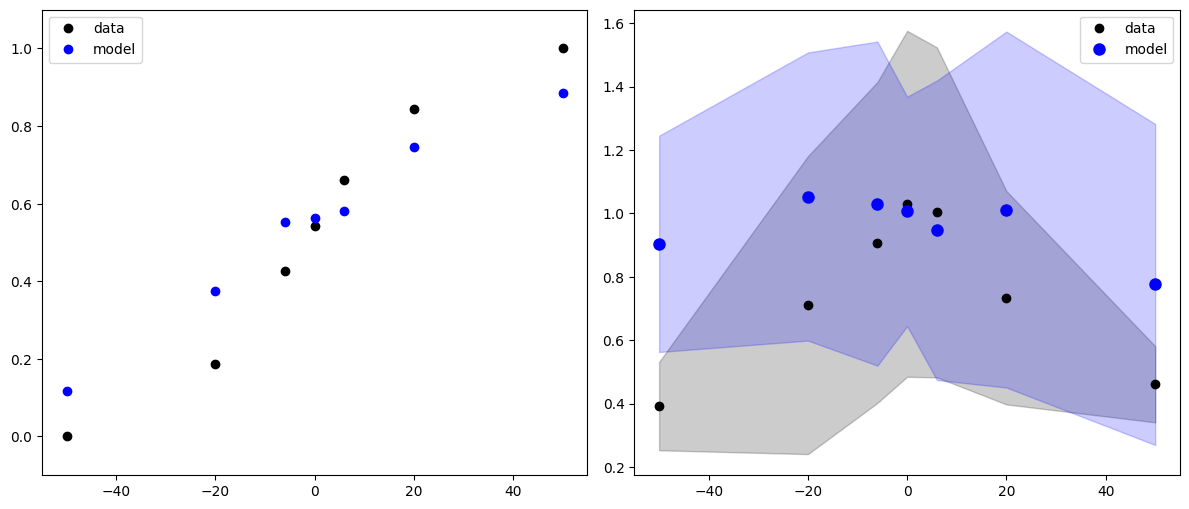

Proportion of invalid trials: 0.0

Session: 210205_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 618 trials
a (global): 3.1132
z (global): 0.6784
drift_offset (global): -0.2502
ndt (global): 0.1775
drift_gain (global): 9.3715
variance (global): 2.1807
leak_rate (global): 0.3286
time_constant (global): 0.0013

Simulation completed. Generated 618 trials.
Valid simulated trials: 618


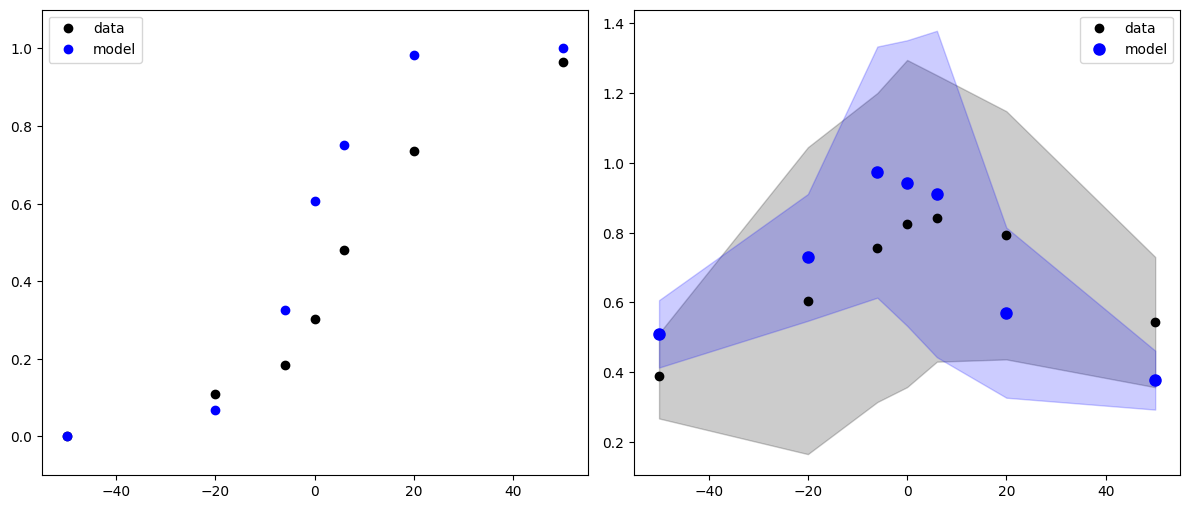

Proportion of invalid trials: 0.0
Fitting session 210525_GP_JP

Session: 210525_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 387 trials
a (global): 5.0837
z (global): 0.4795
drift_offset (global): -0.1708
ndt (global): 0.1465
drift_gain (global): 3.8332
variance (global): 0.1881
leak_rate (global): 0.7386
time_constant (global): 0.0036

Simulation completed. Generated 387 trials.
Valid simulated trials: 387


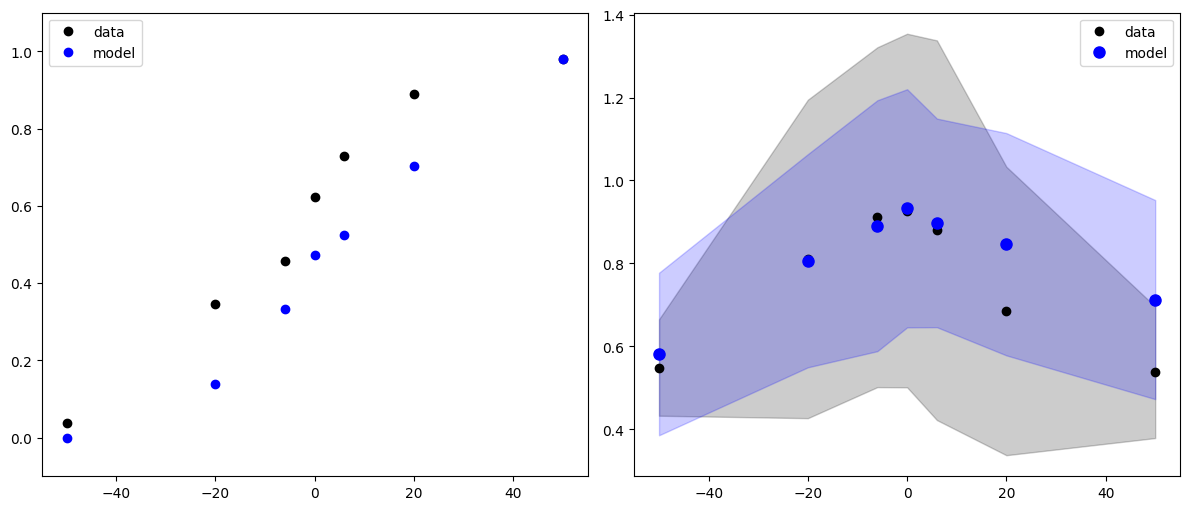

Proportion of invalid trials: 0.0

Session: 210525_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 672 trials
a (global): 2.6818
z (global): 0.4529
drift_offset (global): 0.6561
ndt (global): 0.1169
drift_gain (global): 2.0054
variance (global): 4.6203
leak_rate (global): 0.2484
time_constant (global): 0.0014

Simulation completed. Generated 672 trials.
Valid simulated trials: 672


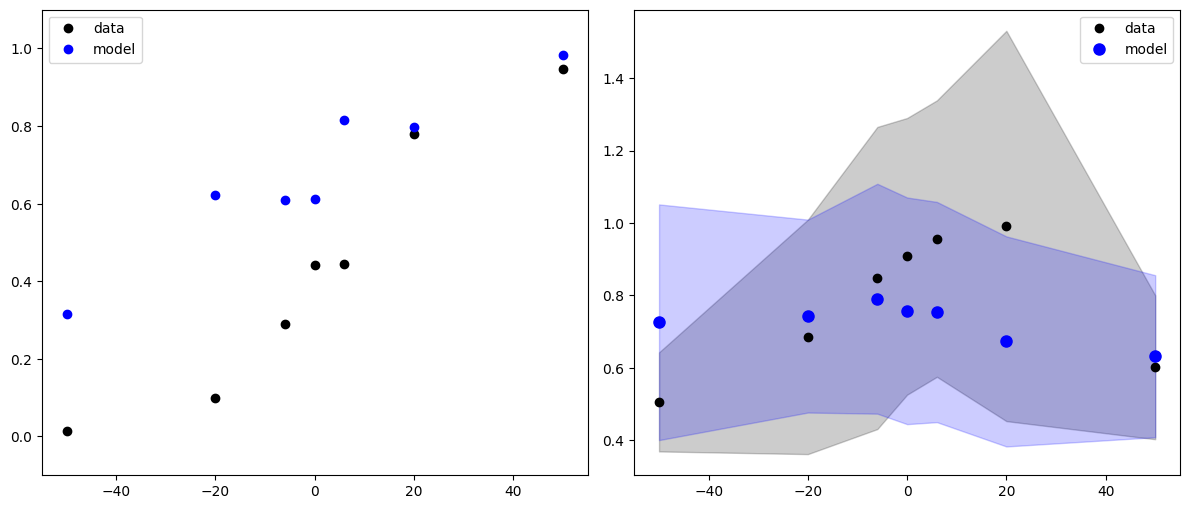

Proportion of invalid trials: 0.0
Fitting session 241227_GP_TZ

Session: 241227_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 511 trials
a (global): 3.5453
z (global): 0.5127
drift_offset (global): -0.4677
ndt (global): 0.1280
drift_gain (global): 15.6109
variance (global): 4.5964
leak_rate (global): 0.4783
time_constant (global): 0.0012

Simulation completed. Generated 511 trials.
Valid simulated trials: 510


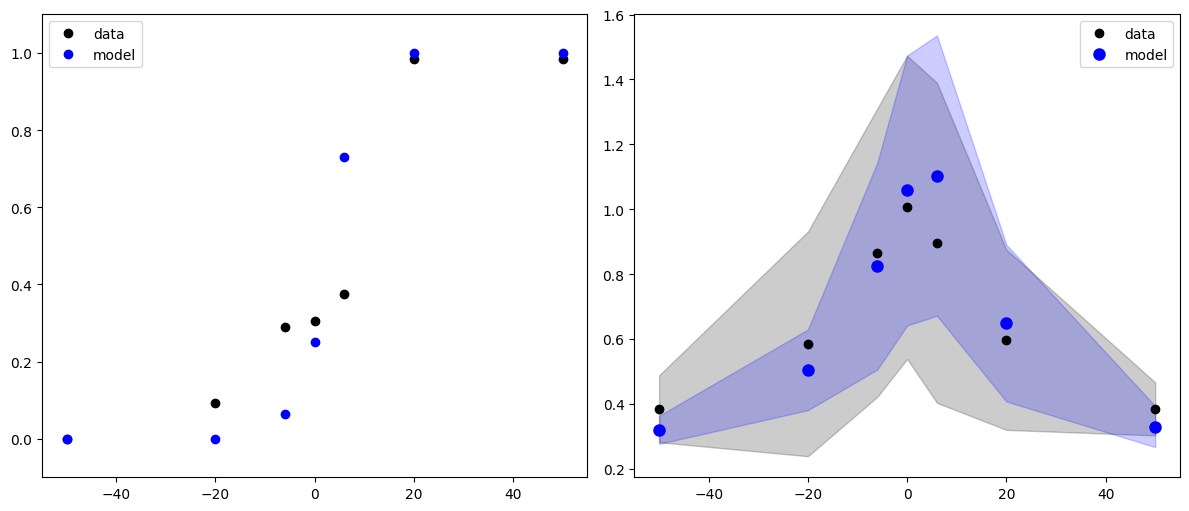

Proportion of invalid trials: 0.0019569471624266144

Session: 241227_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 653 trials
a (global): 0.8000
z (global): 0.1000
drift_offset (global): 0.0000
ndt (global): 0.1000
drift_gain (global): 1.0000
variance (global): 0.1000
leak_rate (global): 0.0000
time_constant (global): 0.0010

Simulation completed. Generated 653 trials.
Valid simulated trials: 382


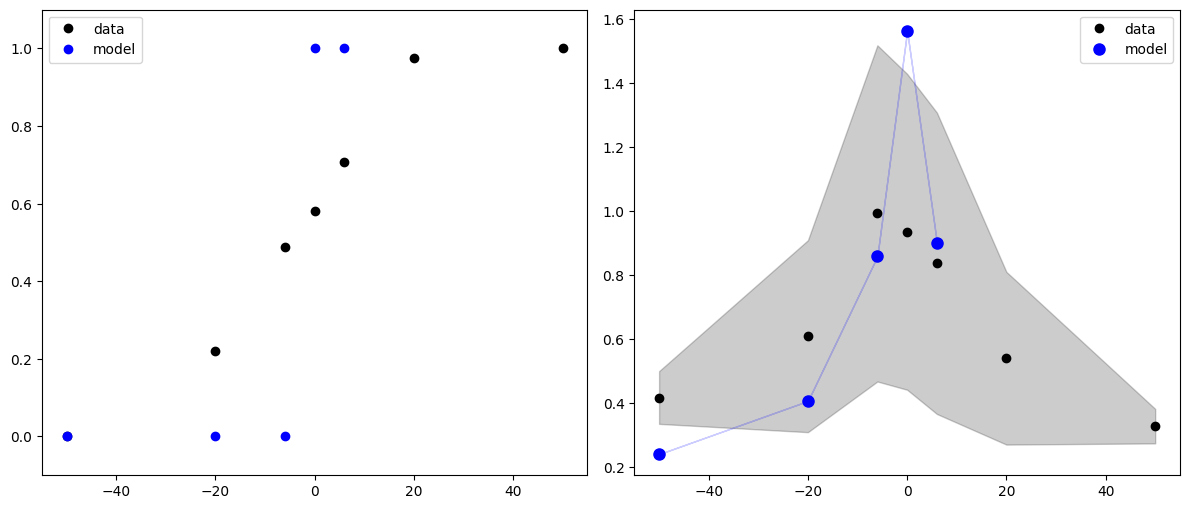

Proportion of invalid trials: 0.41500765696784075
Fitting session 240627_GP_TZ

Session: 240627_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 499 trials
a (global): 3.3023
z (global): 0.3850
drift_offset (global): 0.2062
ndt (global): 0.1046
drift_gain (global): 3.9050
variance (global): 2.7335
leak_rate (global): 0.2468
time_constant (global): 0.0010

Simulation completed. Generated 499 trials.
Valid simulated trials: 494


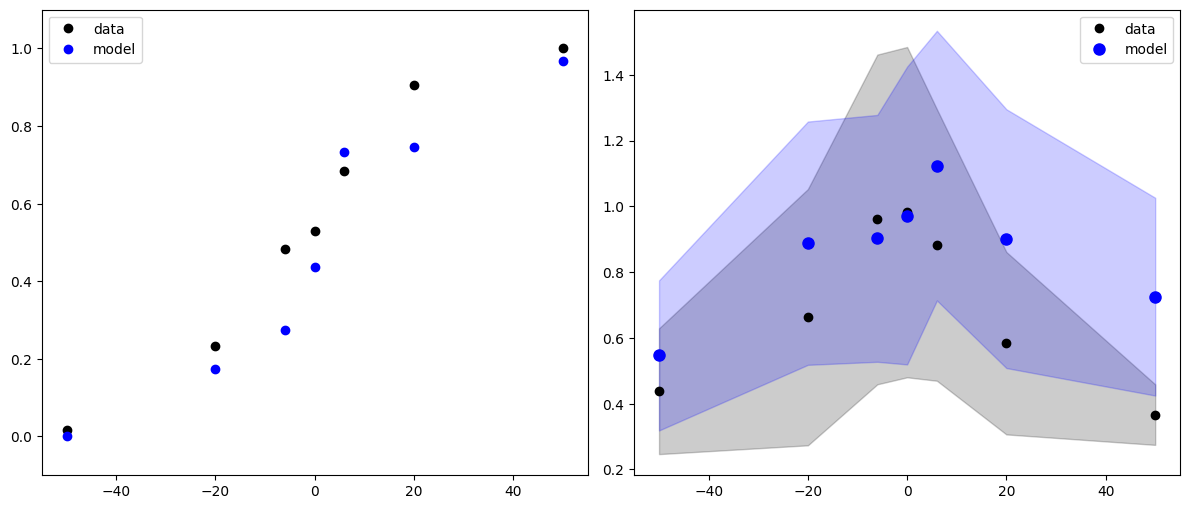

Proportion of invalid trials: 0.01002004008016032

Session: 240627_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 691 trials
a (global): 4.7598
z (global): 0.5732
drift_offset (global): -0.0669
ndt (global): 0.1080
drift_gain (global): 11.8871
variance (global): 0.3834
leak_rate (global): 0.4800
time_constant (global): 0.0028

Simulation completed. Generated 691 trials.
Valid simulated trials: 691


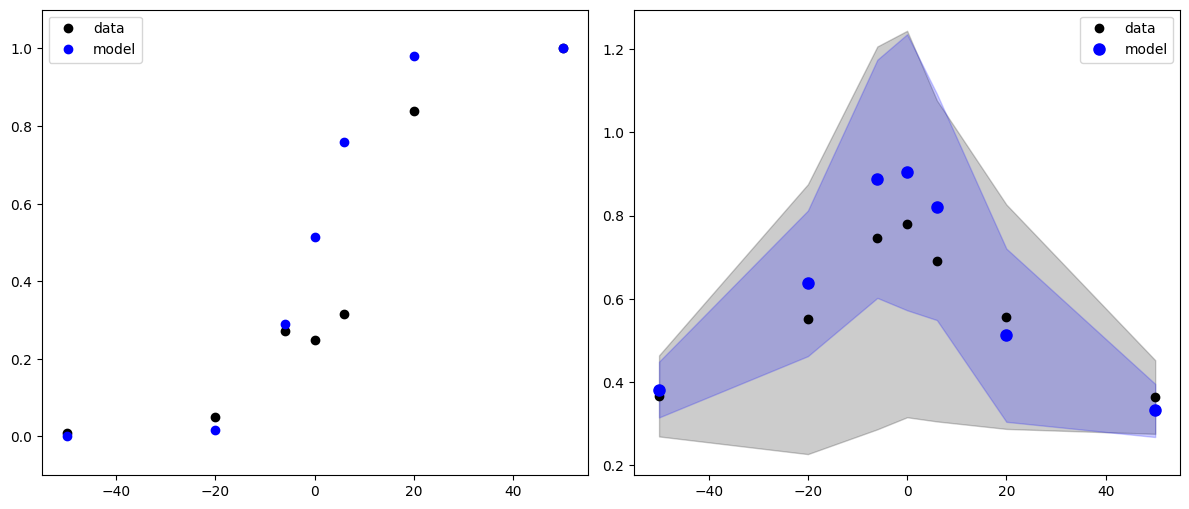

Proportion of invalid trials: 0.0
Fitting session 240625_GP_TZ

Session: 240625_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 511 trials
a (global): 2.3248
z (global): 0.1944
drift_offset (global): 0.3869
ndt (global): 0.1188
drift_gain (global): 2.4568
variance (global): 1.3631
leak_rate (global): 0.5352
time_constant (global): 0.0016

Simulation completed. Generated 511 trials.
Valid simulated trials: 511


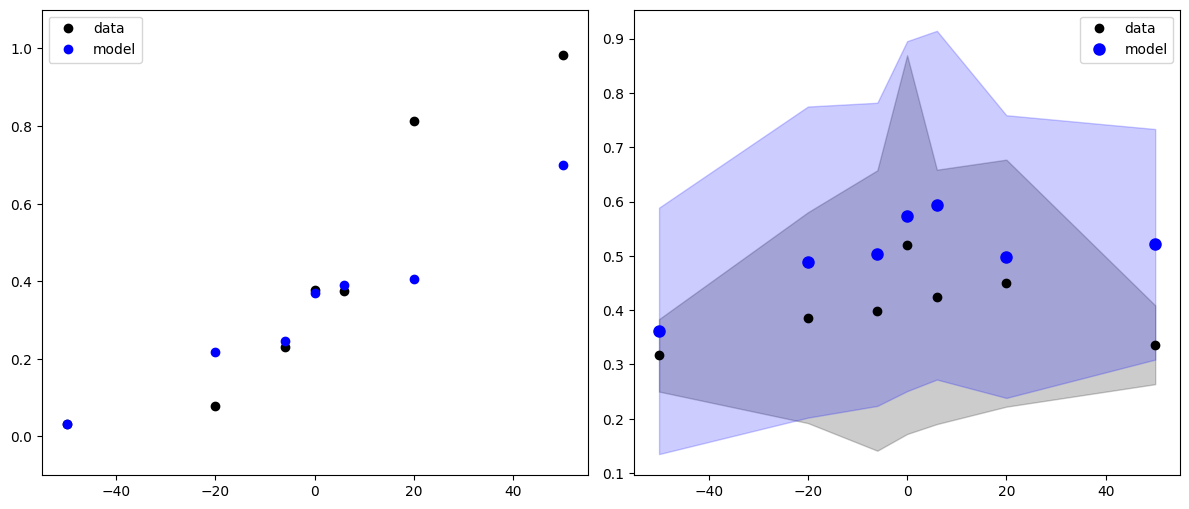

Proportion of invalid trials: 0.0

Session: 240625_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 727 trials
a (global): 3.0062
z (global): 0.4262
drift_offset (global): 0.7376
ndt (global): 0.1037
drift_gain (global): 12.1430
variance (global): 1.7229
leak_rate (global): 0.4936
time_constant (global): 0.0011

Simulation completed. Generated 727 trials.
Valid simulated trials: 717


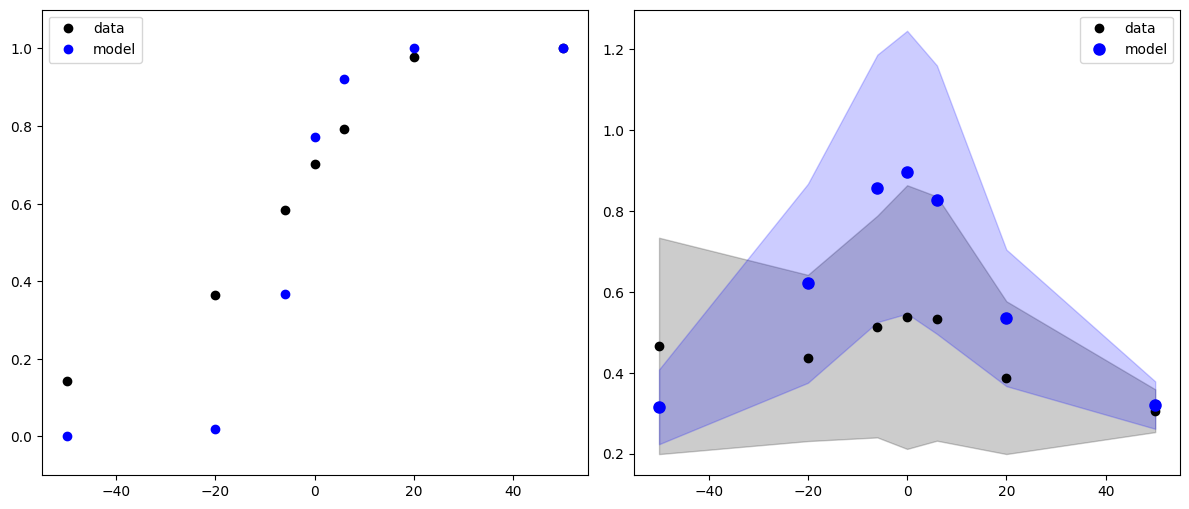

Proportion of invalid trials: 0.013755158184319119
Fitting session 240814_GP_TZ

Session: 240814_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 522 trials
a (global): 2.5931
z (global): 0.6011
drift_offset (global): 0.5975
ndt (global): 0.1203
drift_gain (global): 5.8628
variance (global): 1.8107
leak_rate (global): 0.4090
time_constant (global): 0.0011

Simulation completed. Generated 522 trials.
Valid simulated trials: 522


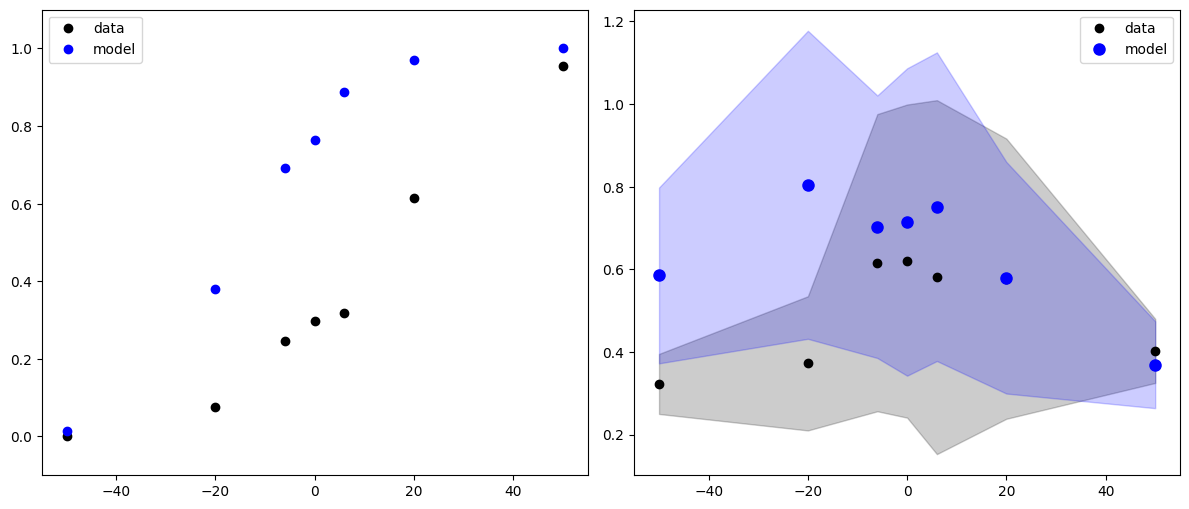

Proportion of invalid trials: 0.0

Session: 240814_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 450 trials
a (global): 3.4731
z (global): 0.5125
drift_offset (global): 0.3398
ndt (global): 0.1504
drift_gain (global): 1.5366
variance (global): 0.2648
leak_rate (global): 0.5088
time_constant (global): 0.0034

Simulation completed. Generated 450 trials.
Valid simulated trials: 450


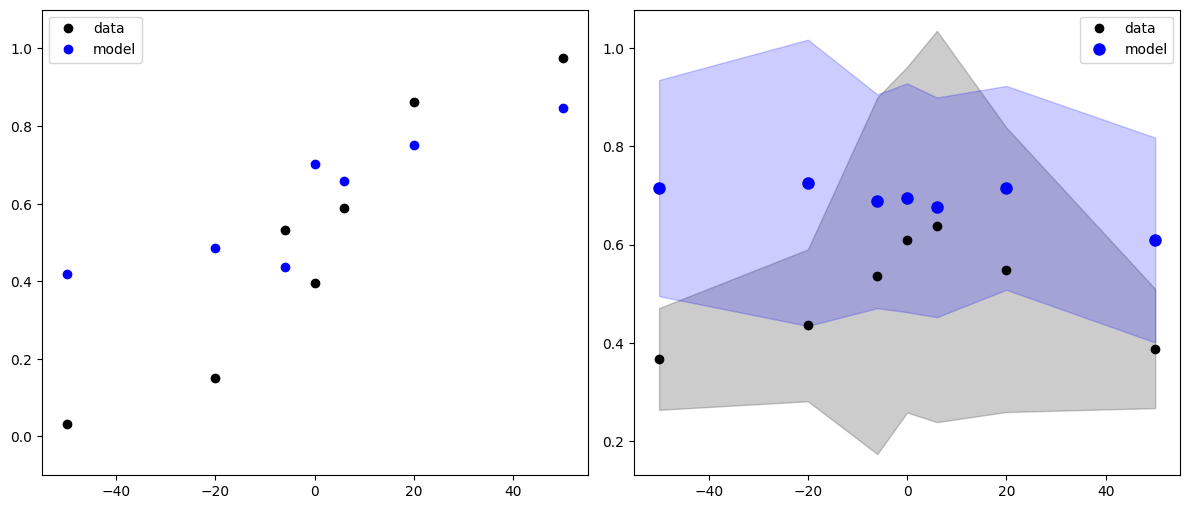

Proportion of invalid trials: 0.0
Fitting session 210210_GP_JP

Session: 210210_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 334 trials
a (global): 2.0720
z (global): 0.2572
drift_offset (global): 0.0465
ndt (global): 0.1856
drift_gain (global): 9.5771
variance (global): 1.3034
leak_rate (global): 0.9446
time_constant (global): 0.0012

Simulation completed. Generated 334 trials.
Valid simulated trials: 334


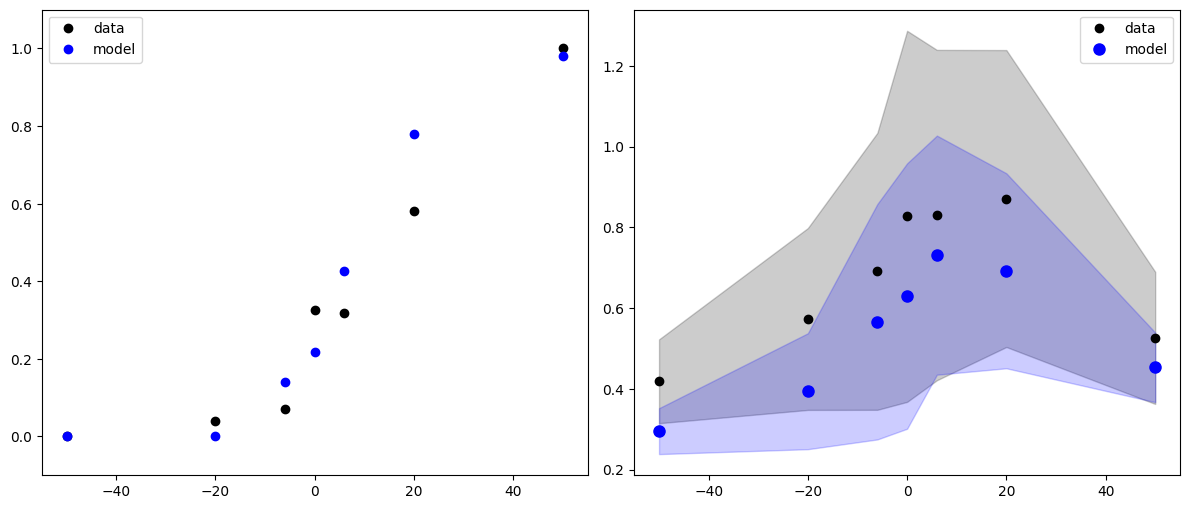

Proportion of invalid trials: 0.0

Session: 210210_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 589 trials
a (global): 3.6749
z (global): 0.6701
drift_offset (global): -0.1516
ndt (global): 0.1566
drift_gain (global): 8.8854
variance (global): 1.6162
leak_rate (global): 0.7755
time_constant (global): 0.0018

Simulation completed. Generated 589 trials.
Valid simulated trials: 589


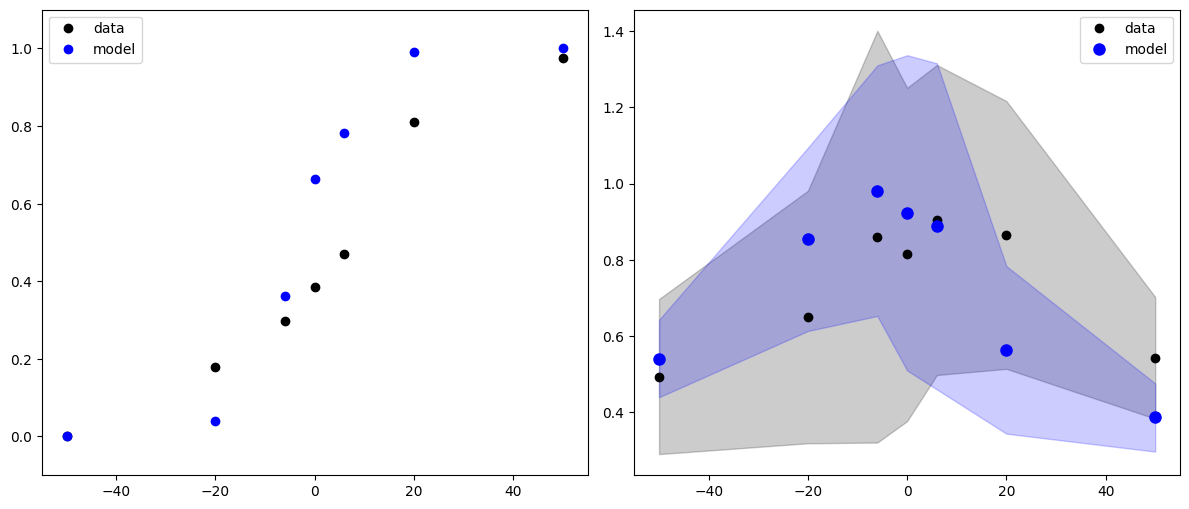

Proportion of invalid trials: 0.0
Fitting session 241230_GP_TZ

Session: 241230_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 499 trials
a (global): 3.4175
z (global): 0.2960
drift_offset (global): -0.0530
ndt (global): 0.1485
drift_gain (global): 1.4661
variance (global): 1.9788
leak_rate (global): 0.1763
time_constant (global): 0.0016

Simulation completed. Generated 499 trials.
Valid simulated trials: 499


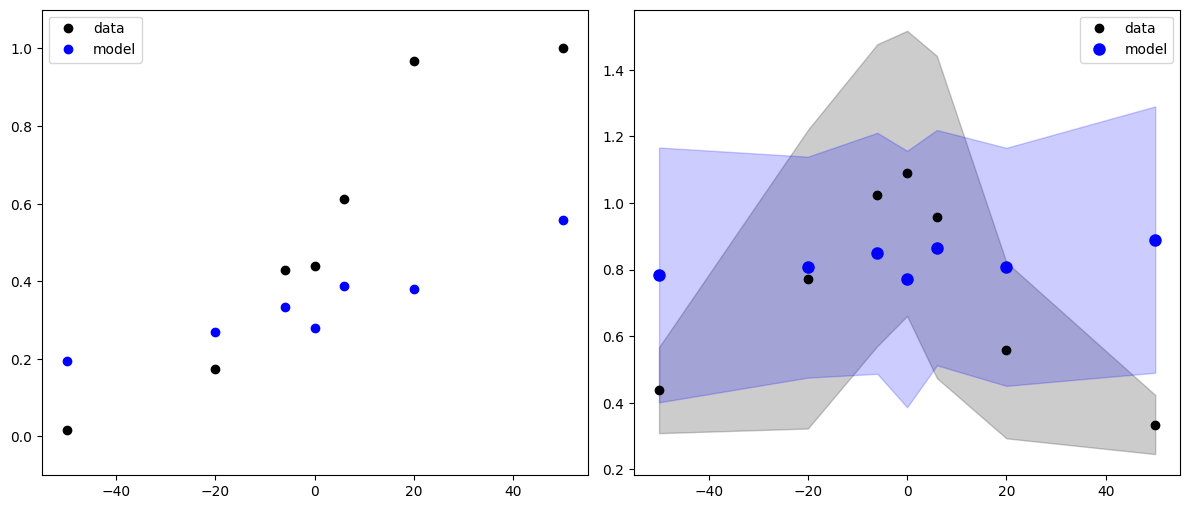

Proportion of invalid trials: 0.0

Session: 241230_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 647 trials
a (global): 5.4962
z (global): 0.7275
drift_offset (global): -0.4803
ndt (global): 0.1445
drift_gain (global): 5.2837
variance (global): 1.2773
leak_rate (global): 0.4834
time_constant (global): 0.0049

Simulation completed. Generated 647 trials.
Valid simulated trials: 647


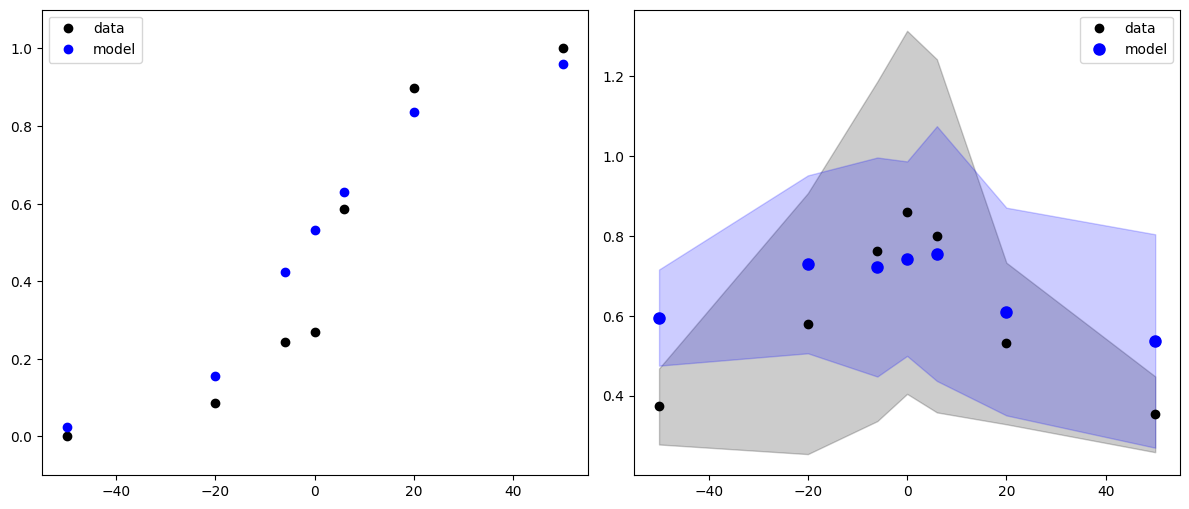

Proportion of invalid trials: 0.0
Fitting session 241129_GP_TZ

Session: 241129_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 549 trials
a (global): 5.8900
z (global): 0.2163
drift_offset (global): 0.7705
ndt (global): 0.1004
drift_gain (global): 16.1684
variance (global): 4.2372
leak_rate (global): 0.6019
time_constant (global): 0.0025

Simulation completed. Generated 549 trials.
Valid simulated trials: 540


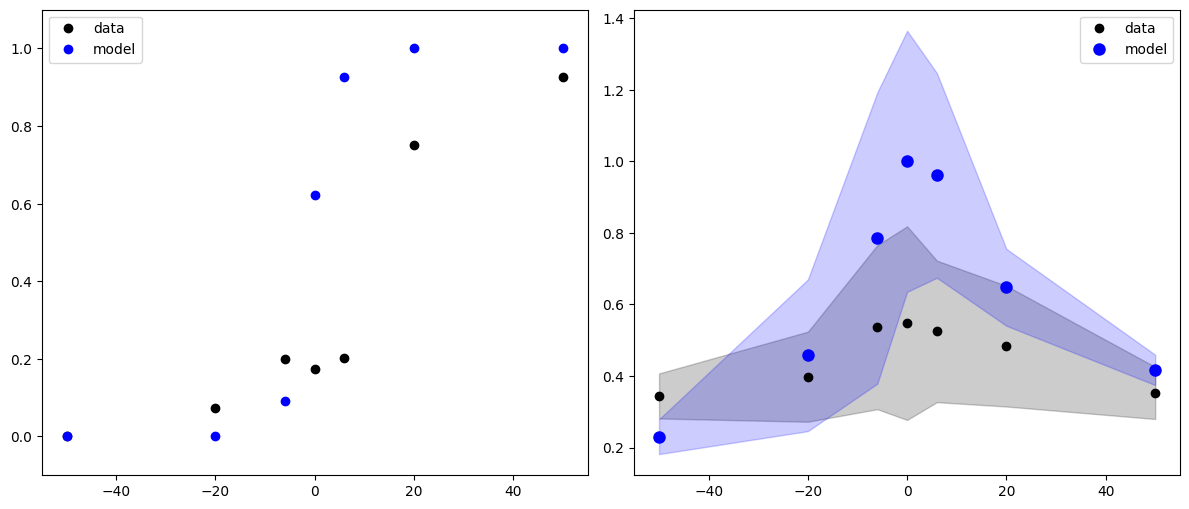

Proportion of invalid trials: 0.01639344262295082

Session: 241129_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 684 trials
a (global): 0.8000
z (global): 0.9000
drift_offset (global): 0.0000
ndt (global): 0.1000
drift_gain (global): 1.0000
variance (global): 0.1000
leak_rate (global): 0.0000
time_constant (global): 0.0010

Simulation completed. Generated 684 trials.
Valid simulated trials: 463


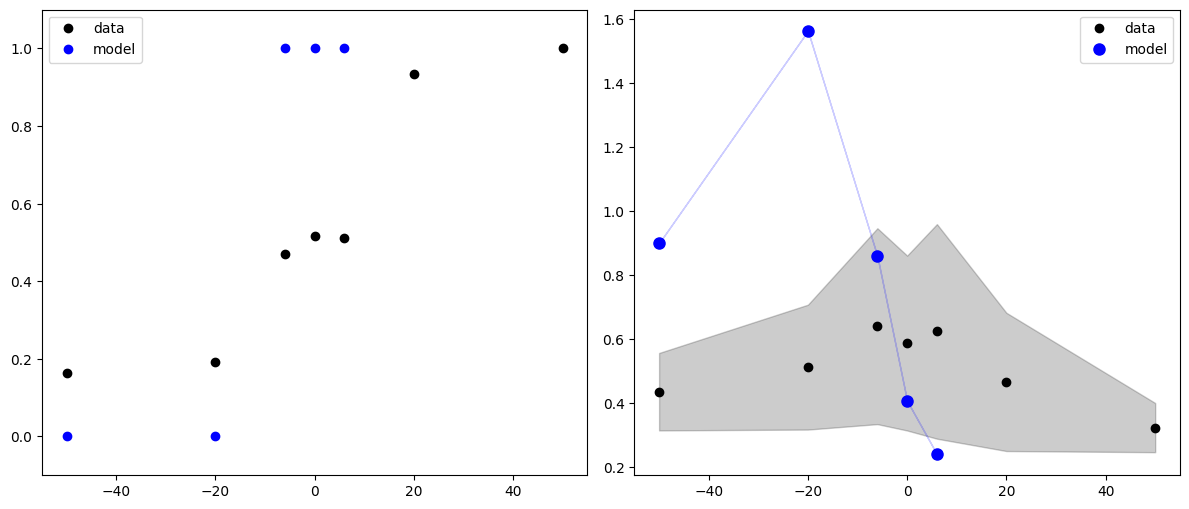

Proportion of invalid trials: 0.3230994152046784
Fitting session 210528_GP_JP

Session: 210528_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 353 trials
a (global): 2.0863
z (global): 0.5308
drift_offset (global): -1.1550
ndt (global): 0.1002
drift_gain (global): 5.9348
variance (global): 2.1825
leak_rate (global): 0.3120
time_constant (global): 0.0011

Simulation completed. Generated 353 trials.
Valid simulated trials: 353


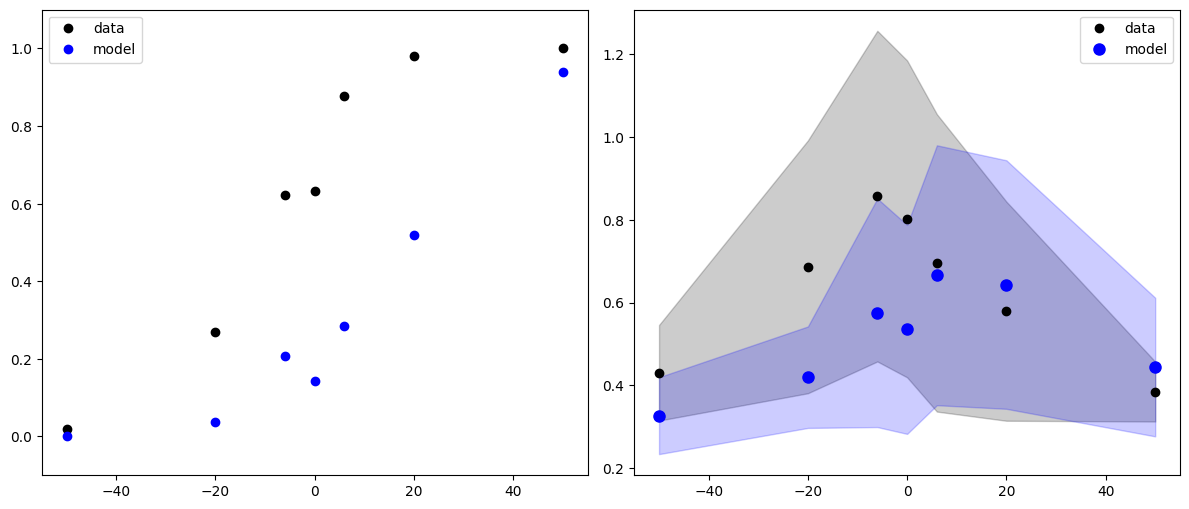

Proportion of invalid trials: 0.0

Session: 210528_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 744 trials
a (global): 2.7967
z (global): 0.7066
drift_offset (global): 0.1655
ndt (global): 0.1353
drift_gain (global): 9.6409
variance (global): 3.4841
leak_rate (global): 0.5184
time_constant (global): 0.0011

Simulation completed. Generated 744 trials.
Valid simulated trials: 744


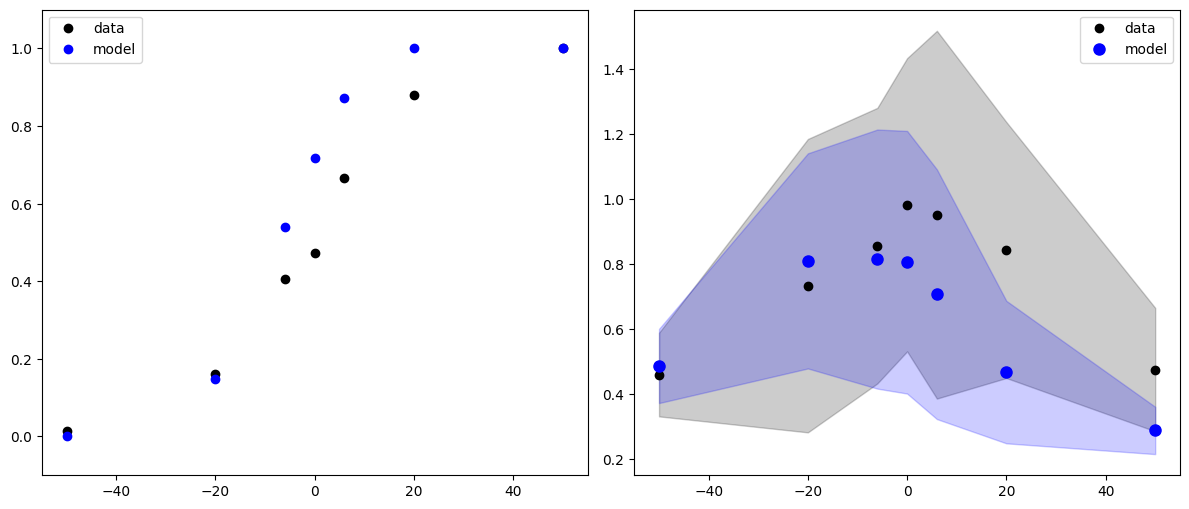

Proportion of invalid trials: 0.0
Fitting session 210524_GP_JP

Session: 210524_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 369 trials
a (global): 4.4231
z (global): 0.4136
drift_offset (global): -0.0335
ndt (global): 0.1184
drift_gain (global): 4.3272
variance (global): 4.2967
leak_rate (global): 0.1770
time_constant (global): 0.0031

Simulation completed. Generated 369 trials.
Valid simulated trials: 369


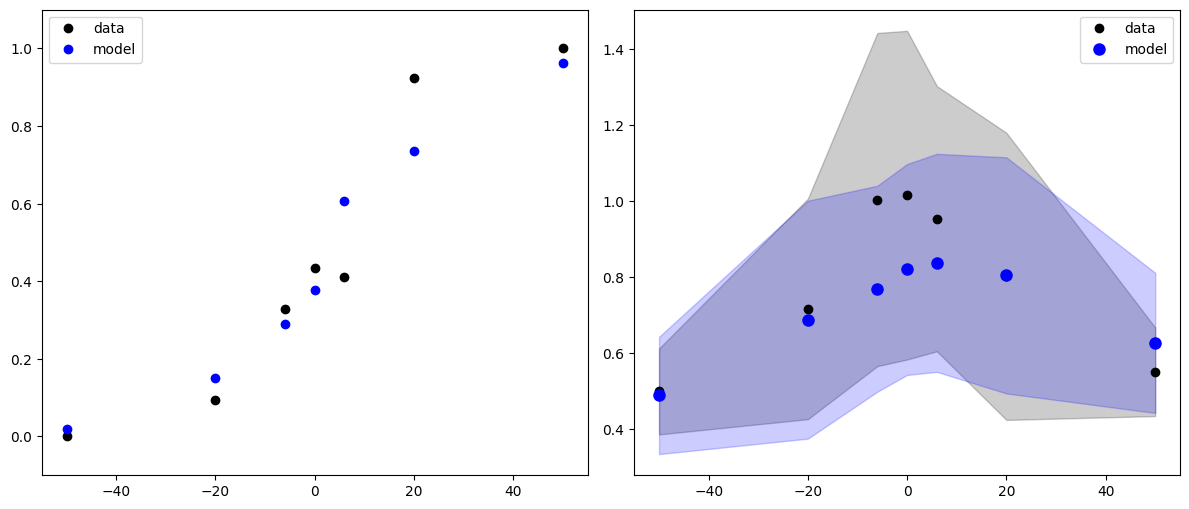

Proportion of invalid trials: 0.0

Session: 210524_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 617 trials
a (global): 2.3453
z (global): 0.6079
drift_offset (global): -0.1298
ndt (global): 0.1426
drift_gain (global): 1.1716
variance (global): 2.1211
leak_rate (global): 0.7513
time_constant (global): 0.0013

Simulation completed. Generated 617 trials.
Valid simulated trials: 617


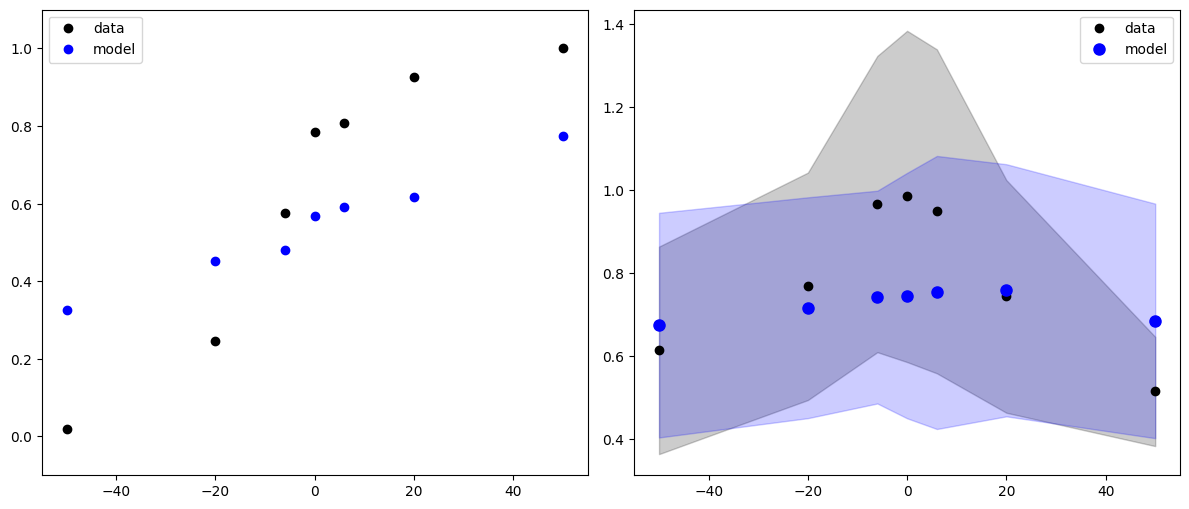

Proportion of invalid trials: 0.0
Fitting session 241216_GP_TZ

Session: 241216_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 498 trials
a (global): 3.2129
z (global): 0.4681
drift_offset (global): -0.2260
ndt (global): 0.1876
drift_gain (global): 3.8189
variance (global): 1.3662
leak_rate (global): 0.3679
time_constant (global): 0.0012

Simulation completed. Generated 498 trials.
Valid simulated trials: 498


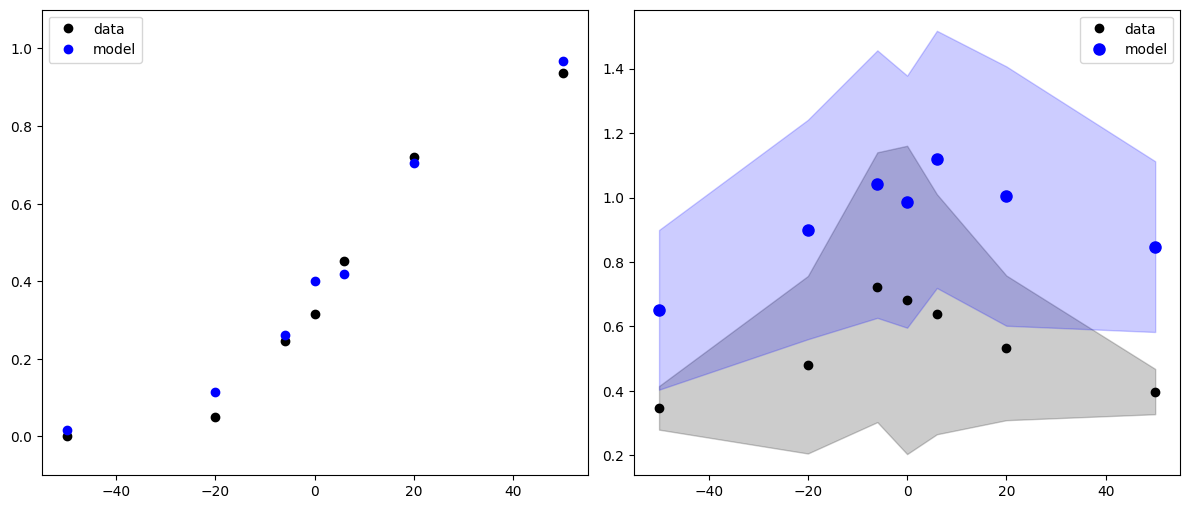

Proportion of invalid trials: 0.0

Session: 241216_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 681 trials
a (global): 5.6210
z (global): 0.5028
drift_offset (global): 0.3030
ndt (global): 0.1215
drift_gain (global): 10.0953
variance (global): 2.3588
leak_rate (global): 0.3644
time_constant (global): 0.0053

Simulation completed. Generated 681 trials.
Valid simulated trials: 681


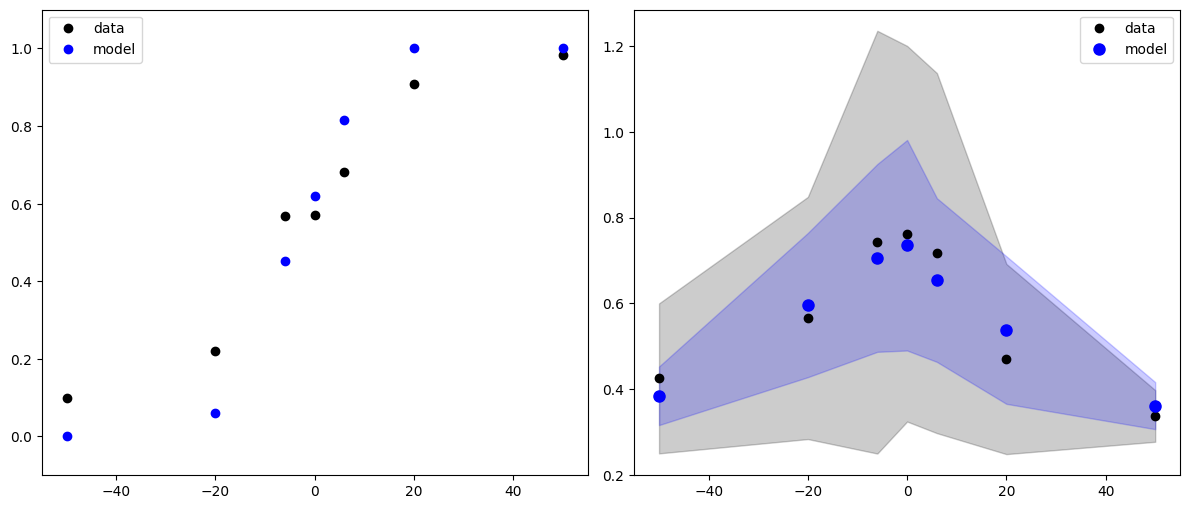

Proportion of invalid trials: 0.0
Fitting session 210318_GP_JP

Session: 210318_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 364 trials
a (global): 2.7164
z (global): 0.1804
drift_offset (global): 0.4674
ndt (global): 0.1241
drift_gain (global): 6.1935
variance (global): 4.3673
leak_rate (global): 0.9885
time_constant (global): 0.0012

Simulation completed. Generated 364 trials.
Valid simulated trials: 364


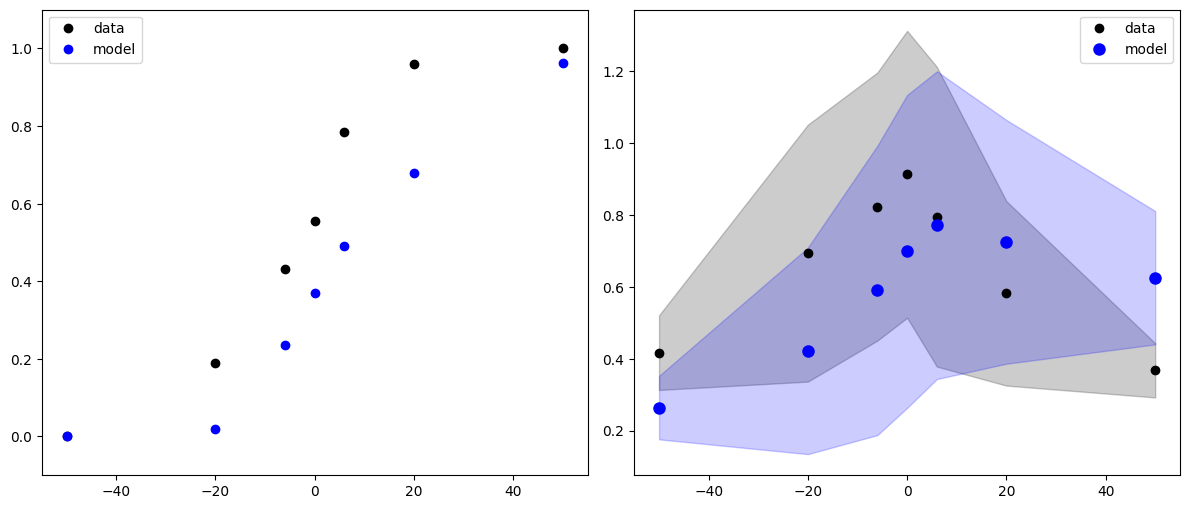

Proportion of invalid trials: 0.0

Session: 210318_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 740 trials
a (global): 5.7282
z (global): 0.6521
drift_offset (global): 0.6467
ndt (global): 0.1102
drift_gain (global): 9.7593
variance (global): 1.3676
leak_rate (global): 0.7253
time_constant (global): 0.0108

Simulation completed. Generated 740 trials.
Valid simulated trials: 740


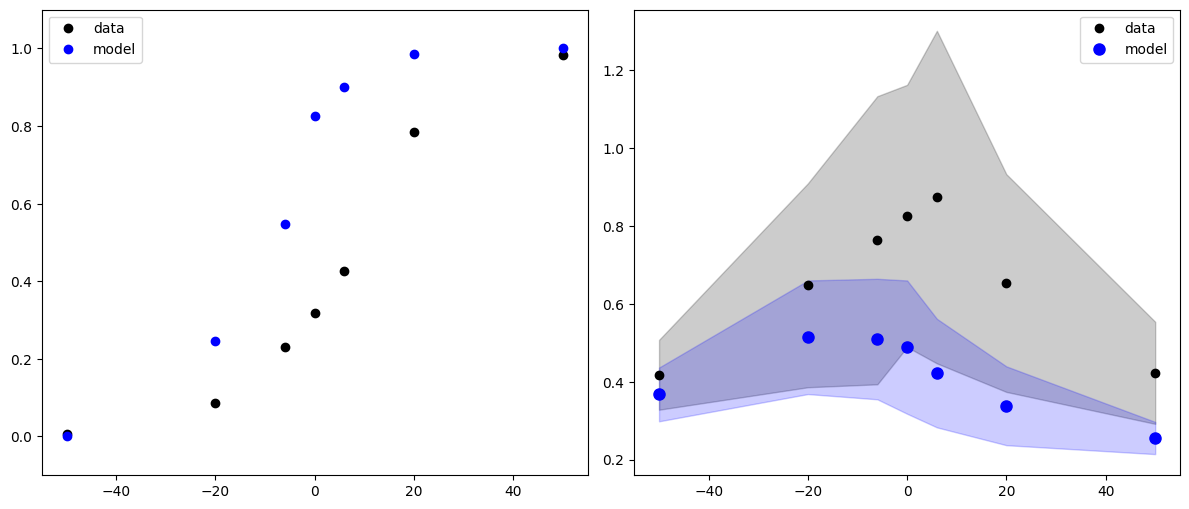

Proportion of invalid trials: 0.0
Fitting session 210312_GP_JP

Session: 210312_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 346 trials
a (global): 0.8000
z (global): 0.9000
drift_offset (global): -0.0100
ndt (global): 0.1000
drift_gain (global): 1.0000
variance (global): 0.1274
leak_rate (global): 0.0000
time_constant (global): 0.0010

Simulation completed. Generated 346 trials.
Valid simulated trials: 248


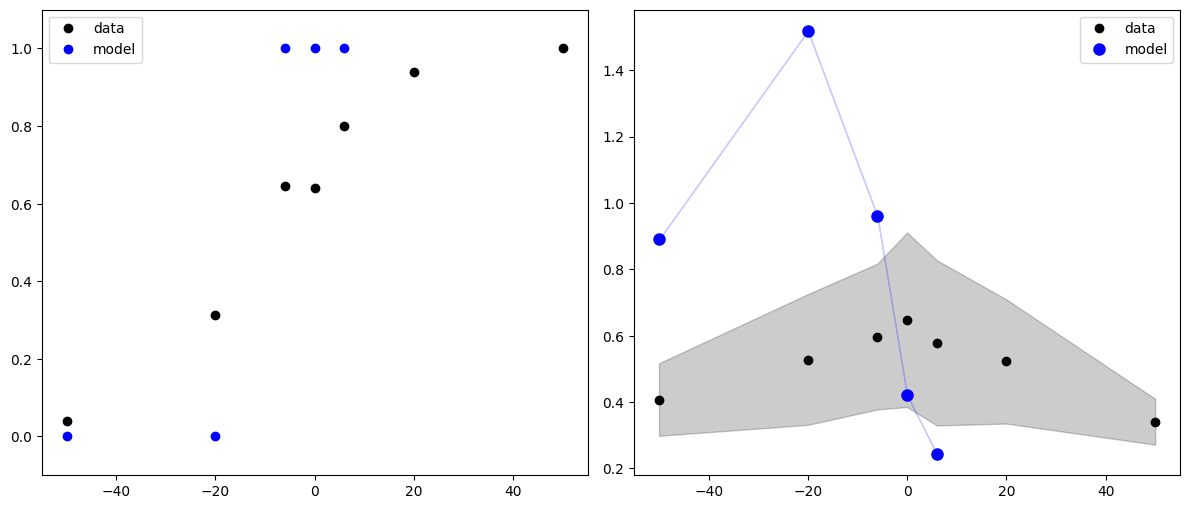

Proportion of invalid trials: 0.2832369942196532

Session: 210312_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 665 trials
a (global): 2.2622
z (global): 0.5376
drift_offset (global): 0.1009
ndt (global): 0.2989
drift_gain (global): 5.4575
variance (global): 4.1219
leak_rate (global): 0.2332
time_constant (global): 0.0011

Simulation completed. Generated 665 trials.
Valid simulated trials: 665


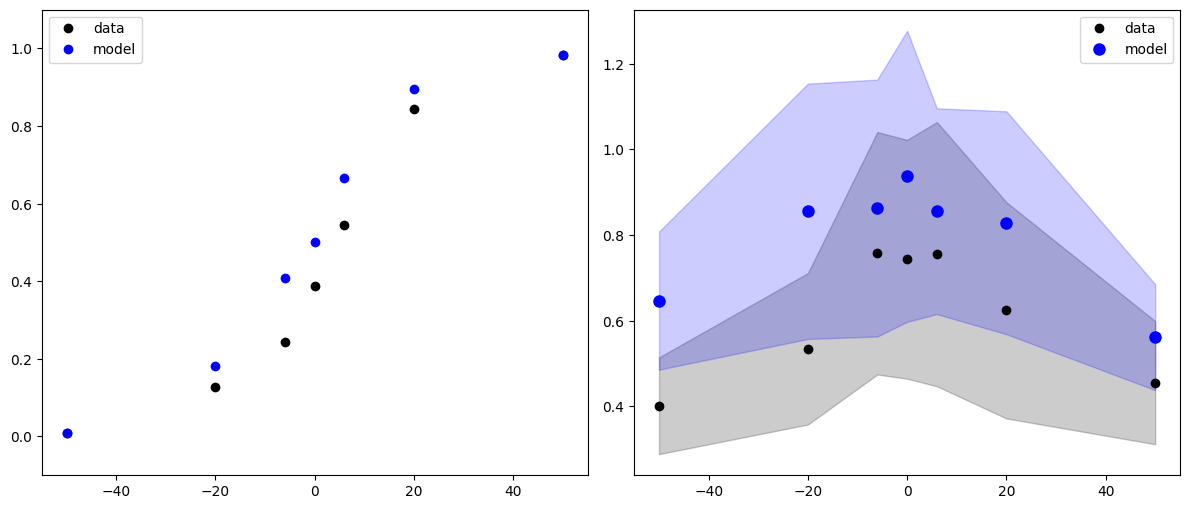

Proportion of invalid trials: 0.0
Fitting session 210316_GP_JP

Session: 210316_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 390 trials
a (global): 0.8000
z (global): 0.9000
drift_offset (global): -0.0100
ndt (global): 0.1000
drift_gain (global): 1.0000
variance (global): 0.1274
leak_rate (global): 0.0000
time_constant (global): 0.0010

Simulation completed. Generated 390 trials.
Valid simulated trials: 276


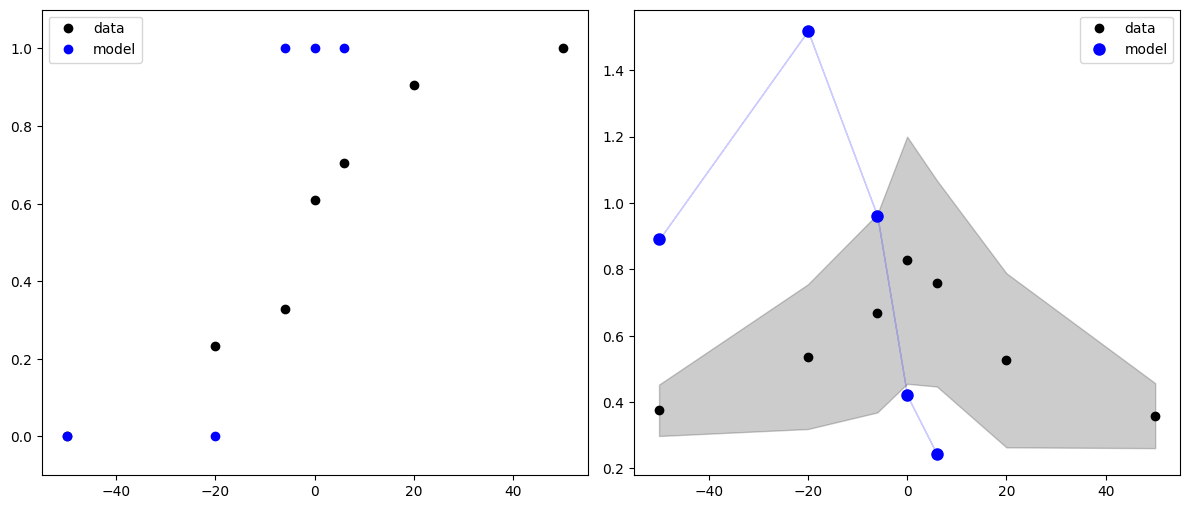

Proportion of invalid trials: 0.2923076923076923

Session: 210316_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 652 trials
a (global): 3.8007
z (global): 0.6211
drift_offset (global): 0.0813
ndt (global): 0.1113
drift_gain (global): 12.1761
variance (global): 2.7697
leak_rate (global): 0.1859
time_constant (global): 0.0038

Simulation completed. Generated 652 trials.
Valid simulated trials: 652


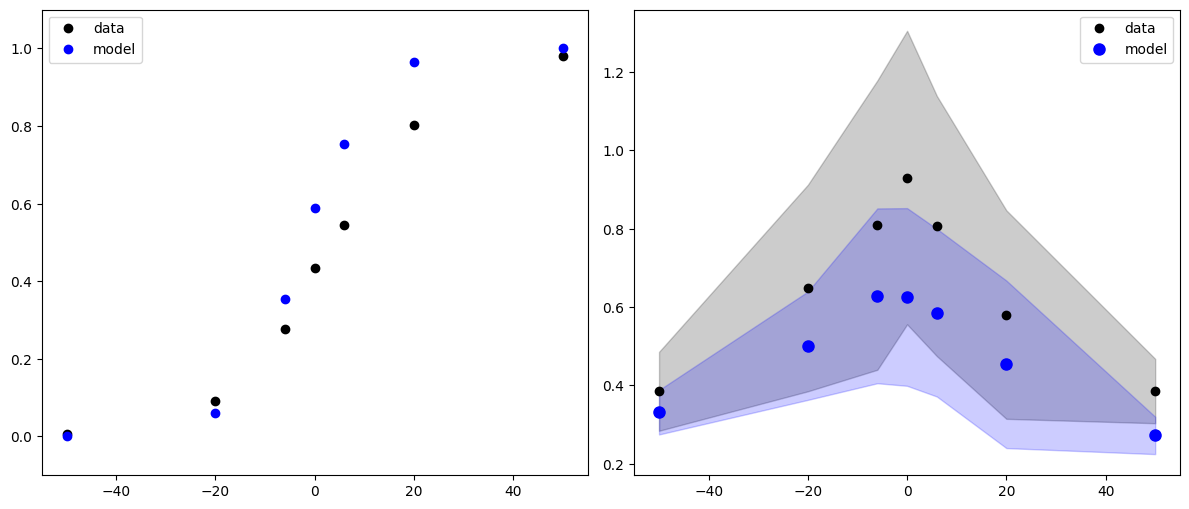

Proportion of invalid trials: 0.0
Fitting session 240828_GP_TZ

Session: 240828_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 532 trials
a (global): 0.8000
z (global): 0.9000
drift_offset (global): -0.0100
ndt (global): 0.1000
drift_gain (global): 1.0000
variance (global): 0.1274
leak_rate (global): 0.0000
time_constant (global): 0.0010

Simulation completed. Generated 532 trials.
Valid simulated trials: 334


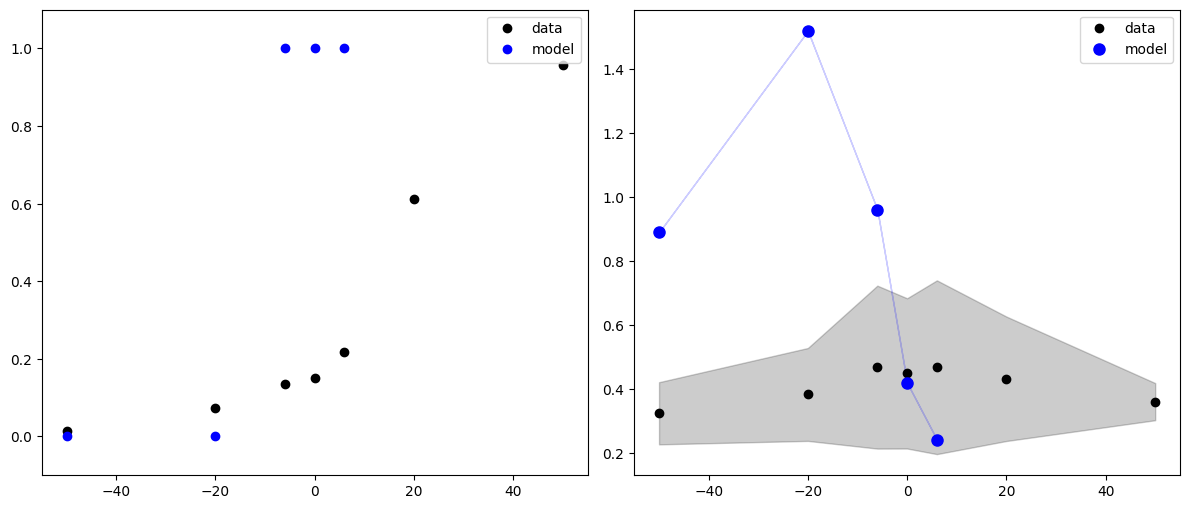

Proportion of invalid trials: 0.37218045112781956

Session: 240828_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 687 trials
a (global): 2.5843
z (global): 0.3982
drift_offset (global): 0.7112
ndt (global): 0.1597
drift_gain (global): 4.9625
variance (global): 2.2666
leak_rate (global): 0.5308
time_constant (global): 0.0012

Simulation completed. Generated 687 trials.
Valid simulated trials: 687


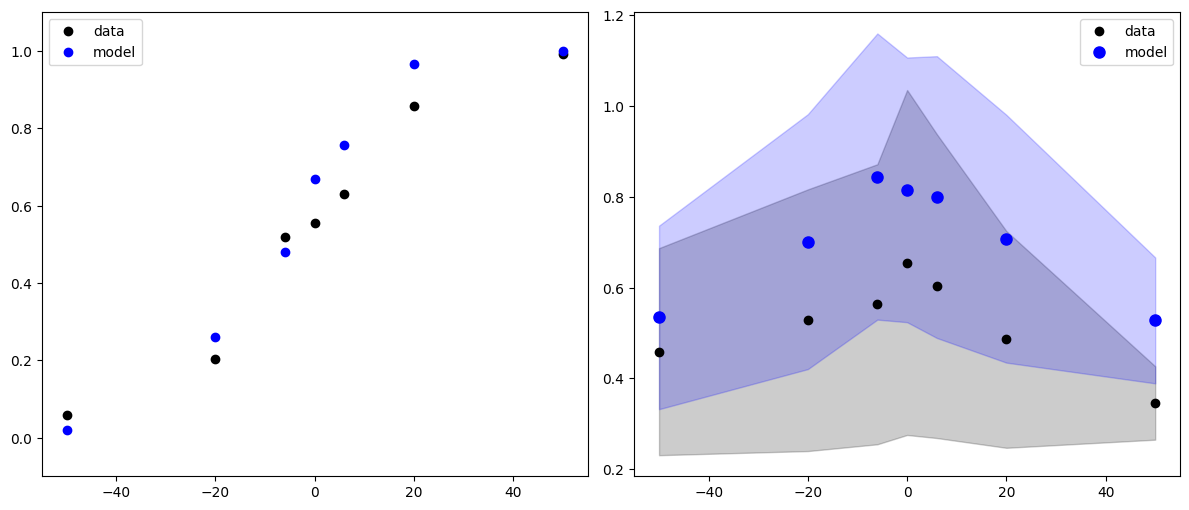

Proportion of invalid trials: 0.0
Fitting session 210224_GP_JP

Session: 210224_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 492 trials
a (global): 2.8508
z (global): 0.2379
drift_offset (global): -0.7371
ndt (global): 0.1222
drift_gain (global): 3.2278
variance (global): 4.9056
leak_rate (global): 0.3172
time_constant (global): 0.0036

Simulation completed. Generated 492 trials.
Valid simulated trials: 492


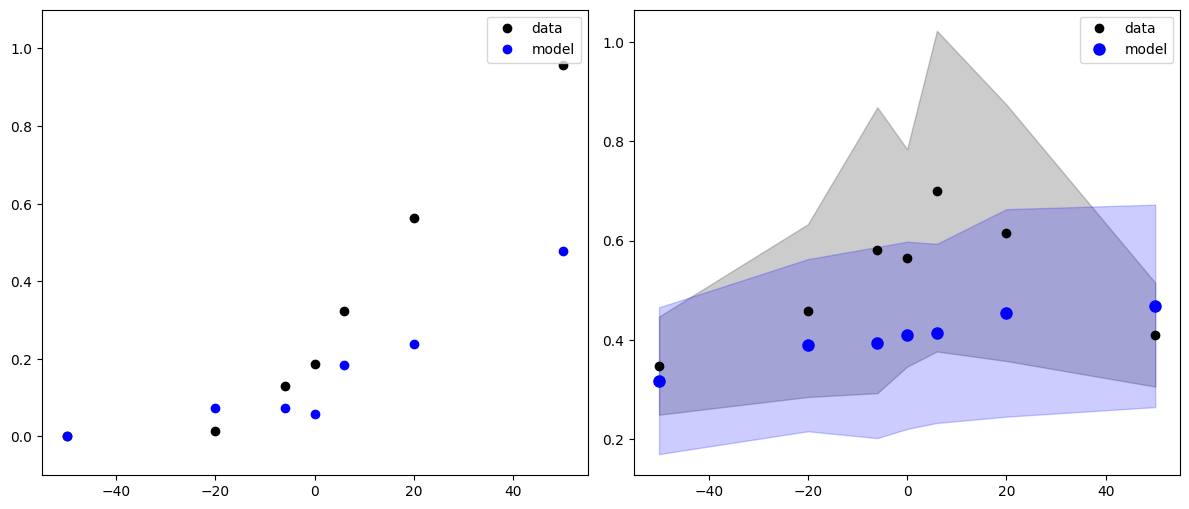

Proportion of invalid trials: 0.0

Session: 210224_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 797 trials
a (global): 2.8663
z (global): 0.5355
drift_offset (global): 0.0557
ndt (global): 0.1605
drift_gain (global): 1.9094
variance (global): 0.7310
leak_rate (global): 0.4158
time_constant (global): 0.0012

Simulation completed. Generated 797 trials.
Valid simulated trials: 797


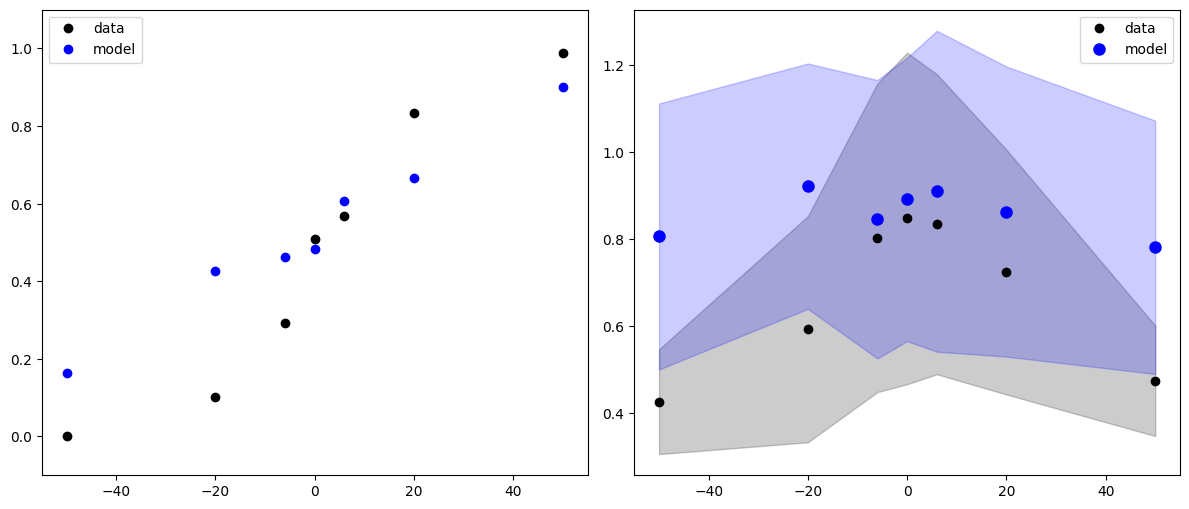

Proportion of invalid trials: 0.0
Fitting session 210603_GP_JP

Session: 210603_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 353 trials
a (global): 5.9169
z (global): 0.3027
drift_offset (global): -0.7068
ndt (global): 0.1890
drift_gain (global): 3.0709
variance (global): 0.8750
leak_rate (global): 0.5837
time_constant (global): 0.0096

Simulation completed. Generated 353 trials.
Valid simulated trials: 353


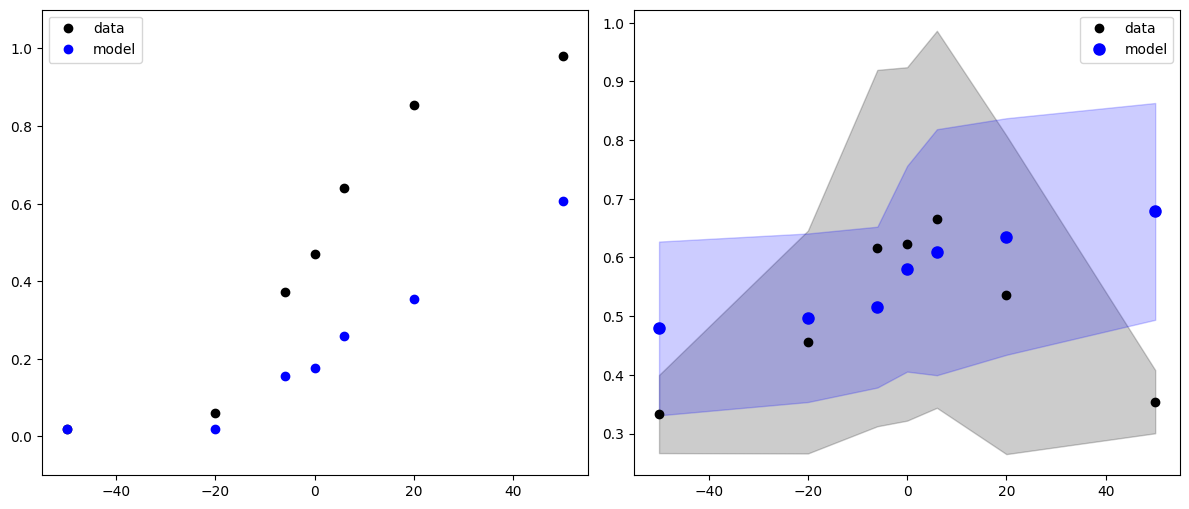

Proportion of invalid trials: 0.0

Session: 210603_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 900 trials
a (global): 3.0888
z (global): 0.7963
drift_offset (global): -0.0867
ndt (global): 0.2117
drift_gain (global): 18.6369
variance (global): 2.0261
leak_rate (global): 0.3569
time_constant (global): 0.0013

Simulation completed. Generated 900 trials.
Valid simulated trials: 900


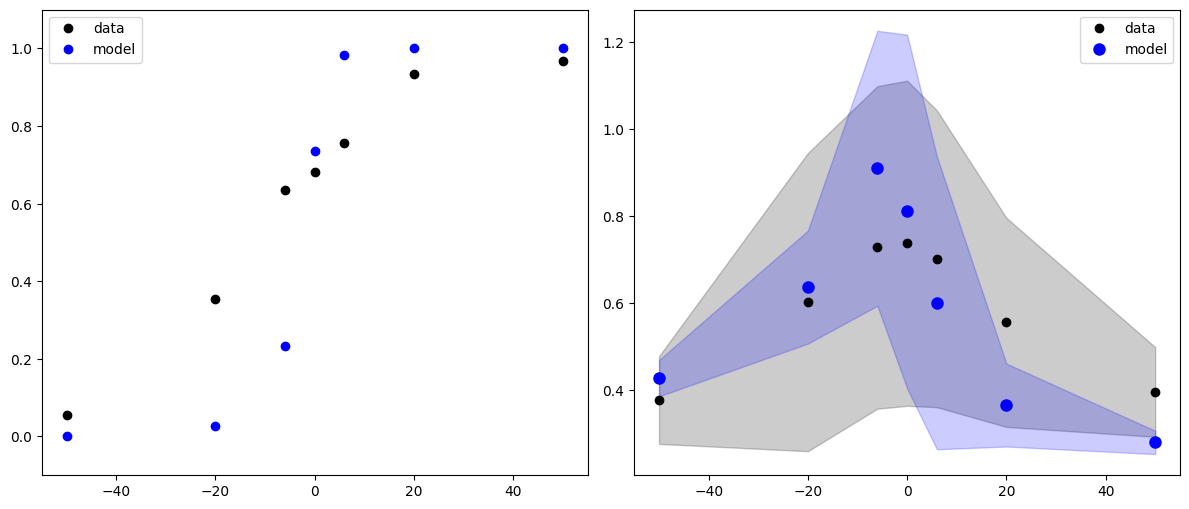

Proportion of invalid trials: 0.0
Fitting session 210601_GP_JP

Session: 210601_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 333 trials
a (global): 4.9170
z (global): 0.2843
drift_offset (global): 0.2353
ndt (global): 0.1556
drift_gain (global): 4.5581
variance (global): 0.1421
leak_rate (global): 0.3135
time_constant (global): 0.0062

Simulation completed. Generated 333 trials.
Valid simulated trials: 333


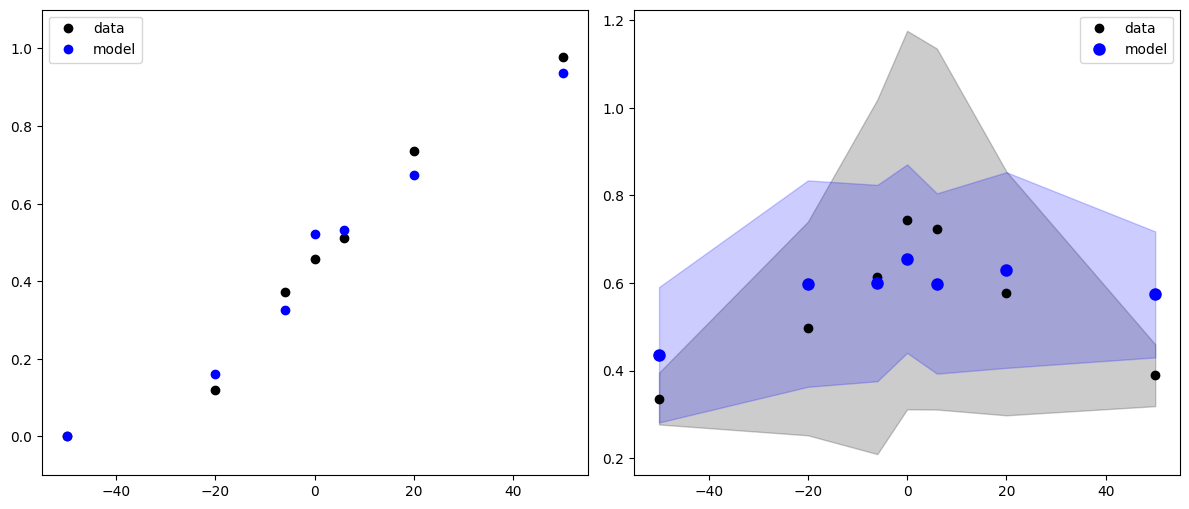

Proportion of invalid trials: 0.0

Session: 210601_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 895 trials
a (global): 4.5846
z (global): 0.8092
drift_offset (global): -0.1644
ndt (global): 0.2655
drift_gain (global): 9.8788
variance (global): 1.7472
leak_rate (global): 0.7671
time_constant (global): 0.0024

Simulation completed. Generated 895 trials.
Valid simulated trials: 895


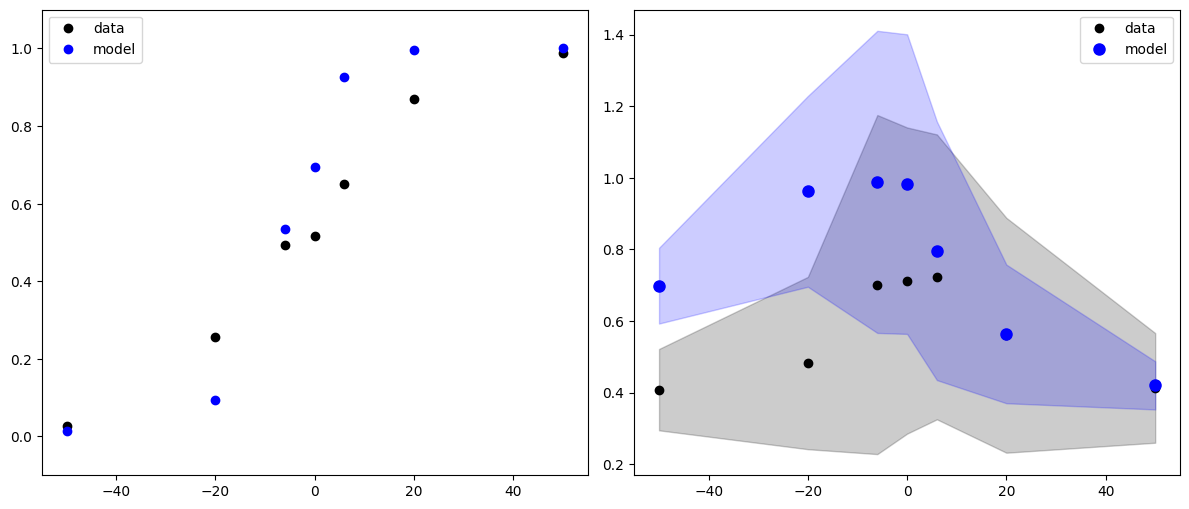

Proportion of invalid trials: 0.0
Fitting session 210609_GP_JP

Session: 210609_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 422 trials
a (global): 3.0268
z (global): 0.2664
drift_offset (global): 0.4103
ndt (global): 0.1369
drift_gain (global): 9.7349
variance (global): 1.1917
leak_rate (global): 0.5981
time_constant (global): 0.0019

Simulation completed. Generated 422 trials.
Valid simulated trials: 422


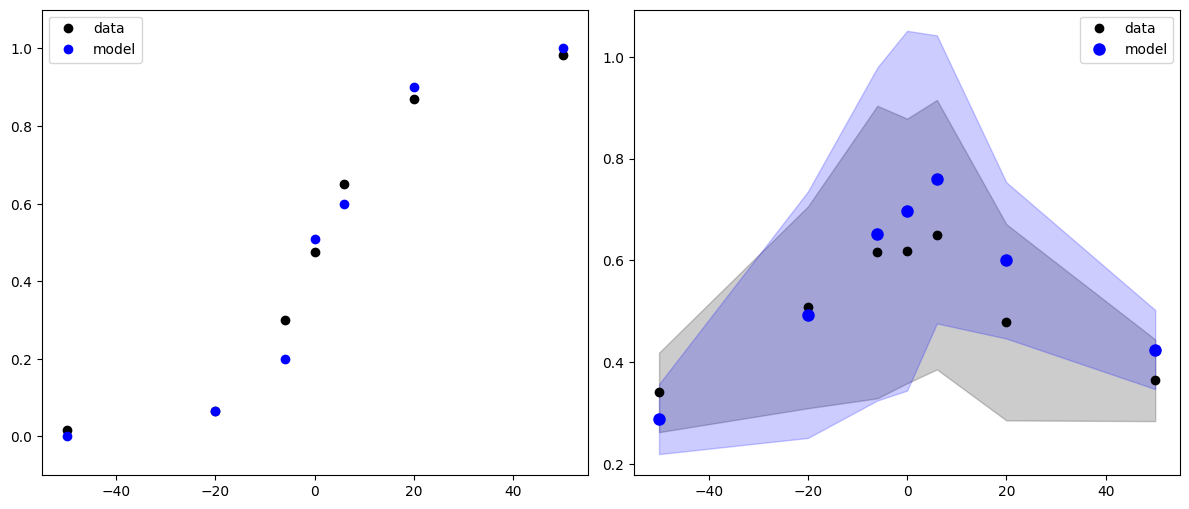

Proportion of invalid trials: 0.0

Session: 210609_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 889 trials
a (global): 0.8000
z (global): 0.1000
drift_offset (global): 0.0000
ndt (global): 0.1000
drift_gain (global): 1.0000
variance (global): 0.1000
leak_rate (global): 0.0000
time_constant (global): 0.0010

Simulation completed. Generated 889 trials.
Valid simulated trials: 585


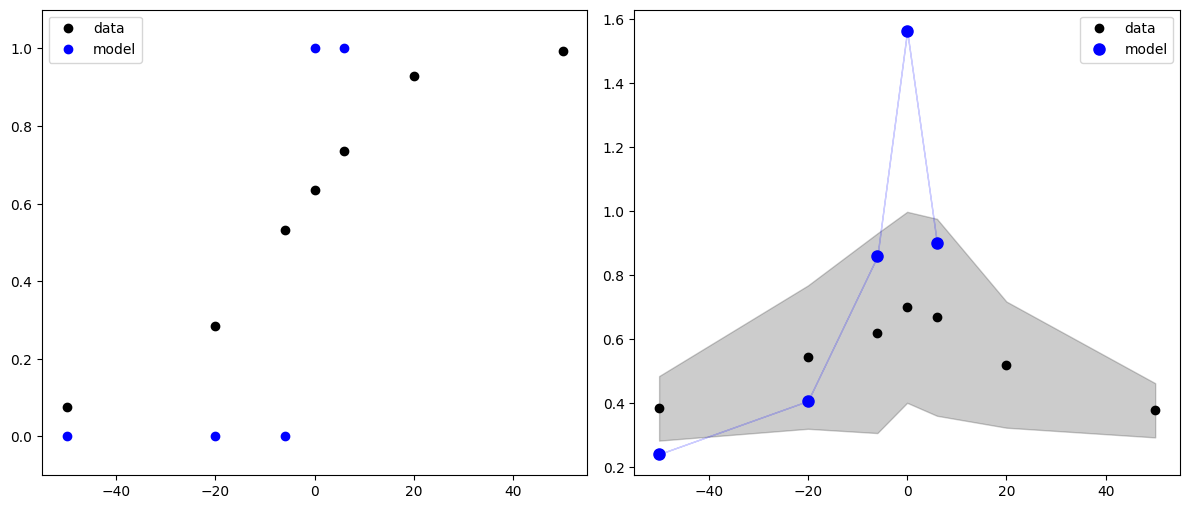

Proportion of invalid trials: 0.34195725534308213
Fitting session 210302_GP_JP

Session: 210302_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 353 trials
a (global): 5.9642
z (global): 0.7426
drift_offset (global): -0.5412
ndt (global): 0.1248
drift_gain (global): 3.5402
variance (global): 1.3946
leak_rate (global): 0.8156
time_constant (global): 0.0080

Simulation completed. Generated 353 trials.
Valid simulated trials: 353


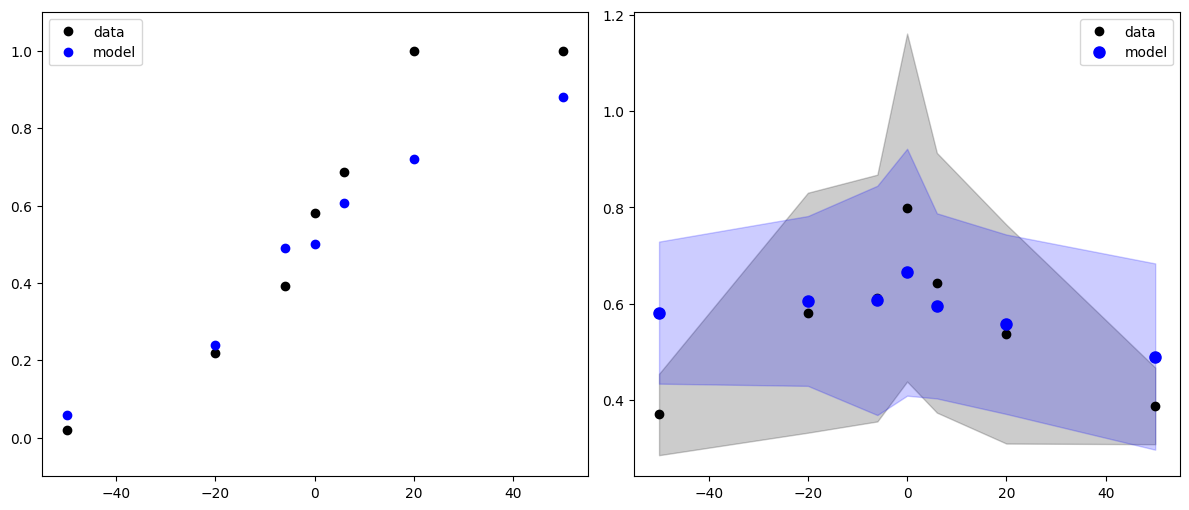

Proportion of invalid trials: 0.0

Session: 210302_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 691 trials
a (global): 4.7301
z (global): 0.8540
drift_offset (global): -0.0194
ndt (global): 0.4300
drift_gain (global): 4.8468
variance (global): 3.2634
leak_rate (global): 0.4610
time_constant (global): 0.0049

Simulation completed. Generated 691 trials.
Valid simulated trials: 691


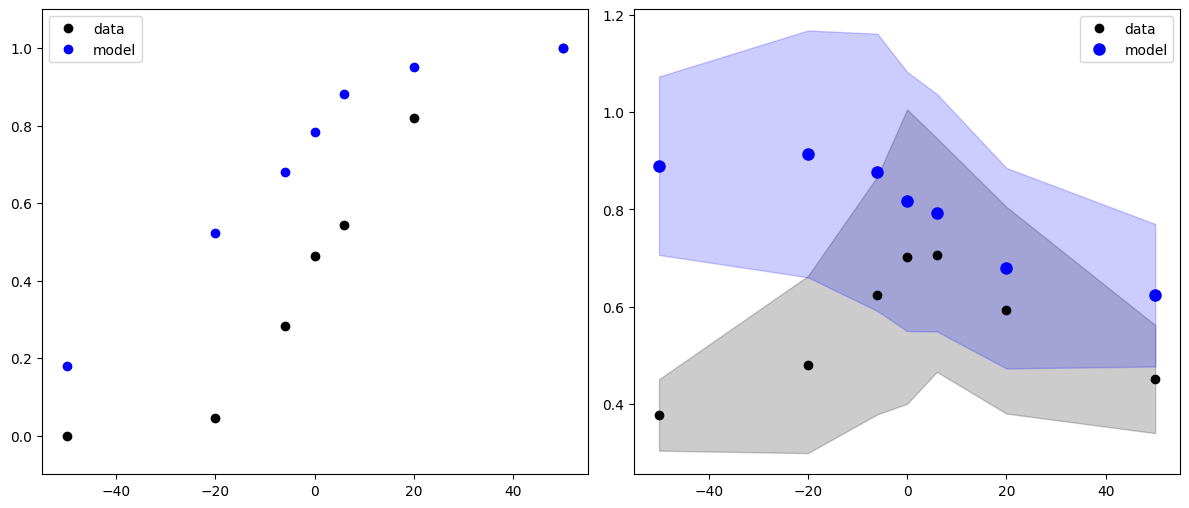

Proportion of invalid trials: 0.0


In [12]:
for idx_session, session_id in enumerate(session_ids):
    print(f"Fitting session {session_id}")
    data = behavior_df[(behavior_df.session_id == session_id)]
    data = data[["signed_coherence", "choice", "rt", "prior_block"]]
    data["choice"] = data["choice"].astype(int)

    # Get stimulus length
    stimulus_length = int(np.max(data["rt"]) * 1000)
    stimulus = np.tile(data["signed_coherence"].to_numpy().reshape(-1, 1), (1, stimulus_length)) / 100  # range[-1,1]

    # Simulate and plot for each prior condition
    for idx_prior, prior in enumerate(["equal", "unequal"]):
        print(f"\n{'='*50}")
        print(f"Session: {session_id}, Prior: {prior} (idx: {idx_prior})")
        print(f"{'='*50}")

        # Filter data and stimulus for this prior condition
        prior_mask = data["prior_block"] == prior
        prior_data = data[prior_mask].reset_index(drop=True)
        prior_stimulus = stimulus[prior_mask]

        if len(prior_data) == 0:
            print(f"No data found for prior condition: {prior}")
            continue

        print(f"Prior condition '{prior}' has {len(prior_data)} trials")

        # Simulate with parameters fitted for this prior condition
        if prior == "equal":
            model = equal_dict["models"][idx_session]
            result = equal_dict["results"][idx_session]
        else:
            model = unequal_dict["models"][idx_session]
            result = unequal_dict["results"][idx_session]
        model_sim = simulate_ddm(idx_prior, model, result, prior_stimulus, enable_leak=ENABLE_LEAK, enable_time_dependence=ENABLE_TIME_DEPENDENCY)

        print(f"\nSimulation completed. Generated {len(model_sim)} trials.")
        print(f"Valid simulated trials: {np.sum(~np.isnan(model_sim['choice']))}")

        # Plot comparison
        plot_ddm_fit(model_sim, prior_data)